In [1]:
!nvidia-smi

Fri Feb 23 15:02:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   30C    P8              21W / 215W |    833MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

(3387,)
(1025,)


In [10]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [12]:
from IConNet.nn.model import M18

In [13]:
from omegaconf import OmegaConf as ocf

In [14]:
import traceback

In [15]:
model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [9, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}

In [16]:
model = M18(config=model_config,
           n_input=1, n_output=len(labels))
model

M18(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(160, 32, batch_first=True)
    (pad_layer)

In [17]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [18]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [19]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                                                                                                                             | 0.007272727272727273/10 [00:00<14:56, 89.73s/it]

Train Epoch: 1 [0/3387 (0%)]	Loss: 1.435718
Mem before-during-after: 3256832 2642309120 37331968


  2%|██▋                                                                                                                                                                            | 0.15272727272727266/10 [00:11<11:49, 72.07s/it]

Train Epoch: 1 [640/3387 (19%)]	Loss: 0.902589
Mem before-during-after: 37228544 2650569216 37228544


  3%|█████▏                                                                                                                                                                          | 0.2981818181818183/10 [00:22<11:46, 72.85s/it]

Train Epoch: 1 [1280/3387 (38%)]	Loss: 1.123340
Mem before-during-after: 38236160 2661270528 37331968


  4%|███████▊                                                                                                                                                                        | 0.4436363636363647/10 [00:33<11:32, 72.46s/it]

Train Epoch: 1 [1920/3387 (57%)]	Loss: 1.486038
Mem before-during-after: 37220352 2658826240 37869568


  6%|██████████▎                                                                                                                                                                     | 0.5854545454545474/10 [00:44<12:48, 81.61s/it]

Train Epoch: 1 [2560/3387 (76%)]	Loss: 0.662963
Mem before-during-after: 37220352 2661831680 38124544


  7%|████████████▉                                                                                                                                                                   | 0.7345454545454575/10 [00:55<11:05, 71.81s/it]

Train Epoch: 1 [3200/3387 (95%)]	Loss: 1.310552
Mem before-during-after: 37893120 2659979264 37220352


 10%|█████████████████▌                                                                                                                                                              | 1.0000000000000047/10 [01:08<07:04, 47.20s/it]


Test Epoch: 1	Accuracy: 579/1024 (56%)



 10%|█████████████████▊                                                                                                                                                               | 1.007272727272732/10 [01:09<08:12, 54.72s/it]

Train Epoch: 2 [0/3387 (0%)]	Loss: 1.237506
Mem before-during-after: 38232064 2661494272 38236160


 12%|████████████████████▎                                                                                                                                                           | 1.1527272727272784/10 [01:19<10:37, 72.01s/it]

Train Epoch: 2 [640/3387 (19%)]	Loss: 1.185027
Mem before-during-after: 37220352 2659042304 37436416


 13%|██████████████████████▊                                                                                                                                                         | 1.2981818181818248/10 [01:30<10:34, 72.86s/it]

Train Epoch: 2 [1280/3387 (38%)]	Loss: 0.806515
Mem before-during-after: 37807104 2651379200 37228544


 14%|█████████████████████████▍                                                                                                                                                      | 1.4436363636363712/10 [01:41<10:20, 72.48s/it]

Train Epoch: 2 [1920/3387 (57%)]	Loss: 0.930330
Mem before-during-after: 38132736 2650952192 37228544


 16%|███████████████████████████▉                                                                                                                                                    | 1.5890909090909175/10 [01:51<10:08, 72.35s/it]

Train Epoch: 2 [2560/3387 (76%)]	Loss: 0.698112
Mem before-during-after: 37331968 2661419008 37331968


 17%|██████████████████████████████▋                                                                                                                                                  | 1.734545454545464/10 [02:02<09:53, 71.78s/it]

Train Epoch: 2 [3200/3387 (95%)]	Loss: 1.180381
Mem before-during-after: 37869568 2660148224 37331968


 20%|███████████████████████████████████▍                                                                                                                                             | 2.000000000000011/10 [02:16<06:11, 46.38s/it]


Test Epoch: 2	Accuracy: 628/1024 (61%)



 20%|███████████████████████████████████▌                                                                                                                                             | 2.007272727272738/10 [02:16<07:11, 54.02s/it]

Train Epoch: 3 [0/3387 (0%)]	Loss: 1.051744
Mem before-during-after: 38232064 2661494272 38236160


 22%|█████████████████████████████████████▉                                                                                                                                          | 2.1527272727272755/10 [02:27<09:18, 71.20s/it]

Train Epoch: 3 [640/3387 (19%)]	Loss: 0.719383
Mem before-during-after: 37228544 2650569216 37228544


 23%|████████████████████████████████████████▋                                                                                                                                        | 2.298181818181813/10 [02:37<09:01, 70.30s/it]

Train Epoch: 3 [1280/3387 (38%)]	Loss: 0.843782
Mem before-during-after: 38124544 2651696640 37220352


 24%|███████████████████████████████████████████                                                                                                                                     | 2.4436363636363505/10 [02:48<09:13, 73.18s/it]

Train Epoch: 3 [1920/3387 (57%)]	Loss: 0.738764
Mem before-during-after: 37228544 2660179968 37678592


 26%|█████████████████████████████████████████████▊                                                                                                                                   | 2.589090909090888/10 [02:59<08:54, 72.11s/it]

Train Epoch: 3 [2560/3387 (76%)]	Loss: 1.159043
Mem before-during-after: 37331968 2660514816 37331968


 27%|████████████████████████████████████████████████▏                                                                                                                               | 2.7345454545454255/10 [03:09<08:28, 69.93s/it]

Train Epoch: 3 [3200/3387 (95%)]	Loss: 0.917945
Mem before-during-after: 37331968 2652305920 37331968


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 2.9999999999999565/10 [03:23<05:13, 44.82s/it]


Test Epoch: 3	Accuracy: 590/1024 (58%)



 30%|████████████████████████████████████████████████████▉                                                                                                                           | 3.0072727272726834/10 [03:23<06:02, 51.83s/it]

Train Epoch: 4 [0/3387 (0%)]	Loss: 0.859601
Mem before-during-after: 37727232 2652179456 37220352


 32%|███████████████████████████████████████████████████████▊                                                                                                                         | 3.152727272727221/10 [03:34<08:07, 71.22s/it]

Train Epoch: 4 [640/3387 (19%)]	Loss: 0.887389
Mem before-during-after: 37228544 2660147200 37331968


 33%|██████████████████████████████████████████████████████████                                                                                                                      | 3.2981818181817584/10 [03:45<08:01, 71.85s/it]

Train Epoch: 4 [1280/3387 (38%)]	Loss: 1.118505
Mem before-during-after: 37436416 2660806144 37331968


 34%|████████████████████████████████████████████████████████████▉                                                                                                                    | 3.443636363636296/10 [03:56<08:01, 73.49s/it]

Train Epoch: 4 [1920/3387 (57%)]	Loss: 1.130214
Mem before-during-after: 37220352 2660254720 37220352


 36%|███████████████████████████████████████████████████████████████▏                                                                                                                | 3.5890909090908334/10 [04:06<07:44, 72.41s/it]

Train Epoch: 4 [2560/3387 (76%)]	Loss: 1.172565
Mem before-during-after: 38236160 2661355520 38236160


 37%|██████████████████████████████████████████████████████████████████                                                                                                               | 3.734545454545371/10 [04:17<07:22, 70.62s/it]

Train Epoch: 4 [3200/3387 (95%)]	Loss: 1.375593
Mem before-during-after: 37331968 2661419008 37331968


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 3.999999999999902/10 [04:30<04:41, 46.93s/it]


Test Epoch: 4	Accuracy: 615/1024 (60%)



 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.007272727272629/10 [04:31<05:25, 54.30s/it]

Train Epoch: 5 [0/3387 (0%)]	Loss: 0.750979
Mem before-during-after: 37696512 2661166592 37436416


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                       | 4.1527272727271844/10 [04:41<07:04, 72.67s/it]

Train Epoch: 5 [640/3387 (19%)]	Loss: 0.789222
Mem before-during-after: 37700608 2660636672 37700608


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 4.294545454545376/10 [04:52<07:48, 82.17s/it]

Train Epoch: 5 [1280/3387 (38%)]	Loss: 0.978043
Mem before-during-after: 38236160 2660746240 37869568


 44%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 4.443636363636295/10 [05:03<06:51, 74.15s/it]

Train Epoch: 5 [1920/3387 (57%)]	Loss: 0.806191
Mem before-during-after: 38236160 2661303296 38236160


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 4.585454545454486/10 [05:14<07:21, 81.45s/it]

Train Epoch: 5 [2560/3387 (76%)]	Loss: 0.760208
Mem before-during-after: 37869568 2660788224 37331968


 47%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 4.7345454545454055/10 [05:25<06:17, 71.73s/it]

Train Epoch: 5 [3200/3387 (95%)]	Loss: 1.144754
Mem before-during-after: 37220352 2660171776 37220352


 50%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 4.999999999999969/10 [05:38<03:51, 46.37s/it]


Test Epoch: 5	Accuracy: 639/1024 (62%)



 50%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 5.007272727272697/10 [05:39<04:32, 54.50s/it]

Train Epoch: 6 [0/3387 (0%)]	Loss: 0.771564
Mem before-during-after: 37224448 2660076032 37220352


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 5.152727272727252/10 [05:50<05:49, 72.03s/it]

Train Epoch: 6 [640/3387 (19%)]	Loss: 0.901972
Mem before-during-after: 37856256 2650792448 37220352


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 5.298181818181807/10 [06:00<05:34, 71.24s/it]

Train Epoch: 6 [1280/3387 (38%)]	Loss: 1.014838
Mem before-during-after: 37228544 2660468736 38205440


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 5.4436363636363625/10 [06:11<05:33, 73.13s/it]

Train Epoch: 6 [1920/3387 (57%)]	Loss: 0.924722
Mem before-during-after: 37331968 2653341696 37331968


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 5.589090909090918/10 [06:22<05:17, 71.98s/it]

Train Epoch: 6 [2560/3387 (76%)]	Loss: 1.237038
Mem before-during-after: 38236160 2653342208 37710336


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5.734545454545473/10 [06:32<05:07, 72.01s/it]

Train Epoch: 6 [3200/3387 (95%)]	Loss: 1.032990
Mem before-during-after: 38124544 2651696640 37220352


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000036/10 [06:46<03:07, 46.99s/it]


Test Epoch: 6	Accuracy: 621/1024 (61%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 6.007272727272764/10 [06:46<03:38, 54.62s/it]

Train Epoch: 7 [0/3387 (0%)]	Loss: 1.080390
Mem before-during-after: 37216256 2650916352 37220352


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6.1527272727273195/10 [06:57<04:34, 71.44s/it]

Train Epoch: 7 [640/3387 (19%)]	Loss: 0.988809
Mem before-during-after: 37331968 2660260352 37331968


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6.298181818181875/10 [07:08<04:28, 72.64s/it]

Train Epoch: 7 [1280/3387 (38%)]	Loss: 0.968460
Mem before-during-after: 37220352 2659483648 37220352


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 6.44363636363643/10 [07:19<04:15, 71.90s/it]

Train Epoch: 7 [1920/3387 (57%)]	Loss: 0.744513
Mem before-during-after: 38236160 2660482048 37678592


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6.589090909090985/10 [07:29<04:11, 73.61s/it]

Train Epoch: 7 [2560/3387 (76%)]	Loss: 0.969618
Mem before-during-after: 37220352 2660652032 37220352


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6.730909090909177/10 [07:40<04:34, 83.90s/it]

Train Epoch: 7 [3200/3387 (95%)]	Loss: 0.683643
Mem before-during-after: 37331968 2660514816 37331968


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000104/10 [07:54<02:22, 47.54s/it]


Test Epoch: 7	Accuracy: 625/1024 (61%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7.007272727272832/10 [07:54<02:36, 52.17s/it]

Train Epoch: 8 [0/3387 (0%)]	Loss: 0.902990
Mem before-during-after: 37327872 2653239296 37752832


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 7.152727272727387/10 [08:05<03:28, 73.31s/it]

Train Epoch: 8 [640/3387 (19%)]	Loss: 0.964993
Mem before-during-after: 37220352 2661259264 38124544


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 7.298181818181942/10 [08:16<03:24, 75.62s/it]

Train Epoch: 8 [1280/3387 (38%)]	Loss: 0.837596
Mem before-during-after: 37220352 2658826240 38236160


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 7.4436363636364975/10 [08:27<03:00, 70.65s/it]

Train Epoch: 8 [1920/3387 (57%)]	Loss: 0.810480
Mem before-during-after: 37220352 2660634624 38124544


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7.589090909091053/10 [08:37<02:53, 72.07s/it]

Train Epoch: 8 [2560/3387 (76%)]	Loss: 0.770233
Mem before-during-after: 37220352 2659042304 38236160


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7.730909090909244/10 [08:48<03:03, 81.02s/it]

Train Epoch: 8 [3200/3387 (95%)]	Loss: 0.751045
Mem before-during-after: 37220352 2661523456 38124544


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 8.00000000000017/10 [09:01<01:32, 46.15s/it]


Test Epoch: 8	Accuracy: 623/1024 (61%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8.007272727272898/10 [09:02<01:44, 52.29s/it]

Train Epoch: 9 [0/3387 (0%)]	Loss: 0.800797
Mem before-during-after: 37216256 2651213824 37220352


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 8.14909090909109/10 [09:12<02:29, 80.86s/it]

Train Epoch: 9 [640/3387 (19%)]	Loss: 0.899633
Mem before-during-after: 37331968 2661157888 37331968


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 8.298181818182009/10 [09:23<02:07, 74.64s/it]

Train Epoch: 9 [1280/3387 (38%)]	Loss: 0.553639
Mem before-during-after: 38773760 2662005248 38236160


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8.443636363636564/10 [09:34<01:49, 70.32s/it]

Train Epoch: 9 [1920/3387 (57%)]	Loss: 1.120627
Mem before-during-after: 37619712 2652848128 37220352


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8.58909090909112/10 [09:45<01:42, 72.40s/it]

Train Epoch: 9 [2560/3387 (76%)]	Loss: 1.548824
Mem before-during-after: 37677056 2660850688 38581248


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8.734545454545675/10 [09:55<01:31, 72.03s/it]

Train Epoch: 9 [3200/3387 (95%)]	Loss: 1.295324
Mem before-during-after: 37281792 2650853888 37220352


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9.000000000000238/10 [10:09<00:46, 46.48s/it]


Test Epoch: 9	Accuracy: 629/1024 (61%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.007272727272966/10 [10:09<00:52, 52.51s/it]

Train Epoch: 10 [0/3387 (0%)]	Loss: 0.916750
Mem before-during-after: 38248448 2651940352 37752832


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 9.149090909091157/10 [10:20<01:09, 81.17s/it]

Train Epoch: 10 [640/3387 (19%)]	Loss: 0.677021
Mem before-during-after: 38236160 2661187584 38236160


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9.298181818182076/10 [10:30<00:49, 71.07s/it]

Train Epoch: 10 [1280/3387 (38%)]	Loss: 0.686077
Mem before-during-after: 38124544 2659730432 37220352


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9.443636363636632/10 [10:41<00:40, 71.99s/it]

Train Epoch: 10 [1920/3387 (57%)]	Loss: 1.316877
Mem before-during-after: 37731328 2660250624 37869568


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9.589090909091187/10 [10:52<00:29, 72.50s/it]

Train Epoch: 10 [2560/3387 (76%)]	Loss: 0.937549
Mem before-during-after: 37686272 2605906432 37629952


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9.734545454545742/10 [11:03<00:19, 72.69s/it]

Train Epoch: 10 [3200/3387 (95%)]	Loss: 0.856230
Mem before-during-after: 38124544 2652016640 37220352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.996363636363942/10 [11:16<00:00, 45.49s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000306/10 [11:16<00:00, 67.69s/it]


Test Epoch: 10	Accuracy: 643/1024 (63%)



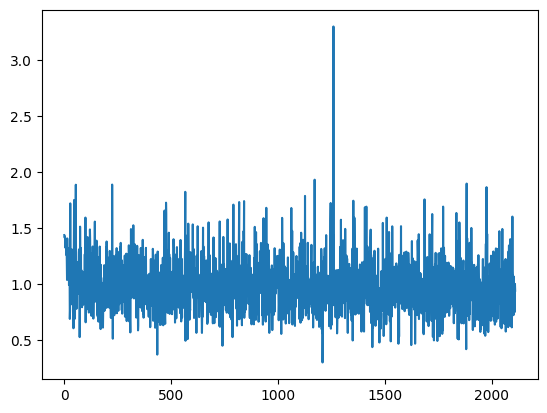

In [20]:
plt.plot(train_losses)

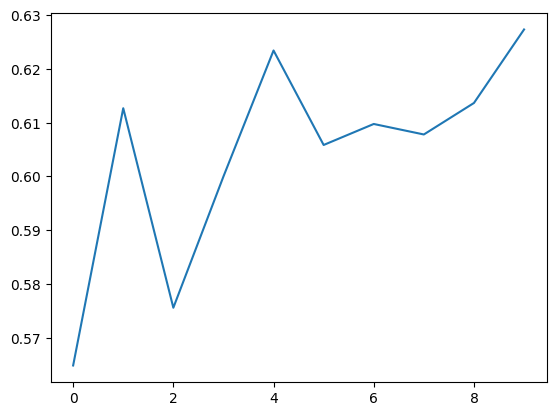

In [21]:
plt.plot(test_accuracy)

In [24]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [25]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 643/1024 (0.6279)
{'acc_detail': tensor([0.7068, 0.6711, 0.8151, 0.3245], device='cuda:0'),
 'acc_unweighted': tensor(0.6294, device='cuda:0'),
 'acc_weighted': tensor(0.6279, device='cuda:0'),
 'f1s': tensor(0.6168, device='cuda:0'),
 'f1s_detail': tensor([0.7287, 0.5615, 0.7798, 0.3972], device='cuda:0'),
 'precision_detail': tensor([0.7520, 0.4826, 0.7474, 0.5119], device='cuda:0'),
 'recall_detail': tensor([0.7068, 0.6711, 0.8151, 0.3245], device='cuda:0'),
 'rocauc': tensor([0.9219, 0.8240, 0.9306, 0.7354], device='cuda:0'),
 'uar': tensor(0.6294, device='cuda:0'),
 'wap': tensor(0.6287, device='cuda:0')}


tensor([[188,  25,   1,  52],
        [  3, 153,  48,  24],
        [  1,  42, 216,   6],
        [ 58,  97,  24,  86]], device='cuda:0')

In [26]:
model_path = '../models_cremad4/cremad_label4_m18_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [27]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m18_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.007272727272727273/50 [00:00<53:17, 63.95s/it]

Train Epoch: 11 [0/3387 (0%)]	Loss: 0.842046
Mem before-during-after: 30153216 2653544960 36574208


  0%|▌                                                                                                                                                                            | 0.14909090909090902/50 [00:11<1:12:12, 86.91s/it]

Train Epoch: 11 [640/3387 (19%)]	Loss: 0.729991
Mem before-during-after: 36462592 2658409984 36790272


  1%|█                                                                                                                                                                             | 0.2981818181818183/50 [00:23<1:04:12, 77.51s/it]

Train Epoch: 11 [1280/3387 (38%)]	Loss: 1.420991
Mem before-during-after: 36574208 2660160512 37366784


  1%|█▌                                                                                                                                                                           | 0.44000000000000106/50 [00:34<1:10:30, 85.37s/it]

Train Epoch: 11 [1920/3387 (57%)]	Loss: 1.077829
Mem before-during-after: 36574208 2649914880 36462592


  1%|██                                                                                                                                                                            | 0.5854545454545474/50 [00:46<1:11:41, 87.04s/it]

Train Epoch: 11 [2560/3387 (76%)]	Loss: 0.653531
Mem before-during-after: 37374976 2650947072 36470784


  1%|██▌                                                                                                                                                                           | 0.7309090909090938/50 [00:57<1:11:00, 86.47s/it]

Train Epoch: 11 [3200/3387 (95%)]	Loss: 0.754256
Mem before-during-after: 36462592 2657164288 36462592


  2%|███▌                                                                                                                                                                            | 1.0000000000000047/50 [01:12<42:08, 51.61s/it]


Test Epoch: 11	Accuracy: 647/1024 (63%)

saved model: ../models_cremad4/cremad_label4_m18_best_11epoch.pt


  2%|███▌                                                                                                                                                                             | 1.007272727272732/50 [01:13<47:49, 58.57s/it]

Train Epoch: 12 [0/3387 (0%)]	Loss: 1.034217
Mem before-during-after: 36458496 2659374592 36462592


  2%|████                                                                                                                                                                          | 1.1527272727272784/50 [01:24<1:01:27, 75.49s/it]

Train Epoch: 12 [640/3387 (19%)]	Loss: 0.606864
Mem before-during-after: 36574208 2660892672 37478400


  3%|████▌                                                                                                                                                                          | 1.294545454545461/50 [01:35<1:09:40, 85.84s/it]

Train Epoch: 12 [1280/3387 (38%)]	Loss: 0.479221
Mem before-during-after: 37478400 2652557824 36470784


  3%|█████                                                                                                                                                                         | 1.4400000000000075/50 [01:47<1:08:55, 85.17s/it]

Train Epoch: 12 [1920/3387 (57%)]	Loss: 0.874614
Mem before-during-after: 36462592 2658068480 37478400


  3%|█████▌                                                                                                                                                                        | 1.5890909090909175/50 [01:58<1:01:08, 75.77s/it]

Train Epoch: 12 [2560/3387 (76%)]	Loss: 0.744437
Mem before-during-after: 36574208 2660892672 37478400


  3%|██████                                                                                                                                                                         | 1.734545454545464/50 [02:09<1:01:05, 75.94s/it]

Train Epoch: 12 [3200/3387 (95%)]	Loss: 0.813700
Mem before-during-after: 36574208 2659988480 36574208


  4%|███████                                                                                                                                                                          | 2.000000000000011/50 [02:24<43:54, 54.89s/it]


Test Epoch: 12	Accuracy: 659/1024 (64%)

saved model: ../models_cremad4/cremad_label4_m18_best_12epoch.pt


  4%|███████                                                                                                                                                                          | 2.007272727272738/50 [02:25<47:26, 59.30s/it]

Train Epoch: 13 [0/3387 (0%)]	Loss: 0.637108
Mem before-during-after: 36969472 2659433984 36530176


  4%|███████▌                                                                                                                                                                       | 2.149090909090912/50 [02:36<1:09:13, 86.81s/it]

Train Epoch: 13 [640/3387 (19%)]	Loss: 1.064070
Mem before-during-after: 36470784 2629613568 37209600


  5%|███████▉                                                                                                                                                                      | 2.2945454545454496/50 [02:48<1:10:04, 88.13s/it]

Train Epoch: 13 [1280/3387 (38%)]	Loss: 0.815315
Mem before-during-after: 36470784 2650194432 36462592


  5%|████████▌                                                                                                                                                                     | 2.4436363636363505/50 [02:59<1:00:12, 75.96s/it]

Train Epoch: 13 [1920/3387 (57%)]	Loss: 0.851503
Mem before-during-after: 37478400 2659724288 37478400


  5%|████████▉                                                                                                                                                                     | 2.5854545454545246/50 [03:10<1:08:09, 86.24s/it]

Train Epoch: 13 [2560/3387 (76%)]	Loss: 0.803206
Mem before-during-after: 37478400 2659988480 37957632


  5%|█████████▌                                                                                                                                                                     | 2.730909090909062/50 [03:22<1:08:07, 86.47s/it]

Train Epoch: 13 [3200/3387 (95%)]	Loss: 0.712806
Mem before-during-after: 36470784 2658980864 37366784


  6%|██████████▌                                                                                                                                                                     | 2.9999999999999565/50 [03:37<39:46, 50.78s/it]


Test Epoch: 13	Accuracy: 655/1024 (64%)



  6%|██████████▌                                                                                                                                                                     | 3.0072727272726834/50 [03:37<44:12, 56.45s/it]

Train Epoch: 14 [0/3387 (0%)]	Loss: 0.806966
Mem before-during-after: 36466688 2651670528 36574208


  6%|██████████▉                                                                                                                                                                   | 3.1490909090908574/50 [03:48<1:06:28, 85.12s/it]

Train Epoch: 14 [640/3387 (19%)]	Loss: 0.682781
Mem before-during-after: 36470784 2660299264 37374976


  7%|███████████▌                                                                                                                                                                   | 3.294545454545395/50 [04:00<1:07:31, 86.74s/it]

Train Epoch: 14 [1280/3387 (38%)]	Loss: 1.210716
Mem before-during-after: 36900352 2659751936 36574208


  7%|████████████▏                                                                                                                                                                    | 3.443636363636296/50 [04:11<58:46, 75.74s/it]

Train Epoch: 14 [1920/3387 (57%)]	Loss: 0.782466
Mem before-during-after: 37957632 2660467712 36574208


  7%|████████████▌                                                                                                                                                                   | 3.58545454545447/50 [04:23<1:06:10, 85.55s/it]

Train Epoch: 14 [2560/3387 (76%)]	Loss: 0.743227
Mem before-during-after: 37478400 2659988480 37957632


  7%|████████████▉                                                                                                                                                                 | 3.7309090909090075/50 [04:34<1:06:07, 85.75s/it]

Train Epoch: 14 [3200/3387 (95%)]	Loss: 0.840493
Mem before-during-after: 36470784 2650194432 36462592


  8%|██████████████▏                                                                                                                                                                  | 3.999999999999902/50 [04:49<41:06, 53.61s/it]


Test Epoch: 14	Accuracy: 646/1024 (63%)



  8%|██████████████▏                                                                                                                                                                  | 4.007272727272629/50 [04:50<44:59, 58.68s/it]

Train Epoch: 15 [0/3387 (0%)]	Loss: 0.750913
Mem before-during-after: 36969472 2659433984 36530176


  8%|██████████████▌                                                                                                                                                                 | 4.1527272727271844/50 [05:01<57:45, 75.59s/it]

Train Epoch: 15 [640/3387 (19%)]	Loss: 0.885266
Mem before-during-after: 37957632 2660467712 36574208


  9%|███████████████                                                                                                                                                                | 4.294545454545376/50 [05:12<1:05:28, 85.95s/it]

Train Epoch: 15 [1280/3387 (38%)]	Loss: 0.786117
Mem before-during-after: 36574208 2651432448 36470784


  9%|███████████████▌                                                                                                                                                               | 4.439999999999931/50 [05:23<1:05:12, 85.87s/it]

Train Epoch: 15 [1920/3387 (57%)]	Loss: 0.942812
Mem before-during-after: 36574208 2631351296 36574208


  9%|████████████████▎                                                                                                                                                                 | 4.58909090909085/50 [05:35<58:18, 77.04s/it]

Train Epoch: 15 [2560/3387 (76%)]	Loss: 0.598441
Mem before-during-after: 37478400 2659084288 37478400


  9%|████████████████▋                                                                                                                                                               | 4.7345454545454055/50 [05:46<58:30, 77.55s/it]

Train Epoch: 15 [3200/3387 (95%)]	Loss: 0.961419
Mem before-during-after: 36919296 2424093696 36919296


 10%|█████████████████▋                                                                                                                                                               | 4.999999999999969/50 [06:01<39:17, 52.38s/it]


Test Epoch: 15	Accuracy: 635/1024 (62%)



 10%|█████████████████▋                                                                                                                                                               | 5.003636363636333/50 [06:01<44:55, 59.91s/it]

Train Epoch: 16 [0/3387 (0%)]	Loss: 1.368768
Mem before-during-after: 36969472 2659433984 36530176


 10%|██████████████████▏                                                                                                                                                              | 5.152727272727252/50 [06:13<57:10, 76.48s/it]

Train Epoch: 16 [640/3387 (19%)]	Loss: 0.663047
Mem before-during-after: 36470784 2658980864 36574208


 11%|██████████████████▌                                                                                                                                                            | 5.298181818181807/50 [06:25<1:03:08, 84.75s/it]

Train Epoch: 16 [1280/3387 (38%)]	Loss: 0.806644
Mem before-during-after: 37478400 2659988480 37957632


 11%|███████████████████                                                                                                                                                            | 5.439999999999999/50 [06:36<1:02:57, 84.77s/it]

Train Epoch: 16 [1920/3387 (57%)]	Loss: 0.632753
Mem before-during-after: 37478400 2652673536 36574208


 11%|███████████████████▊                                                                                                                                                             | 5.589090909090918/50 [06:47<56:03, 75.73s/it]

Train Epoch: 16 [2560/3387 (76%)]	Loss: 0.631528
Mem before-during-after: 36462592 2659876864 37957632


 11%|████████████████████                                                                                                                                                           | 5.730909090909109/50 [06:59<1:03:20, 85.85s/it]

Train Epoch: 16 [3200/3387 (95%)]	Loss: 1.231839
Mem before-during-after: 36462592 2658467328 36462592


 12%|█████████████████████▏                                                                                                                                                           | 6.000000000000036/50 [07:13<38:15, 52.16s/it]


Test Epoch: 16	Accuracy: 659/1024 (64%)



 12%|█████████████████████▍                                                                                                                                                             | 6.0036363636364/50 [07:14<44:45, 61.04s/it]

Train Epoch: 17 [0/3387 (0%)]	Loss: 0.786344
Mem before-during-after: 36857856 2659337728 36734976


 12%|█████████████████████▌                                                                                                                                                         | 6.149090909090956/50 [07:25<1:04:57, 88.89s/it]

Train Epoch: 17 [640/3387 (19%)]	Loss: 0.772987
Mem before-during-after: 36574208 2657411072 37478400


 13%|██████████████████████▎                                                                                                                                                          | 6.298181818181875/50 [07:37<55:50, 76.67s/it]

Train Epoch: 17 [1280/3387 (38%)]	Loss: 0.659227
Mem before-during-after: 37957632 2660467712 36574208


 13%|██████████████████████▌                                                                                                                                                        | 6.440000000000066/50 [07:48<1:01:45, 85.07s/it]

Train Epoch: 17 [1920/3387 (57%)]	Loss: 1.071904
Mem before-during-after: 36470784 2649927168 36900352


 13%|███████████████████████                                                                                                                                                        | 6.585454545454621/50 [08:00<1:01:35, 85.12s/it]

Train Epoch: 17 [2560/3387 (76%)]	Loss: 1.052615
Mem before-during-after: 36574208 2660892672 37478400


 13%|███████████████████████▋                                                                                                                                                        | 6.7345454545455405/50 [08:11<55:11, 76.53s/it]

Train Epoch: 17 [3200/3387 (95%)]	Loss: 0.742915
Mem before-during-after: 36462592 2658068480 36574208


 14%|████████████████████████▊                                                                                                                                                        | 7.000000000000104/50 [08:26<36:59, 51.61s/it]


Test Epoch: 17	Accuracy: 655/1024 (64%)



 14%|████████████████████████▊                                                                                                                                                        | 7.003636363636468/50 [08:26<43:21, 60.50s/it]

Train Epoch: 18 [0/3387 (0%)]	Loss: 0.959829
Mem before-during-after: 37873664 2660460032 36574208


 14%|█████████████████████████                                                                                                                                                      | 7.149090909091023/50 [08:38<1:00:50, 85.20s/it]

Train Epoch: 18 [640/3387 (19%)]	Loss: 0.975256
Mem before-during-after: 36574208 2651699712 37478400


 15%|█████████████████████████▌                                                                                                                                                     | 7.294545454545578/50 [08:49<1:01:16, 86.09s/it]

Train Epoch: 18 [1280/3387 (38%)]	Loss: 0.857037
Mem before-during-after: 36462592 2658203648 36574208


 15%|██████████████████████████                                                                                                                                                     | 7.440000000000134/50 [09:00<1:01:04, 86.09s/it]

Train Epoch: 18 [1920/3387 (57%)]	Loss: 0.574025
Mem before-during-after: 36574208 2659084288 37957632


 15%|██████████████████████████▌                                                                                                                                                    | 7.585454545454689/50 [09:12<1:02:20, 88.18s/it]

Train Epoch: 18 [2560/3387 (76%)]	Loss: 0.885710
Mem before-during-after: 37366784 2659308544 36462592


 15%|███████████████████████████                                                                                                                                                    | 7.730909090909244/50 [09:23<1:00:39, 86.11s/it]

Train Epoch: 18 [3200/3387 (95%)]	Loss: 0.922089
Mem before-during-after: 36462592 2658972672 36462592


 16%|████████████████████████████▍                                                                                                                                                     | 8.00000000000017/50 [09:38<35:39, 50.94s/it]


Test Epoch: 18	Accuracy: 653/1024 (64%)



 16%|████████████████████████████▎                                                                                                                                                    | 8.003636363636534/50 [09:38<41:37, 59.47s/it]

Train Epoch: 19 [0/3387 (0%)]	Loss: 0.877239
Mem before-during-after: 36458496 2650744320 36708352


 16%|████████████████████████████▋                                                                                                                                                   | 8.14909090909109/50 [09:50<1:00:03, 86.10s/it]

Train Epoch: 19 [640/3387 (19%)]	Loss: 0.930936
Mem before-during-after: 36574208 2659219456 36574208


 17%|█████████████████████████████▍                                                                                                                                                   | 8.298181818182009/50 [10:01<52:16, 75.21s/it]

Train Epoch: 19 [1280/3387 (38%)]	Loss: 0.852717
Mem before-during-after: 36470784 2658980864 36574208


 17%|██████████████████████████████▏                                                                                                                                                    | 8.4400000000002/50 [10:13<59:17, 85.60s/it]

Train Epoch: 19 [1920/3387 (57%)]	Loss: 1.199384
Mem before-during-after: 37478400 2650934784 36900352


 17%|██████████████████████████████                                                                                                                                                 | 8.585454545454756/50 [10:24<1:00:02, 86.98s/it]

Train Epoch: 19 [2560/3387 (76%)]	Loss: 0.812492
Mem before-during-after: 36470784 2658076672 37366784


 17%|███████████████████████████████                                                                                                                                                   | 8.73090909090931/50 [10:36<59:31, 86.53s/it]

Train Epoch: 19 [3200/3387 (95%)]	Loss: 0.966606
Mem before-during-after: 36462592 2650823168 36574208


 18%|███████████████████████████████▊                                                                                                                                                 | 9.000000000000238/50 [10:51<35:16, 51.62s/it]


Test Epoch: 19	Accuracy: 659/1024 (64%)



 18%|███████████████████████████████▉                                                                                                                                                 | 9.007272727272966/50 [10:51<40:35, 59.42s/it]

Train Epoch: 20 [0/3387 (0%)]	Loss: 0.499465
Mem before-during-after: 37474304 2659844608 36499456


 18%|████████████████████████████████▍                                                                                                                                                | 9.149090909091157/50 [11:02<59:21, 87.18s/it]

Train Epoch: 20 [640/3387 (19%)]	Loss: 1.259671
Mem before-during-after: 37478400 2652673536 36574208


 19%|████████████████████████████████▉                                                                                                                                                | 9.294545454545712/50 [11:14<58:30, 86.24s/it]

Train Epoch: 20 [1280/3387 (38%)]	Loss: 0.725390
Mem before-during-after: 36462592 2658548736 36462592


 19%|█████████████████████████████████▍                                                                                                                                               | 9.443636363636632/50 [11:25<51:13, 75.79s/it]

Train Epoch: 20 [1920/3387 (57%)]	Loss: 0.676763
Mem before-during-after: 36470784 2660861952 37374976


 19%|█████████████████████████████████▉                                                                                                                                               | 9.589090909091187/50 [11:37<51:23, 76.30s/it]

Train Epoch: 20 [2560/3387 (76%)]	Loss: 0.839690
Mem before-during-after: 37478400 2651699712 37478400


 19%|██████████████████████████████████▍                                                                                                                                              | 9.730909090909378/50 [11:48<56:16, 83.85s/it]

Train Epoch: 20 [3200/3387 (95%)]	Loss: 0.805642
Mem before-during-after: 36470784 2650044928 36470784


 20%|███████████████████████████████████▏                                                                                                                                            | 10.000000000000306/50 [12:03<33:59, 51.00s/it]


Test Epoch: 20	Accuracy: 649/1024 (63%)



 20%|███████████████████████████████████▏                                                                                                                                            | 10.007272727273033/50 [12:04<38:52, 58.33s/it]

Train Epoch: 21 [0/3387 (0%)]	Loss: 1.009374
Mem before-during-after: 36969472 2568719360 37192192


 20%|███████████████████████████████████▋                                                                                                                                            | 10.149090909091225/50 [12:15<58:58, 88.78s/it]

Train Epoch: 21 [640/3387 (19%)]	Loss: 1.041194
Mem before-during-after: 36462592 2651452928 36462592


 21%|████████████████████████████████████▍                                                                                                                                            | 10.29454545454578/50 [12:27<58:26, 88.33s/it]

Train Epoch: 21 [1280/3387 (38%)]	Loss: 0.658834
Mem before-during-after: 37924352 2659574784 37957632


 21%|████████████████████████████████████▋                                                                                                                                           | 10.440000000000335/50 [12:38<56:47, 86.14s/it]

Train Epoch: 21 [1920/3387 (57%)]	Loss: 0.528744
Mem before-during-after: 37478400 2659084288 37478400


 21%|█████████████████████████████████████▍                                                                                                                                           | 10.58545454545489/50 [12:50<56:41, 86.29s/it]

Train Epoch: 21 [2560/3387 (76%)]	Loss: 0.864265
Mem before-during-after: 37957632 2660467712 36574208


 21%|█████████████████████████████████████▊                                                                                                                                          | 10.730909090909446/50 [13:01<55:56, 85.47s/it]

Train Epoch: 21 [3200/3387 (95%)]	Loss: 1.185077
Mem before-during-after: 37478400 2659084288 37478400


 22%|██████████████████████████████████████▋                                                                                                                                         | 11.000000000000373/50 [13:16<32:43, 50.36s/it]


Test Epoch: 21	Accuracy: 659/1024 (64%)



 22%|██████████████████████████████████████▋                                                                                                                                         | 11.003636363636737/50 [13:16<37:58, 58.43s/it]

Train Epoch: 22 [0/3387 (0%)]	Loss: 0.651985
Mem before-during-after: 36969472 2661262336 36499456


 22%|███████████████████████████████████████▏                                                                                                                                        | 11.149090909091292/50 [13:28<55:42, 86.04s/it]

Train Epoch: 22 [640/3387 (19%)]	Loss: 0.735551
Mem before-during-after: 36574208 2659988480 36574208


 23%|███████████████████████████████████████▊                                                                                                                                        | 11.294545454545847/50 [13:39<56:50, 88.12s/it]

Train Epoch: 22 [1280/3387 (38%)]	Loss: 0.749283
Mem before-during-after: 37366784 2650267136 36462592


 23%|████████████████████████████████████████▎                                                                                                                                       | 11.440000000000403/50 [13:51<55:07, 85.77s/it]

Train Epoch: 22 [1920/3387 (57%)]	Loss: 0.728230
Mem before-during-after: 37478400 2659084288 37478400


 23%|████████████████████████████████████████▊                                                                                                                                       | 11.585454545454958/50 [14:02<54:25, 85.00s/it]

Train Epoch: 22 [2560/3387 (76%)]	Loss: 0.934488
Mem before-during-after: 36462592 2650504704 36574208


 23%|█████████████████████████████████████████▎                                                                                                                                      | 11.730909090909513/50 [14:14<54:58, 86.19s/it]

Train Epoch: 22 [3200/3387 (95%)]	Loss: 0.945482
Mem before-during-after: 37478400 2659084288 37478400


 24%|██████████████████████████████████████████▍                                                                                                                                      | 12.00000000000044/50 [14:29<33:11, 52.42s/it]


Test Epoch: 22	Accuracy: 670/1024 (65%)

saved model: ../models_cremad4/cremad_label4_m18_best_22epoch.pt


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.003636363636804/50 [14:29<38:08, 60.23s/it]

Train Epoch: 23 [0/3387 (0%)]	Loss: 0.925642
Mem before-during-after: 36969472 2651513344 37835776


 24%|███████████████████████████████████████████                                                                                                                                      | 12.14909090909136/50 [14:41<54:44, 86.78s/it]

Train Epoch: 23 [640/3387 (19%)]	Loss: 0.982381
Mem before-during-after: 36462592 2658068480 36462592


 25%|███████████████████████████████████████████▎                                                                                                                                    | 12.298181818182279/50 [14:52<48:10, 76.68s/it]

Train Epoch: 23 [1280/3387 (38%)]	Loss: 0.610271
Mem before-during-after: 37478400 2651050496 36470784


 25%|████████████████████████████████████████████                                                                                                                                     | 12.44000000000047/50 [15:04<53:51, 86.02s/it]

Train Epoch: 23 [1920/3387 (57%)]	Loss: 1.003440
Mem before-during-after: 36574208 2660123648 37366784


 25%|████████████████████████████████████████████▌                                                                                                                                    | 12.58909090909139/50 [15:15<47:07, 75.57s/it]

Train Epoch: 23 [2560/3387 (76%)]	Loss: 0.920067
Mem before-during-after: 38016000 2650568192 36900352


 25%|█████████████████████████████████████████████                                                                                                                                    | 12.73090909090958/50 [15:26<53:53, 86.75s/it]

Train Epoch: 23 [3200/3387 (95%)]	Loss: 0.537524
Mem before-during-after: 37478400 2650934784 36900352


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.000000000000508/50 [15:41<37:24, 60.66s/it]


Test Epoch: 23	Accuracy: 666/1024 (65%)



 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.007272727273236/50 [15:42<38:36, 62.61s/it]

Train Epoch: 24 [0/3387 (0%)]	Loss: 1.204681
Mem before-during-after: 36458496 2658418176 36499456


 26%|██████████████████████████████████████████████▎                                                                                                                                 | 13.149090909091427/50 [15:53<53:00, 86.30s/it]

Train Epoch: 24 [640/3387 (19%)]	Loss: 1.066226
Mem before-during-after: 36574208 2661593600 37478400


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 13.294545454545982/50 [16:04<52:10, 85.29s/it]

Train Epoch: 24 [1280/3387 (38%)]	Loss: 0.807798
Mem before-during-after: 36574208 2661593600 37478400


 27%|███████████████████████████████████████████████▎                                                                                                                                | 13.440000000000538/50 [16:16<52:01, 85.37s/it]

Train Epoch: 24 [1920/3387 (57%)]	Loss: 0.683578
Mem before-during-after: 37478400 2661593600 37478400


 27%|███████████████████████████████████████████████▊                                                                                                                                | 13.585454545455093/50 [16:27<51:47, 85.35s/it]

Train Epoch: 24 [2560/3387 (76%)]	Loss: 0.868192
Mem before-during-after: 37478400 2651050496 36470784


 27%|████████████████████████████████████████████████▎                                                                                                                               | 13.734545454546012/50 [16:39<45:49, 75.82s/it]

Train Epoch: 24 [3200/3387 (95%)]	Loss: 0.834365
Mem before-during-after: 37105664 2514329600 36462592


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.000000000000576/50 [16:54<31:44, 52.89s/it]


Test Epoch: 24	Accuracy: 671/1024 (65%)

saved model: ../models_cremad4/cremad_label4_m18_best_24epoch.pt


 28%|█████████████████████████████████████████████████▌                                                                                                                               | 14.00363636363694/50 [16:54<36:15, 60.43s/it]

Train Epoch: 25 [0/3387 (0%)]	Loss: 0.884097
Mem before-during-after: 36753408 2651957248 36574208


 28%|█████████████████████████████████████████████████▊                                                                                                                              | 14.149090909091495/50 [17:06<51:47, 86.67s/it]

Train Epoch: 25 [640/3387 (19%)]	Loss: 0.720331
Mem before-during-after: 36574208 2659988480 36574208


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 14.29454545454605/50 [17:17<52:19, 87.92s/it]

Train Epoch: 25 [1280/3387 (38%)]	Loss: 0.606207
Mem before-during-after: 36470784 2650042880 36470784


 29%|███████████████████████████████████████████████████▏                                                                                                                             | 14.44363636363697/50 [17:29<45:57, 77.55s/it]

Train Epoch: 25 [1920/3387 (57%)]	Loss: 0.791124
Mem before-during-after: 37478400 2660892672 37478400


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 14.58545454545516/50 [17:40<50:45, 86.01s/it]

Train Epoch: 25 [2560/3387 (76%)]	Loss: 0.793952
Mem before-during-after: 36462592 2658068480 37478400


 29%|███████████████████████████████████████████████████▊                                                                                                                            | 14.730909090909716/50 [17:51<49:56, 84.96s/it]

Train Epoch: 25 [3200/3387 (95%)]	Loss: 0.557694
Mem before-during-after: 36462592 2650034688 36462592


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.000000000000643/50 [18:07<30:47, 52.80s/it]


Test Epoch: 25	Accuracy: 654/1024 (64%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.003636363637007/50 [18:07<35:33, 60.96s/it]

Train Epoch: 26 [0/3387 (0%)]	Loss: 0.764541
Mem before-during-after: 36458496 2659374592 36825088


 30%|█████████████████████████████████████████████████████▎                                                                                                                          | 15.152727272727926/50 [18:18<45:59, 79.20s/it]

Train Epoch: 26 [640/3387 (19%)]	Loss: 0.611410
Mem before-during-after: 36462592 2659110912 37053440


 31%|█████████████████████████████████████████████████████▊                                                                                                                          | 15.294545454546117/50 [18:30<49:34, 85.70s/it]

Train Epoch: 26 [1280/3387 (38%)]	Loss: 0.800484
Mem before-during-after: 36574208 2650934784 36462592


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.440000000000673/50 [18:41<49:50, 86.53s/it]

Train Epoch: 26 [1920/3387 (57%)]	Loss: 0.702262
Mem before-during-after: 36574208 2660689408 36574208


 31%|██████████████████████████████████████████████████████▊                                                                                                                         | 15.585454545455228/50 [18:53<48:52, 85.21s/it]

Train Epoch: 26 [2560/3387 (76%)]	Loss: 0.704017
Mem before-during-after: 36574208 2651548160 36574208


 31%|███████████████████████████████████████████████████████▎                                                                                                                        | 15.730909090909783/50 [19:04<49:30, 86.67s/it]

Train Epoch: 26 [3200/3387 (95%)]	Loss: 0.712855
Mem before-during-after: 36574208 2660892672 37478400


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 16.00000000000071/50 [19:19<29:08, 51.43s/it]


Test Epoch: 26	Accuracy: 672/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m18_best_26epoch.pt


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 16.00727272727344/50 [19:20<32:42, 57.72s/it]

Train Epoch: 27 [0/3387 (0%)]	Loss: 1.008695
Mem before-during-after: 36857856 2659008512 36462592


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 16.14909090909163/50 [19:31<48:24, 85.80s/it]

Train Epoch: 27 [640/3387 (19%)]	Loss: 1.144141
Mem before-during-after: 37765120 2650353152 36574208


 33%|█████████████████████████████████████████████████████████▎                                                                                                                      | 16.294545454546185/50 [19:43<48:14, 85.87s/it]

Train Epoch: 27 [1280/3387 (38%)]	Loss: 0.789008
Mem before-during-after: 37478400 2659988480 37957632


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 16.44000000000074/50 [19:54<47:59, 85.82s/it]

Train Epoch: 27 [1920/3387 (57%)]	Loss: 0.764269
Mem before-during-after: 38016000 2658717696 37478400


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 16.585454545455296/50 [20:05<48:03, 86.30s/it]

Train Epoch: 27 [2560/3387 (76%)]	Loss: 0.684556
Mem before-during-after: 36470784 2658490880 36470784


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 16.73090909090985/50 [20:17<48:23, 87.28s/it]

Train Epoch: 27 [3200/3387 (95%)]	Loss: 0.714504
Mem before-during-after: 36574208 2649914880 36462592


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.000000000000778/50 [20:32<28:38, 52.06s/it]


Test Epoch: 27	Accuracy: 664/1024 (65%)



 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.007272727273506/50 [20:32<32:20, 58.83s/it]

Train Epoch: 28 [0/3387 (0%)]	Loss: 0.800203
Mem before-during-after: 36458496 2651151360 37328896


 34%|████████████████████████████████████████████████████████████▎                                                                                                                   | 17.149090909091697/50 [20:43<47:04, 85.97s/it]

Train Epoch: 28 [640/3387 (19%)]	Loss: 0.932748
Mem before-during-after: 36462592 2658068480 36462592


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 17.298181818182616/50 [20:55<44:03, 80.84s/it]

Train Epoch: 28 [1280/3387 (38%)]	Loss: 0.719599
Mem before-during-after: 37478400 2659084288 37105664


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                  | 17.440000000000808/50 [21:06<47:38, 87.80s/it]

Train Epoch: 28 [1920/3387 (57%)]	Loss: 0.643510
Mem before-during-after: 37105664 2660736512 36574208


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 17.585454545455363/50 [21:18<46:49, 86.66s/it]

Train Epoch: 28 [2560/3387 (76%)]	Loss: 0.770722
Mem before-during-after: 36574208 2661593600 37478400


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                 | 17.734545454546282/50 [21:30<41:05, 76.40s/it]

Train Epoch: 28 [3200/3387 (95%)]	Loss: 0.769701
Mem before-during-after: 36462592 2484980736 36750848


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 18.000000000000846/50 [21:44<27:12, 51.02s/it]


Test Epoch: 28	Accuracy: 662/1024 (65%)



 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 18.00363636363721/50 [21:44<32:02, 60.07s/it]

Train Epoch: 29 [0/3387 (0%)]	Loss: 0.820394
Mem before-during-after: 36969472 2659433984 36530176


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 18.15272727272813/50 [21:56<40:57, 77.17s/it]

Train Epoch: 29 [640/3387 (19%)]	Loss: 0.682157
Mem before-during-after: 37478400 2659785216 37478400


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 18.29454545454632/50 [22:08<45:11, 85.51s/it]

Train Epoch: 29 [1280/3387 (38%)]	Loss: 1.081208
Mem before-during-after: 36574208 2659084288 36574208


 37%|████████████████████████████████████████████████████████████████▉                                                                                                               | 18.440000000000875/50 [22:19<45:28, 86.46s/it]

Train Epoch: 29 [1920/3387 (57%)]	Loss: 0.997844
Mem before-during-after: 36913152 2657793024 37478400


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 18.58545454545543/50 [22:30<45:07, 86.19s/it]

Train Epoch: 29 [2560/3387 (76%)]	Loss: 1.316919
Mem before-during-after: 36574208 2661593600 37478400


 37%|██████████████████████████████████████████████████████████████████▎                                                                                                              | 18.73454545454635/50 [22:42<40:14, 77.22s/it]

Train Epoch: 29 [3200/3387 (95%)]	Loss: 0.842035
Mem before-during-after: 36470784 2658980864 36574208


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.000000000000913/50 [22:57<25:55, 50.18s/it]


Test Epoch: 29	Accuracy: 679/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m18_best_29epoch.pt


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00727272727364/50 [22:57<30:03, 58.19s/it]

Train Epoch: 30 [0/3387 (0%)]	Loss: 1.183176
Mem before-during-after: 36857856 2426796544 36470784


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                            | 19.149090909091832/50 [23:08<43:57, 85.48s/it]

Train Epoch: 30 [640/3387 (19%)]	Loss: 0.776926
Mem before-during-after: 37478400 2651699712 37478400


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 19.294545454546387/50 [23:20<44:14, 86.44s/it]

Train Epoch: 30 [1280/3387 (38%)]	Loss: 0.765381
Mem before-during-after: 36462592 2658516480 36574208


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                           | 19.443636363637307/50 [23:32<40:47, 80.10s/it]

Train Epoch: 30 [1920/3387 (57%)]	Loss: 0.869797
Mem before-during-after: 36462592 2658769408 37105664


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 19.589090909091862/50 [23:43<38:07, 75.22s/it]

Train Epoch: 30 [2560/3387 (76%)]	Loss: 0.874403
Mem before-during-after: 36462592 2659587584 37321728


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                          | 19.730909090910053/50 [23:54<45:17, 89.79s/it]

Train Epoch: 30 [3200/3387 (95%)]	Loss: 0.823226
Mem before-during-after: 37957632 2660467712 36574208


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00000000000098/50 [24:10<26:36, 53.23s/it]


Test Epoch: 30	Accuracy: 668/1024 (65%)



 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00727272727371/50 [24:10<29:28, 58.96s/it]

Train Epoch: 31 [0/3387 (0%)]	Loss: 0.944992
Mem before-during-after: 36857856 2659008512 36462592


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                          | 20.1490909090919/50 [24:22<43:30, 87.45s/it]

Train Epoch: 31 [640/3387 (19%)]	Loss: 0.910411
Mem before-during-after: 36574208 2660892672 37478400


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 20.294545454546455/50 [24:33<42:23, 85.61s/it]

Train Epoch: 31 [1280/3387 (38%)]	Loss: 1.071736
Mem before-during-after: 37478400 2659420160 37478400


 41%|███████████████████████████████████████████████████████████████████████▉                                                                                                        | 20.443636363637374/50 [24:45<37:43, 76.59s/it]

Train Epoch: 31 [1920/3387 (57%)]	Loss: 0.970171
Mem before-during-after: 37478400 2651548160 37071872


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                        | 20.58909090909193/50 [24:56<38:08, 77.80s/it]

Train Epoch: 31 [2560/3387 (76%)]	Loss: 0.738257
Mem before-during-after: 37366784 2658620416 36462592


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 20.73090909091012/50 [25:08<42:01, 86.15s/it]

Train Epoch: 31 [3200/3387 (95%)]	Loss: 0.898297
Mem before-during-after: 36462592 2650034688 36462592


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.000000000001048/50 [25:23<25:33, 52.89s/it]


Test Epoch: 31	Accuracy: 672/1024 (66%)



 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.007272727273776/50 [25:23<28:33, 59.11s/it]

Train Epoch: 32 [0/3387 (0%)]	Loss: 0.735293
Mem before-during-after: 36969472 2651513344 37835776


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                     | 21.149090909091967/50 [25:35<40:55, 85.11s/it]

Train Epoch: 32 [640/3387 (19%)]	Loss: 0.875242
Mem before-during-after: 37127168 2651371008 36900352


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.294545454546522/50 [25:46<40:52, 85.45s/it]

Train Epoch: 32 [1280/3387 (38%)]	Loss: 0.850977
Mem before-during-after: 36470784 2659754496 36470784


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 21.440000000001078/50 [25:58<40:37, 85.36s/it]

Train Epoch: 32 [1920/3387 (57%)]	Loss: 1.232676
Mem before-during-after: 36574208 2659084288 36574208


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                    | 21.589090909091997/50 [26:09<35:55, 75.86s/it]

Train Epoch: 32 [2560/3387 (76%)]	Loss: 0.521293
Mem before-during-after: 37478400 2660892672 37478400


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 21.73090909091019/50 [26:20<39:56, 84.76s/it]

Train Epoch: 32 [3200/3387 (95%)]	Loss: 0.676621
Mem before-during-after: 37366784 2456797184 37134848


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.000000000001116/50 [26:35<23:51, 51.12s/it]


Test Epoch: 32	Accuracy: 674/1024 (66%)



 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.00363636363748/50 [26:36<28:01, 60.06s/it]

Train Epoch: 33 [0/3387 (0%)]	Loss: 0.979175
Mem before-during-after: 36915200 2652322816 36919296


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 22.1527272727284/50 [26:47<35:49, 77.17s/it]

Train Epoch: 33 [640/3387 (19%)]	Loss: 0.647620
Mem before-during-after: 36574208 2661593600 37478400


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 22.29454545454659/50 [26:58<39:13, 84.95s/it]

Train Epoch: 33 [1280/3387 (38%)]	Loss: 0.718450
Mem before-during-after: 36574208 2650629120 36574208


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.440000000001145/50 [27:10<39:09, 85.25s/it]

Train Epoch: 33 [1920/3387 (57%)]	Loss: 0.980692
Mem before-during-after: 36462592 2650707456 36462592


 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 22.589090909092064/50 [27:21<35:11, 77.03s/it]

Train Epoch: 33 [2560/3387 (76%)]	Loss: 0.849016
Mem before-during-after: 36462592 2659761664 36462592


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                | 22.730909090910256/50 [27:32<38:24, 84.49s/it]

Train Epoch: 33 [3200/3387 (95%)]	Loss: 0.520997
Mem before-during-after: 36470784 2650750464 36470784


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.000000000001183/50 [27:47<23:30, 52.22s/it]


Test Epoch: 33	Accuracy: 679/1024 (66%)



 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.003636363637547/50 [27:48<27:27, 61.04s/it]

Train Epoch: 34 [0/3387 (0%)]	Loss: 0.831039
Mem before-during-after: 36969472 2659433984 36530176


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 23.149090909092102/50 [27:59<38:23, 85.78s/it]

Train Epoch: 34 [640/3387 (19%)]	Loss: 1.376289
Mem before-during-after: 37957632 2660467712 36574208


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 23.294545454546657/50 [28:10<37:47, 84.89s/it]

Train Epoch: 34 [1280/3387 (38%)]	Loss: 1.282800
Mem before-during-after: 36462592 2649803264 36470784


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 23.440000000001213/50 [28:22<37:53, 85.59s/it]

Train Epoch: 34 [1920/3387 (57%)]	Loss: 0.697064
Mem before-during-after: 36462592 2649918976 36900352


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                             | 23.585454545455768/50 [28:33<37:34, 85.36s/it]

Train Epoch: 34 [2560/3387 (76%)]	Loss: 0.894152
Mem before-during-after: 36574208 2660892672 37478400


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 23.730909090910323/50 [28:45<37:34, 85.81s/it]

Train Epoch: 34 [3200/3387 (95%)]	Loss: 0.883400
Mem before-during-after: 36499456 2659009536 36574208


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24.00000000000125/50 [29:00<22:05, 50.97s/it]


Test Epoch: 34	Accuracy: 679/1024 (66%)



 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 24.003636363637614/50 [29:00<25:54, 59.81s/it]

Train Epoch: 35 [0/3387 (0%)]	Loss: 0.817880
Mem before-during-after: 36969472 2651513344 37835776


 48%|█████████████████████████████████████████████████████████████████████████████████████                                                                                           | 24.152727272728534/50 [29:12<33:06, 76.87s/it]

Train Epoch: 35 [640/3387 (19%)]	Loss: 0.491221
Mem before-during-after: 36470784 2659957760 37374976


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.294545454546725/50 [29:23<36:45, 85.81s/it]

Train Epoch: 35 [1280/3387 (38%)]	Loss: 0.825016
Mem before-during-after: 36574208 2660892672 37478400


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                          | 24.443636363637644/50 [29:34<32:33, 76.45s/it]

Train Epoch: 35 [1920/3387 (57%)]	Loss: 1.082614
Mem before-during-after: 37765120 2650468864 36462592


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.5890909090922/50 [29:46<32:17, 76.25s/it]

Train Epoch: 35 [2560/3387 (76%)]	Loss: 0.793532
Mem before-during-after: 36574208 2659084288 37957632


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24.73090909091039/50 [29:57<36:05, 85.69s/it]

Train Epoch: 35 [3200/3387 (95%)]	Loss: 0.897194
Mem before-during-after: 36574208 2660892672 37478400


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.000000000001318/50 [30:12<21:41, 52.07s/it]


Test Epoch: 35	Accuracy: 680/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m18_best_35epoch.pt


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.003636363637682/50 [30:12<25:17, 60.72s/it]

Train Epoch: 36 [0/3387 (0%)]	Loss: 0.805978
Mem before-during-after: 36969472 2659433984 36530176


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 25.149090909092237/50 [30:24<35:13, 85.03s/it]

Train Epoch: 36 [640/3387 (19%)]	Loss: 1.058064
Mem before-during-after: 36470784 2651464704 36470784


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.298181818183156/50 [30:35<31:49, 77.29s/it]

Train Epoch: 36 [1280/3387 (38%)]	Loss: 0.494762
Mem before-during-after: 37478400 2659988480 37957632


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 25.440000000001348/50 [30:46<35:13, 86.07s/it]

Train Epoch: 36 [1920/3387 (57%)]	Loss: 0.779343
Mem before-during-after: 37478400 2659988480 37957632


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.589090909092267/50 [30:58<31:16, 76.89s/it]

Train Epoch: 36 [2560/3387 (76%)]	Loss: 0.930174
Mem before-during-after: 37478400 2660892672 37478400


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 25.734545454546822/50 [31:09<30:17, 74.89s/it]

Train Epoch: 36 [3200/3387 (95%)]	Loss: 0.910468
Mem before-during-after: 36574208 2485331456 36659200


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.000000000001386/50 [31:24<20:53, 52.22s/it]


Test Epoch: 36	Accuracy: 656/1024 (64%)



 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.007272727274113/50 [31:25<23:22, 58.47s/it]

Train Epoch: 37 [0/3387 (0%)]	Loss: 0.610481
Mem before-during-after: 36969472 2659433984 36530176


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 26.149090909092305/50 [31:36<34:31, 86.83s/it]

Train Epoch: 37 [640/3387 (19%)]	Loss: 0.567296
Mem before-during-after: 37478400 2660892672 37478400


 53%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 26.298181818183224/50 [31:48<31:41, 80.21s/it]

Train Epoch: 37 [1280/3387 (38%)]	Loss: 0.738743
Mem before-during-after: 36574208 2660892672 37478400


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 26.440000000001415/50 [31:59<34:11, 87.10s/it]

Train Epoch: 37 [1920/3387 (57%)]	Loss: 1.077294
Mem before-during-after: 36470784 2658980864 36462592


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 26.58545454545597/50 [32:10<33:31, 85.89s/it]

Train Epoch: 37 [2560/3387 (76%)]	Loss: 1.022441
Mem before-during-after: 36860928 2603385856 36861952


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 26.73454545454689/50 [32:22<29:34, 76.28s/it]

Train Epoch: 37 [3200/3387 (95%)]	Loss: 0.583572
Mem before-during-after: 36470784 2658149376 36470784


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.000000000001453/50 [32:36<19:59, 52.14s/it]


Test Epoch: 37	Accuracy: 659/1024 (64%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.003636363637817/50 [32:37<23:46, 62.03s/it]

Train Epoch: 38 [0/3387 (0%)]	Loss: 1.130528
Mem before-during-after: 36969472 2651513344 37835776


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.149090909092372/50 [32:48<33:06, 86.93s/it]

Train Epoch: 38 [640/3387 (19%)]	Loss: 1.007950
Mem before-during-after: 36574208 2651468288 36470784


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 27.29818181818329/50 [33:00<28:29, 75.32s/it]

Train Epoch: 38 [1280/3387 (38%)]	Loss: 0.647903
Mem before-during-after: 36574208 2660123648 38009856


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 27.443636363637847/50 [33:11<28:39, 76.25s/it]

Train Epoch: 38 [1920/3387 (57%)]	Loss: 0.641141
Mem before-during-after: 37478400 2659785216 37105664


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 27.589090909092402/50 [33:23<28:36, 76.59s/it]

Train Epoch: 38 [2560/3387 (76%)]	Loss: 0.693382
Mem before-during-after: 37478400 2651699712 37478400


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 27.734545454546957/50 [33:34<29:01, 78.20s/it]

Train Epoch: 38 [3200/3387 (95%)]	Loss: 0.838066
Mem before-during-after: 37105664 2659817472 36574208


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 28.00000000000152/50 [33:49<18:45, 51.18s/it]


Test Epoch: 38	Accuracy: 669/1024 (65%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00727272727425/50 [33:49<21:24, 58.39s/it]

Train Epoch: 39 [0/3387 (0%)]	Loss: 0.889925
Mem before-during-after: 37101568 2659980800 36499456


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 28.14909090909244/50 [34:01<31:08, 85.51s/it]

Train Epoch: 39 [640/3387 (19%)]	Loss: 0.919062
Mem before-during-after: 37478400 2630440960 36574208


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.294545454546995/50 [34:12<30:51, 85.31s/it]

Train Epoch: 39 [1280/3387 (38%)]	Loss: 1.050418
Mem before-during-after: 37957632 2567725568 37341696


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 28.44000000000155/50 [34:23<30:41, 85.44s/it]

Train Epoch: 39 [1920/3387 (57%)]	Loss: 0.894124
Mem before-during-after: 36574208 2659219456 36574208


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 28.585454545456106/50 [34:35<31:06, 87.15s/it]

Train Epoch: 39 [2560/3387 (76%)]	Loss: 0.817404
Mem before-during-after: 36574208 2660123648 37366784


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28.73090909091066/50 [34:46<30:49, 86.97s/it]

Train Epoch: 39 [3200/3387 (95%)]	Loss: 0.784866
Mem before-during-after: 37478400 2660891136 37478400


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 29.000000000001588/50 [35:01<18:02, 51.56s/it]


Test Epoch: 39	Accuracy: 680/1024 (66%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 29.007272727274316/50 [35:02<20:33, 58.76s/it]

Train Epoch: 40 [0/3387 (0%)]	Loss: 1.094646
Mem before-during-after: 36969472 2536519168 36642816


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 29.149090909092507/50 [35:13<29:37, 85.27s/it]

Train Epoch: 40 [640/3387 (19%)]	Loss: 0.681204
Mem before-during-after: 37711872 2659988480 37366784


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 29.294545454547062/50 [35:25<30:06, 87.26s/it]

Train Epoch: 40 [1280/3387 (38%)]	Loss: 0.890990
Mem before-during-after: 36462592 2657393664 36462592


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 29.440000000001618/50 [35:36<29:12, 85.22s/it]

Train Epoch: 40 [1920/3387 (57%)]	Loss: 0.543507
Mem before-during-after: 37105664 2660518400 36574208


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.589090909092537/50 [35:47<25:32, 75.06s/it]

Train Epoch: 40 [2560/3387 (76%)]	Loss: 0.654313
Mem before-during-after: 36470784 2535126528 37500928


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.73090909091073/50 [35:59<28:46, 85.19s/it]

Train Epoch: 40 [3200/3387 (95%)]	Loss: 0.697089
Mem before-during-after: 36574208 2651432448 36470784


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 30.000000000001656/50 [36:14<17:39, 52.97s/it]


Test Epoch: 40	Accuracy: 669/1024 (65%)



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.007272727274383/50 [36:14<19:35, 58.82s/it]

Train Epoch: 41 [0/3387 (0%)]	Loss: 0.885475
Mem before-during-after: 36458496 2658794496 37474304


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 30.149090909092575/50 [36:25<28:05, 84.93s/it]

Train Epoch: 41 [640/3387 (19%)]	Loss: 0.693588
Mem before-during-after: 36574208 2650629120 36462592


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 30.298181818183494/50 [36:37<25:05, 76.43s/it]

Train Epoch: 41 [1280/3387 (38%)]	Loss: 0.553614
Mem before-during-after: 37478400 2659988480 37957632


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30.440000000001685/50 [36:48<28:05, 86.15s/it]

Train Epoch: 41 [1920/3387 (57%)]	Loss: 1.022956
Mem before-during-after: 36470784 2658149376 36470784


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 30.58545454545624/50 [37:00<27:47, 85.88s/it]

Train Epoch: 41 [2560/3387 (76%)]	Loss: 1.286707
Mem before-during-after: 37478400 2659084288 37478400


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 30.730909090910796/50 [37:11<28:00, 87.20s/it]

Train Epoch: 41 [3200/3387 (95%)]	Loss: 0.872870
Mem before-during-after: 36462592 2659452928 37366784


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 31.000000000001723/50 [37:26<16:53, 53.36s/it]


Test Epoch: 41	Accuracy: 678/1024 (66%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 31.00727272727445/50 [37:27<18:45, 59.26s/it]

Train Epoch: 42 [0/3387 (0%)]	Loss: 1.037405
Mem before-during-after: 36969472 2650609152 36973568


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 31.149090909092642/50 [37:38<26:37, 84.73s/it]

Train Epoch: 42 [640/3387 (19%)]	Loss: 0.624230
Mem before-during-after: 37478400 2604606464 36574208


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 31.294545454547197/50 [37:49<26:40, 85.57s/it]

Train Epoch: 42 [1280/3387 (38%)]	Loss: 0.692461
Mem before-during-after: 36919296 2651257344 36574208


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31.443636363638117/50 [38:01<23:38, 76.45s/it]

Train Epoch: 42 [1920/3387 (57%)]	Loss: 0.905647
Mem before-during-after: 38016000 2629645312 37336064


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 31.585454545456308/50 [38:12<26:04, 84.95s/it]

Train Epoch: 42 [2560/3387 (76%)]	Loss: 1.242847
Mem before-during-after: 37374976 2650194432 36462592


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 31.730909090910863/50 [38:23<26:11, 86.01s/it]

Train Epoch: 42 [3200/3387 (95%)]	Loss: 1.015868
Mem before-during-after: 37957632 2660467712 36574208


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00000000000179/50 [38:38<15:59, 53.33s/it]


Test Epoch: 42	Accuracy: 678/1024 (66%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00727272727451/50 [38:39<17:36, 58.73s/it]

Train Epoch: 43 [0/3387 (0%)]	Loss: 0.961416
Mem before-during-after: 37474304 2568875520 36462592


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 32.152727272728924/50 [38:50<22:36, 76.03s/it]

Train Epoch: 43 [640/3387 (19%)]	Loss: 0.690323
Mem before-during-after: 36470784 2658980864 36574208


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.29454545454698/50 [39:01<25:20, 85.88s/it]

Train Epoch: 43 [1280/3387 (38%)]	Loss: 0.685534
Mem before-during-after: 37765120 2660275200 38009856


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32.44000000000139/50 [39:13<24:52, 85.00s/it]

Train Epoch: 43 [1920/3387 (57%)]	Loss: 1.173480
Mem before-during-after: 37411328 2651204608 36462592


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 32.585454545455804/50 [39:25<24:59, 86.12s/it]

Train Epoch: 43 [2560/3387 (76%)]	Loss: 0.751513
Mem before-during-after: 37957632 2651750912 36574208


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 32.73090909091022/50 [39:36<26:32, 92.23s/it]

Train Epoch: 43 [3200/3387 (95%)]	Loss: 0.730801
Mem before-during-after: 37957632 2660467712 36574208


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00000000000088/50 [39:51<14:40, 51.77s/it]


Test Epoch: 43	Accuracy: 681/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m18_best_43epoch.pt


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 33.0072727272736/50 [39:52<16:29, 58.23s/it]

Train Epoch: 44 [0/3387 (0%)]	Loss: 0.870311
Mem before-during-after: 36458496 2658418176 36499456


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 33.149090909091655/50 [40:03<23:51, 84.92s/it]

Train Epoch: 44 [640/3387 (19%)]	Loss: 0.989068
Mem before-during-after: 37478400 2651050496 36470784


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 33.29818181818243/50 [40:14<21:23, 76.82s/it]

Train Epoch: 44 [1280/3387 (38%)]	Loss: 0.767785
Mem before-during-after: 37374976 2603877888 36546560


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 33.44000000000048/50 [40:26<24:27, 88.62s/it]

Train Epoch: 44 [1920/3387 (57%)]	Loss: 0.491415
Mem before-during-after: 37478400 2659084288 37105664


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 33.585454545454894/50 [40:38<23:43, 86.69s/it]

Train Epoch: 44 [2560/3387 (76%)]	Loss: 0.994871
Mem before-during-after: 36574208 2660892672 37478400


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 33.73090909090931/50 [40:49<23:44, 87.56s/it]

Train Epoch: 44 [3200/3387 (95%)]	Loss: 0.588409
Mem before-during-after: 36574208 2659219456 36574208


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 33.99999999999997/50 [41:04<13:32, 50.77s/it]


Test Epoch: 44	Accuracy: 687/1024 (67%)

saved model: ../models_cremad4/cremad_label4_m18_best_44epoch.pt


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00727272727269/50 [41:05<15:27, 57.99s/it]

Train Epoch: 45 [0/3387 (0%)]	Loss: 0.544901
Mem before-during-after: 36969472 2659433984 36530176


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 34.152727272727105/50 [41:16<20:17, 76.84s/it]

Train Epoch: 45 [640/3387 (19%)]	Loss: 0.708570
Mem before-during-after: 36470784 2659053568 36470784


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 34.29454545454516/50 [41:28<22:51, 87.35s/it]

Train Epoch: 45 [1280/3387 (38%)]	Loss: 0.756724
Mem before-during-after: 37441536 2605062144 36546560


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34.43999999999957/50 [41:39<22:45, 87.74s/it]

Train Epoch: 45 [1920/3387 (57%)]	Loss: 0.563919
Mem before-during-after: 36574208 2659219456 36574208


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 34.585454545453985/50 [41:51<22:48, 88.77s/it]

Train Epoch: 45 [2560/3387 (76%)]	Loss: 0.622364
Mem before-during-after: 37645312 2651217408 36470784


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 34.7309090909084/50 [42:02<22:16, 87.54s/it]

Train Epoch: 45 [3200/3387 (95%)]	Loss: 0.584531
Mem before-during-after: 37823488 2651373056 36923904


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34.99999999999906/50 [42:17<13:16, 53.11s/it]


Test Epoch: 45	Accuracy: 685/1024 (67%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 35.00727272727178/50 [42:18<14:36, 58.46s/it]

Train Epoch: 46 [0/3387 (0%)]	Loss: 0.777702
Mem before-during-after: 36896256 2652103680 36900352


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 35.149090909089836/50 [42:29<21:47, 88.03s/it]

Train Epoch: 46 [640/3387 (19%)]	Loss: 0.731023
Mem before-during-after: 37478400 2659084288 37478400


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 35.29818181818061/50 [42:41<18:49, 76.80s/it]

Train Epoch: 46 [1280/3387 (38%)]	Loss: 0.914169
Mem before-during-after: 37374976 2659957760 37447680


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35.43999999999866/50 [42:53<20:41, 85.26s/it]

Train Epoch: 46 [1920/3387 (57%)]	Loss: 0.779382
Mem before-during-after: 37127168 2513166848 36462592


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35.585454545453075/50 [43:04<20:53, 86.97s/it]

Train Epoch: 46 [2560/3387 (76%)]	Loss: 0.389438
Mem before-during-after: 37478400 2659988480 37957632


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 35.73090909090749/50 [43:15<20:17, 85.30s/it]

Train Epoch: 46 [3200/3387 (95%)]	Loss: 0.800960
Mem before-during-after: 36900352 2659751936 38016000


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 35.99999999999815/50 [43:30<12:08, 52.03s/it]


Test Epoch: 46	Accuracy: 683/1024 (67%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00727272727087/50 [43:31<13:56, 59.80s/it]

Train Epoch: 47 [0/3387 (0%)]	Loss: 0.653254
Mem before-during-after: 37873664 2660460032 36574208


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 36.149090909088926/50 [43:42<19:44, 85.55s/it]

Train Epoch: 47 [640/3387 (19%)]	Loss: 0.775165
Mem before-during-after: 36462592 2649954816 36462592


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 36.29454545454334/50 [43:53<19:32, 85.53s/it]

Train Epoch: 47 [1280/3387 (38%)]	Loss: 1.154017
Mem before-during-after: 36462592 2658639360 37366784


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 36.43999999999775/50 [44:05<19:52, 87.95s/it]

Train Epoch: 47 [1920/3387 (57%)]	Loss: 0.651956
Mem before-during-after: 36574208 2659988480 36574208


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 36.585454545452166/50 [44:16<19:17, 86.31s/it]

Train Epoch: 47 [2560/3387 (76%)]	Loss: 0.941267
Mem before-during-after: 36900352 2659751936 38016000


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 36.73090909090658/50 [44:28<19:13, 86.91s/it]

Train Epoch: 47 [3200/3387 (95%)]	Loss: 0.649076
Mem before-during-after: 36470784 2660861952 37374976


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 36.99999999999724/50 [44:43<11:13, 51.82s/it]


Test Epoch: 47	Accuracy: 696/1024 (68%)

saved model: ../models_cremad4/cremad_label4_m18_best_47epoch.pt


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 37.007272727269964/50 [44:43<12:52, 59.47s/it]

Train Epoch: 48 [0/3387 (0%)]	Loss: 0.339958
Mem before-during-after: 36969472 2659120128 36462592


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 37.14909090908802/50 [44:55<18:50, 87.96s/it]

Train Epoch: 48 [640/3387 (19%)]	Loss: 0.758273
Mem before-during-after: 37053440 2659956224 37957632


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 37.29454545454243/50 [45:06<18:29, 87.32s/it]

Train Epoch: 48 [1280/3387 (38%)]	Loss: 0.811043
Mem before-during-after: 37478400 2651050496 36470784


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 37.43999999999684/50 [45:18<17:59, 85.93s/it]

Train Epoch: 48 [1920/3387 (57%)]	Loss: 0.806800
Mem before-during-after: 36462592 2650034688 36574208


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 37.585454545451256/50 [45:30<18:06, 87.49s/it]

Train Epoch: 48 [2560/3387 (76%)]	Loss: 0.587674
Mem before-during-after: 36574208 2660892672 37478400


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 37.73454545454203/50 [45:42<16:14, 79.45s/it]

Train Epoch: 48 [3200/3387 (95%)]	Loss: 1.192337
Mem before-during-after: 37478400 2659494912 36574208


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 37.999999999996334/50 [45:57<10:14, 51.18s/it]


Test Epoch: 48	Accuracy: 682/1024 (67%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 38.007272727269054/50 [45:57<11:38, 58.25s/it]

Train Epoch: 49 [0/3387 (0%)]	Loss: 0.742786
Mem before-during-after: 36969472 2536519168 36642816


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 38.14909090908711/50 [46:09<16:57, 85.83s/it]

Train Epoch: 49 [640/3387 (19%)]	Loss: 0.598480
Mem before-during-after: 36790272 2650246656 36574208


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 38.29454545454152/50 [46:20<17:55, 91.86s/it]

Train Epoch: 49 [1280/3387 (38%)]	Loss: 0.900140
Mem before-during-after: 36462592 2658548736 36462592


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 38.43999999999593/50 [46:32<17:03, 88.52s/it]

Train Epoch: 49 [1920/3387 (57%)]	Loss: 0.738447
Mem before-during-after: 36574208 2659084288 36574208


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 38.58545454545035/50 [46:44<16:15, 85.45s/it]

Train Epoch: 49 [2560/3387 (76%)]	Loss: 0.636980
Mem before-during-after: 37478400 2603826176 36843520


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 38.73454545454112/50 [46:55<14:16, 76.02s/it]

Train Epoch: 49 [3200/3387 (95%)]	Loss: 0.598325
Mem before-during-after: 36574208 2651548160 36574208


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999995424/50 [47:10<09:30, 51.83s/it]


Test Epoch: 49	Accuracy: 689/1024 (67%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 39.007272727268145/50 [47:11<10:44, 58.59s/it]

Train Epoch: 50 [0/3387 (0%)]	Loss: 0.809716
Mem before-during-after: 37049344 2659928576 36920320


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 39.15272727272256/50 [47:22<13:50, 76.52s/it]

Train Epoch: 50 [640/3387 (19%)]	Loss: 0.940331
Mem before-during-after: 36574208 2484289024 36750848


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 39.29454545454061/50 [47:33<15:38, 87.68s/it]

Train Epoch: 50 [1280/3387 (38%)]	Loss: 0.928412
Mem before-during-after: 36574208 2657411072 37478400


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39.443636363631384/50 [47:45<13:31, 76.86s/it]

Train Epoch: 50 [1920/3387 (57%)]	Loss: 1.246114
Mem before-during-after: 36574208 2661593600 37478400


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 39.5890909090858/50 [47:57<13:34, 78.26s/it]

Train Epoch: 50 [2560/3387 (76%)]	Loss: 0.677847
Mem before-during-after: 36574208 2661593600 37478400


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 39.73090909090385/50 [48:08<14:27, 84.43s/it]

Train Epoch: 50 [3200/3387 (95%)]	Loss: 0.987599
Mem before-during-after: 36462592 2658958848 36574208


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 39.999999999994515/50 [48:23<08:38, 51.88s/it]


Test Epoch: 50	Accuracy: 682/1024 (67%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 40.007272727267235/50 [48:24<09:36, 57.71s/it]

Train Epoch: 51 [0/3387 (0%)]	Loss: 0.793010
Mem before-during-after: 36466688 2567867904 36462592


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40.14909090908529/50 [48:35<14:06, 85.95s/it]

Train Epoch: 51 [640/3387 (19%)]	Loss: 0.740891
Mem before-during-after: 37478400 2651699712 37478400


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 40.2945454545397/50 [48:46<13:56, 86.14s/it]

Train Epoch: 51 [1280/3387 (38%)]	Loss: 0.912937
Mem before-during-after: 36470784 2649927168 36470784


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.443636363630475/50 [48:58<12:12, 76.60s/it]

Train Epoch: 51 [1920/3387 (57%)]	Loss: 0.718374
Mem before-during-after: 36574208 2652182528 36470784


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 40.58545454544853/50 [49:09<13:46, 87.81s/it]

Train Epoch: 51 [2560/3387 (76%)]	Loss: 0.944057
Mem before-during-after: 36462592 2658203648 36574208


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 40.73090909090294/50 [49:21<13:43, 88.83s/it]

Train Epoch: 51 [3200/3387 (95%)]	Loss: 1.052886
Mem before-during-after: 36462592 2658203648 36574208


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 40.999999999993605/50 [49:36<07:36, 50.67s/it]


Test Epoch: 51	Accuracy: 692/1024 (68%)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 41.003636363629965/50 [49:36<08:53, 59.29s/it]

Train Epoch: 52 [0/3387 (0%)]	Loss: 0.846536
Mem before-during-after: 36969472 2651513344 37835776


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41.14909090908438/50 [49:48<13:01, 88.34s/it]

Train Epoch: 52 [640/3387 (19%)]	Loss: 0.658306
Mem before-during-after: 37478400 2659785216 37105664


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41.29454545453879/50 [50:00<12:31, 86.28s/it]

Train Epoch: 52 [1280/3387 (38%)]	Loss: 1.294371
Mem before-during-after: 37478400 2659785216 37105664


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 41.443636363629565/50 [50:11<10:50, 76.00s/it]

Train Epoch: 52 [1920/3387 (57%)]	Loss: 0.696250
Mem before-during-after: 36574208 2649914880 36462592


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 41.58545454544762/50 [50:22<12:08, 86.58s/it]

Train Epoch: 52 [2560/3387 (76%)]	Loss: 0.834653
Mem before-during-after: 37478400 2652673536 36574208


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 41.73454545453839/50 [50:34<10:39, 77.37s/it]

Train Epoch: 52 [3200/3387 (95%)]	Loss: 1.062825
Mem before-during-after: 37366784 2651153920 36574208


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 41.999999999992696/50 [50:49<06:42, 50.30s/it]


Test Epoch: 52	Accuracy: 688/1024 (67%)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 42.007272727265416/50 [50:49<07:40, 57.66s/it]

Train Epoch: 53 [0/3387 (0%)]	Loss: 0.900913
Mem before-during-after: 36466688 2658426368 36499456


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42.14909090908347/50 [51:01<11:19, 86.50s/it]

Train Epoch: 53 [640/3387 (19%)]	Loss: 1.016114
Mem before-during-after: 36470784 2658980864 36574208


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 42.29454545453788/50 [51:12<11:24, 88.79s/it]

Train Epoch: 53 [1280/3387 (38%)]	Loss: 0.998827
Mem before-during-after: 36574208 2661593600 37478400


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 42.443636363628656/50 [51:24<09:43, 77.24s/it]

Train Epoch: 53 [1920/3387 (57%)]	Loss: 0.901770
Mem before-during-after: 36574208 2659988480 36574208


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.58545454544671/50 [51:35<10:42, 86.60s/it]

Train Epoch: 53 [2560/3387 (76%)]	Loss: 0.808863
Mem before-during-after: 37478400 2651584000 36574208


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 42.73090909090112/50 [51:46<10:26, 86.20s/it]

Train Epoch: 53 [3200/3387 (95%)]	Loss: 0.766423
Mem before-during-after: 37478400 2659084288 37478400


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 42.999999999991786/50 [52:01<05:45, 49.35s/it]


Test Epoch: 53	Accuracy: 676/1024 (66%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 43.00363636362815/50 [52:02<06:55, 59.34s/it]

Train Epoch: 54 [0/3387 (0%)]	Loss: 0.882663
Mem before-during-after: 36969472 2659120128 36462592


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43.14909090908256/50 [52:13<09:59, 87.55s/it]

Train Epoch: 54 [640/3387 (19%)]	Loss: 0.804894
Mem before-during-after: 36462592 2650823168 36574208


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 43.29454545453697/50 [52:25<09:54, 88.61s/it]

Train Epoch: 54 [1280/3387 (38%)]	Loss: 0.635416
Mem before-during-after: 36470784 2660861952 37374976


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 43.439999999991386/50 [52:37<09:37, 87.98s/it]

Train Epoch: 54 [1920/3387 (57%)]	Loss: 0.572740
Mem before-during-after: 37478400 2651699712 37478400


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 43.5854545454458/50 [52:48<09:19, 87.16s/it]

Train Epoch: 54 [2560/3387 (76%)]	Loss: 0.660447
Mem before-during-after: 37478400 2660892672 37478400


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 43.73090909090021/50 [53:00<09:02, 86.54s/it]

Train Epoch: 54 [3200/3387 (95%)]	Loss: 0.728669
Mem before-during-after: 37478400 2660892672 38016000


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 43.99999999999088/50 [53:15<05:16, 52.69s/it]


Test Epoch: 54	Accuracy: 676/1024 (66%)



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 44.0072727272636/50 [53:15<05:46, 57.79s/it]

Train Epoch: 55 [0/3387 (0%)]	Loss: 0.803999
Mem before-during-after: 36938752 2659794432 36869632


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44.14909090908165/50 [53:27<08:22, 85.91s/it]

Train Epoch: 55 [640/3387 (19%)]	Loss: 0.596326
Mem before-during-after: 37366784 2659876864 37366784


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 44.29454545453606/50 [53:38<08:16, 86.95s/it]

Train Epoch: 55 [1280/3387 (38%)]	Loss: 0.472780
Mem before-during-after: 36462592 2660467712 36462592


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.43999999999048/50 [53:50<08:03, 86.89s/it]

Train Epoch: 55 [1920/3387 (57%)]	Loss: 0.467310
Mem before-during-after: 36942848 2512826880 37337088


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 44.58545454544489/50 [54:01<07:54, 87.70s/it]

Train Epoch: 55 [2560/3387 (76%)]	Loss: 0.810774
Mem before-during-after: 37341696 2660110336 36574208


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 44.7309090908993/50 [54:13<07:34, 86.24s/it]

Train Epoch: 55 [3200/3387 (95%)]	Loss: 0.879113
Mem before-during-after: 36790272 2660096512 37628416


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 44.99999999998997/50 [54:28<04:16, 51.20s/it]


Test Epoch: 55	Accuracy: 669/1024 (65%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 45.00363636362633/50 [54:28<05:03, 60.65s/it]

Train Epoch: 56 [0/3387 (0%)]	Loss: 0.781495
Mem before-during-after: 37873664 2660460032 36574208


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45.14909090908074/50 [54:40<06:55, 85.74s/it]

Train Epoch: 56 [640/3387 (19%)]	Loss: 0.590070
Mem before-during-after: 37478400 2651699712 37478400


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 45.294545454535154/50 [54:51<06:47, 86.56s/it]

Train Epoch: 56 [1280/3387 (38%)]	Loss: 0.694385
Mem before-during-after: 36574208 2660892672 37478400


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.43999999998957/50 [55:02<06:27, 84.95s/it]

Train Epoch: 56 [1920/3387 (57%)]	Loss: 0.836028
Mem before-during-after: 36470784 2649927168 36470784


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 45.58545454544398/50 [55:14<06:17, 85.53s/it]

Train Epoch: 56 [2560/3387 (76%)]	Loss: 0.749292
Mem before-during-after: 36574208 2660892672 37478400


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 45.73090909089839/50 [55:25<06:05, 85.71s/it]

Train Epoch: 56 [3200/3387 (95%)]	Loss: 0.991427
Mem before-during-after: 36462592 2650742272 36462592


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 45.99999999998906/50 [55:40<03:23, 50.93s/it]


Test Epoch: 56	Accuracy: 697/1024 (68%)

saved model: ../models_cremad4/cremad_label4_m18_best_56epoch.pt


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 46.00727272726178/50 [55:41<04:01, 60.42s/it]

Train Epoch: 57 [0/3387 (0%)]	Loss: 0.504556
Mem before-during-after: 36969472 2651513344 37835776


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 46.15272727271619/50 [55:53<05:07, 79.81s/it]

Train Epoch: 57 [640/3387 (19%)]	Loss: 0.717619
Mem before-during-after: 37478400 2651050496 36470784


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.298181818170605/50 [56:04<04:43, 76.57s/it]

Train Epoch: 57 [1280/3387 (38%)]	Loss: 0.988550
Mem before-during-after: 36574208 2604429312 36574208


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.44363636362502/50 [56:16<04:31, 76.25s/it]

Train Epoch: 57 [1920/3387 (57%)]	Loss: 1.242520
Mem before-during-after: 37478400 2660892672 37478400


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 46.58909090907943/50 [56:27<04:21, 76.65s/it]

Train Epoch: 57 [2560/3387 (76%)]	Loss: 0.920269
Mem before-during-after: 37478400 2651699712 37478400


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 46.730909090897484/50 [56:39<04:46, 87.67s/it]

Train Epoch: 57 [3200/3387 (95%)]	Loss: 0.558605
Mem before-during-after: 37478400 2660892672 37478400


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 46.99999999998815/50 [56:54<02:38, 52.82s/it]


Test Epoch: 57	Accuracy: 678/1024 (66%)



 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00727272726087/50 [56:55<02:56, 58.86s/it]

Train Epoch: 58 [0/3387 (0%)]	Loss: 0.957937
Mem before-during-after: 36466688 2658426368 36499456


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 47.14909090907892/50 [57:06<04:05, 86.02s/it]

Train Epoch: 58 [640/3387 (19%)]	Loss: 0.744707
Mem before-during-after: 37478400 2659084288 37478400


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 47.294545454533335/50 [57:17<03:56, 87.33s/it]

Train Epoch: 58 [1280/3387 (38%)]	Loss: 0.941258
Mem before-during-after: 36574208 2660892672 37478400


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.43999999998775/50 [57:29<03:41, 86.37s/it]

Train Epoch: 58 [1920/3387 (57%)]	Loss: 0.608877
Mem before-during-after: 36574208 2651548160 36470784


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 47.58545454544216/50 [57:40<03:22, 83.91s/it]

Train Epoch: 58 [2560/3387 (76%)]	Loss: 1.160102
Mem before-during-after: 36942848 2424030720 36462592


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 47.730909090896574/50 [57:52<03:13, 85.38s/it]

Train Epoch: 58 [3200/3387 (95%)]	Loss: 1.115119
Mem before-during-after: 36574208 2660892672 37478400


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47.99999999998724/50 [58:07<01:43, 51.68s/it]


Test Epoch: 58	Accuracy: 694/1024 (68%)



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.0036363636236/50 [58:07<02:01, 60.62s/it]

Train Epoch: 59 [0/3387 (0%)]	Loss: 0.644921
Mem before-during-after: 36969472 2340200960 36462592


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 48.14909090907801/50 [58:19<02:35, 84.27s/it]

Train Epoch: 59 [640/3387 (19%)]	Loss: 1.002687
Mem before-during-after: 36574208 2651050496 36462592


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 48.294545454532425/50 [58:30<02:28, 86.98s/it]

Train Epoch: 59 [1280/3387 (38%)]	Loss: 0.939488
Mem before-during-after: 37478400 2659785216 37105664


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.43999999998684/50 [58:42<02:13, 85.41s/it]

Train Epoch: 59 [1920/3387 (57%)]	Loss: 0.734868
Mem before-during-after: 36574208 2659084288 37823488


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 48.58545454544125/50 [58:53<02:03, 87.56s/it]

Train Epoch: 59 [2560/3387 (76%)]	Loss: 0.839441
Mem before-during-after: 36574208 2660892672 37478400


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48.730909090895665/50 [59:05<01:49, 86.67s/it]

Train Epoch: 59 [3200/3387 (95%)]	Loss: 0.686857
Mem before-during-after: 36861952 2603300864 36462592


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 48.99999999998633/50 [59:20<00:57, 57.81s/it]


Test Epoch: 59	Accuracy: 680/1024 (66%)



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00727272725905/50 [59:20<01:00, 61.39s/it]

Train Epoch: 60 [0/3387 (0%)]	Loss: 0.816595
Mem before-during-after: 36969472 2659433984 36530176


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49.15272727271346/50 [59:32<01:07, 79.67s/it]

Train Epoch: 60 [640/3387 (19%)]	Loss: 0.577509
Mem before-during-after: 36574208 2660892672 37478400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.294545454531516/50 [59:44<01:01, 87.62s/it]

Train Epoch: 60 [1280/3387 (38%)]	Loss: 0.811988
Mem before-during-after: 36574208 2659084288 37957632


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49.44363636362229/50 [59:56<00:42, 76.63s/it]

Train Epoch: 60 [1920/3387 (57%)]	Loss: 0.626152
Mem before-during-after: 36462592 2650829312 36462592


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.58545454544034/50 [1:00:07<00:36, 86.86s/it]

Train Epoch: 60 [2560/3387 (76%)]	Loss: 0.464448
Mem before-during-after: 36790272 2660096512 37628416


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 49.730909090894755/50 [1:00:18<00:23, 86.64s/it]

Train Epoch: 60 [3200/3387 (95%)]	Loss: 1.129685
Mem before-during-after: 36462592 2658972672 36462592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999998542/50 [1:00:33<00:00, 72.68s/it]


Test Epoch: 60	Accuracy: 661/1024 (64%)



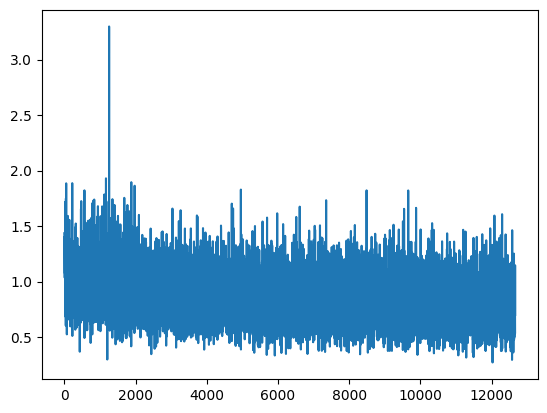

In [28]:
plt.plot(train_losses)

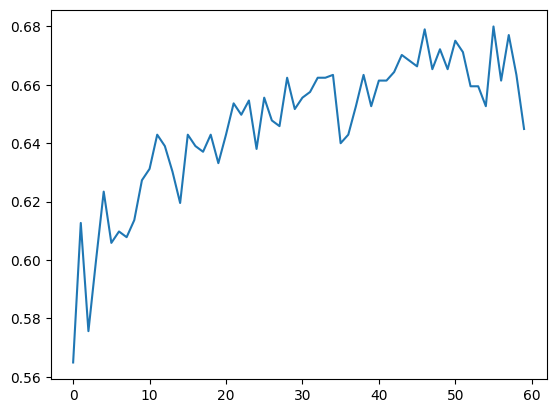

In [29]:
plt.plot(test_accuracy)

In [30]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 661/1024 (0.6455)
{'acc_detail': tensor([0.6090, 0.6623, 0.6981, 0.6151], device='cuda:0'),
 'acc_unweighted': tensor(0.6461, device='cuda:0'),
 'acc_weighted': tensor(0.6455, device='cuda:0'),
 'f1s': tensor(0.6505, device='cuda:0'),
 'f1s_detail': tensor([0.6850, 0.5992, 0.7598, 0.5582], device='cuda:0'),
 'precision_detail': tensor([0.7826, 0.5471, 0.8333, 0.5110], device='cuda:0'),
 'recall_detail': tensor([0.6090, 0.6623, 0.6981, 0.6151], device='cuda:0'),
 'rocauc': tensor([0.9213, 0.8661, 0.9358, 0.7835], device='cuda:0'),
 'uar': tensor(0.6461, device='cuda:0'),
 'wap': tensor(0.6730, device='cuda:0')}


tensor([[162,  14,   1,  89],
        [  4, 151,  19,  54],
        [  1,  66, 185,  13],
        [ 40,  45,  17, 163]], device='cuda:0')

In [32]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m18_best_56epoch.pt
Correct: 697/1024 (0.6807)
{'acc_detail': tensor([0.7669, 0.7149, 0.7396, 0.5057], device='cuda:0'),
 'acc_unweighted': tensor(0.6818, device='cuda:0'),
 'acc_weighted': tensor(0.6807, device='cuda:0'),
 'f1s': tensor(0.6783, device='cuda:0'),
 'f1s_detail': tensor([0.7698, 0.6186, 0.7641, 0.5607], device='cuda:0'),
 'precision_detail': tensor([0.7727, 0.5452, 0.7903, 0.6291], device='cuda:0'),
 'recall_detail': tensor([0.7669, 0.7149, 0.7396, 0.5057], device='cuda:0'),
 'rocauc': tensor([0.9334, 0.8745, 0.9346, 0.7957], device='cuda:0'),
 'uar': tensor(0.6818, device='cuda:0'),
 'wap': tensor(0.6894, device='cuda:0')}


tensor([[204,  21,   3,  38],
        [  3, 163,  29,  33],
        [  2,  59, 196,   8],
        [ 55,  56,  20, 134]], device='cuda:0')

In [33]:
np.save('../models_cremad4/cremad4_m18_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad4/cremad4_m18_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [34]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.007272727272727273/40 [00:00<45:50, 68.78s/it]

Train Epoch: 61 [0/3387 (0%)]	Loss: 0.555812
Mem before-during-after: 37008384 2652063744 43597824


  0%|▋                                                                                                                                                                              | 0.14909090909090902/40 [00:12<59:16, 89.24s/it]

Train Epoch: 61 [640/3387 (19%)]	Loss: 0.801436
Mem before-during-after: 43525120 2666498048 43525120


  1%|█▎                                                                                                                                                                             | 0.29454545454545467/40 [00:24<59:29, 89.91s/it]

Train Epoch: 61 [1280/3387 (38%)]	Loss: 0.836073
Mem before-during-after: 44532736 2666528256 44532736


  1%|█▉                                                                                                                                                                              | 0.4436363636363647/40 [00:36<52:39, 79.87s/it]

Train Epoch: 61 [1920/3387 (57%)]	Loss: 0.595576
Mem before-during-after: 43516928 2665122816 43516928


  1%|██▌                                                                                                                                                                             | 0.5890909090909111/40 [00:48<51:20, 78.16s/it]

Train Epoch: 61 [2560/3387 (76%)]	Loss: 0.771840
Mem before-during-after: 45124608 2666009600 44532736


  2%|███▏                                                                                                                                                                            | 0.7309090909090938/40 [00:59<58:20, 89.14s/it]

Train Epoch: 61 [3200/3387 (95%)]	Loss: 0.799216
Mem before-during-after: 44532736 2666730496 45124608


  3%|████▍                                                                                                                                                                           | 1.0000000000000047/40 [01:15<36:25, 56.05s/it]


Test Epoch: 61	Accuracy: 690/1024 (67%)



  3%|████▍                                                                                                                                                                            | 1.007272727272732/40 [01:16<39:22, 60.58s/it]

Train Epoch: 62 [0/3387 (0%)]	Loss: 0.517581
Mem before-during-after: 44002304 2668085248 43906560


  3%|█████                                                                                                                                                                           | 1.1490909090909147/40 [01:27<59:24, 91.74s/it]

Train Epoch: 62 [640/3387 (19%)]	Loss: 0.881032
Mem before-during-after: 43516928 2541218304 43516928


  3%|█████▋                                                                                                                                                                           | 1.294545454545461/40 [01:39<56:57, 88.30s/it]

Train Epoch: 62 [1280/3387 (38%)]	Loss: 0.726621
Mem before-during-after: 44125184 2658356736 43516928


  4%|██████▎                                                                                                                                                                         | 1.4400000000000075/40 [01:51<58:34, 91.14s/it]

Train Epoch: 62 [1920/3387 (57%)]	Loss: 0.840779
Mem before-during-after: 43516928 2667339776 44421120


  4%|██████▉                                                                                                                                                                         | 1.5854545454545539/40 [02:04<57:54, 90.46s/it]

Train Epoch: 62 [2560/3387 (76%)]	Loss: 0.687009
Mem before-during-after: 43516928 2656857600 43516928


  4%|███████▌                                                                                                                                                                        | 1.7309090909091003/40 [02:16<58:03, 91.02s/it]

Train Epoch: 62 [3200/3387 (95%)]	Loss: 0.461358
Mem before-during-after: 43516928 2665795584 43516928


  5%|████████▊                                                                                                                                                                        | 2.000000000000011/40 [02:32<35:53, 56.68s/it]


Test Epoch: 62	Accuracy: 674/1024 (66%)



  5%|████████▉                                                                                                                                                                        | 2.007272727272738/40 [02:32<39:06, 61.77s/it]

Train Epoch: 63 [0/3387 (0%)]	Loss: 0.958546
Mem before-during-after: 44341248 2668424192 44888576


  5%|█████████▌                                                                                                                                                                       | 2.149090909090912/40 [02:44<56:58, 90.31s/it]

Train Epoch: 63 [640/3387 (19%)]	Loss: 0.690262
Mem before-during-after: 43516928 2666156032 43516928


  6%|██████████                                                                                                                                                                      | 2.2945454545454496/40 [02:56<56:19, 89.62s/it]

Train Epoch: 63 [1280/3387 (38%)]	Loss: 0.779796
Mem before-during-after: 43516928 2656857600 43516928


  6%|██████████▊                                                                                                                                                                      | 2.439999999999987/40 [03:08<57:04, 91.18s/it]

Train Epoch: 63 [1920/3387 (57%)]	Loss: 0.532517
Mem before-during-after: 43516928 2658584064 43516928


  6%|███████████▍                                                                                                                                                                    | 2.5854545454545246/40 [03:20<55:31, 89.05s/it]

Train Epoch: 63 [2560/3387 (76%)]	Loss: 1.041602
Mem before-during-after: 44305408 2666584064 44305408


  7%|████████████                                                                                                                                                                     | 2.730909090909062/40 [03:32<56:02, 90.22s/it]

Train Epoch: 63 [3200/3387 (95%)]	Loss: 0.881149
Mem before-during-after: 43516928 2519424512 43516928


  7%|█████████████▏                                                                                                                                                                  | 2.9999999999999565/40 [03:48<33:26, 54.22s/it]


Test Epoch: 63	Accuracy: 678/1024 (66%)



  8%|█████████████▎                                                                                                                                                                    | 3.00363636363632/40 [03:48<39:50, 64.61s/it]

Train Epoch: 64 [0/3387 (0%)]	Loss: 0.871904
Mem before-during-after: 44528640 2522502144 44213248


  8%|█████████████▊                                                                                                                                                                  | 3.1490909090908574/40 [04:00<56:21, 91.76s/it]

Train Epoch: 64 [640/3387 (19%)]	Loss: 0.361515
Mem before-during-after: 44532736 2669050880 44108800


  8%|██████████████▌                                                                                                                                                                  | 3.294545454545395/40 [04:13<54:38, 89.31s/it]

Train Epoch: 64 [1280/3387 (38%)]	Loss: 1.761061
Mem before-during-after: 43516928 2657645056 43516928


  9%|███████████████▏                                                                                                                                                                | 3.4399999999999324/40 [04:24<53:52, 88.43s/it]

Train Epoch: 64 [1920/3387 (57%)]	Loss: 0.632136
Mem before-during-after: 43516928 2656973312 43516928


  9%|███████████████▉                                                                                                                                                                  | 3.58545454545447/40 [04:36<54:57, 90.56s/it]

Train Epoch: 64 [2560/3387 (76%)]	Loss: 0.910440
Mem before-during-after: 44421120 2667372544 44421120


  9%|████████████████▍                                                                                                                                                               | 3.7309090909090075/40 [04:48<54:01, 89.38s/it]

Train Epoch: 64 [3200/3387 (95%)]	Loss: 0.674408
Mem before-during-after: 43516928 2666435584 43516928


 10%|█████████████████▋                                                                                                                                                               | 3.999999999999902/40 [05:04<33:27, 55.78s/it]


Test Epoch: 64	Accuracy: 689/1024 (67%)



 10%|█████████████████▋                                                                                                                                                               | 4.007272727272629/40 [05:04<36:08, 60.24s/it]

Train Epoch: 65 [0/3387 (0%)]	Loss: 0.474534
Mem before-during-after: 44341248 2668424192 44888576


 10%|██████████████████▎                                                                                                                                                              | 4.149090909090821/40 [05:16<52:48, 88.38s/it]

Train Epoch: 65 [640/3387 (19%)]	Loss: 0.516012
Mem before-during-after: 43525120 2666906112 43525120


 11%|███████████████████                                                                                                                                                              | 4.294545454545376/40 [05:28<53:51, 90.52s/it]

Train Epoch: 65 [1280/3387 (38%)]	Loss: 1.030893
Mem before-during-after: 43516928 2666699776 44421120


 11%|███████████████████▋                                                                                                                                                             | 4.439999999999931/40 [05:40<52:53, 89.25s/it]

Train Epoch: 65 [1920/3387 (57%)]	Loss: 0.754626
Mem before-during-after: 44421120 2665795584 43516928


 11%|████████████████████▎                                                                                                                                                            | 4.585454545454486/40 [05:52<51:50, 87.84s/it]

Train Epoch: 65 [2560/3387 (76%)]	Loss: 0.716160
Mem before-during-after: 43516928 2656857600 43516928


 12%|████████████████████▉                                                                                                                                                            | 4.730909090909042/40 [06:03<52:33, 89.40s/it]

Train Epoch: 65 [3200/3387 (95%)]	Loss: 0.829200
Mem before-during-after: 43516928 2665396736 43516928


 12%|██████████████████████                                                                                                                                                           | 4.999999999999969/40 [06:19<31:57, 54.77s/it]


Test Epoch: 65	Accuracy: 688/1024 (67%)



 13%|██████████████████████▏                                                                                                                                                          | 5.003636363636333/40 [06:19<36:48, 63.10s/it]

Train Epoch: 66 [0/3387 (0%)]	Loss: 0.731406
Mem before-during-after: 44002304 2668085248 43906560


 13%|██████████████████████▊                                                                                                                                                          | 5.149090909090888/40 [06:31<52:21, 90.15s/it]

Train Epoch: 66 [640/3387 (19%)]	Loss: 0.702357
Mem before-during-after: 44421120 2657089024 43516928


 13%|███████████████████████▍                                                                                                                                                         | 5.294545454545443/40 [06:43<52:07, 90.12s/it]

Train Epoch: 66 [1280/3387 (38%)]	Loss: 0.969192
Mem before-during-after: 43525120 2667137536 44502016


 14%|████████████████████████                                                                                                                                                         | 5.439999999999999/40 [06:55<51:34, 89.54s/it]

Train Epoch: 66 [1920/3387 (57%)]	Loss: 0.694318
Mem before-during-after: 43578368 2657682944 43516928


 14%|████████████████████████▋                                                                                                                                                        | 5.585454545454554/40 [07:07<51:21, 89.55s/it]

Train Epoch: 66 [2560/3387 (76%)]	Loss: 0.558696
Mem before-during-after: 43516928 2665281024 44532736


 14%|█████████████████████████▎                                                                                                                                                       | 5.730909090909109/40 [07:19<52:43, 92.32s/it]

Train Epoch: 66 [3200/3387 (95%)]	Loss: 1.097062
Mem before-during-after: 43628544 2464154624 43603968


 15%|██████████████████████████▌                                                                                                                                                      | 6.000000000000036/40 [07:35<30:42, 54.20s/it]


Test Epoch: 66	Accuracy: 675/1024 (66%)



 15%|██████████████████████████▊                                                                                                                                                        | 6.0036363636364/40 [07:35<35:36, 62.85s/it]

Train Epoch: 67 [0/3387 (0%)]	Loss: 0.883367
Mem before-during-after: 45018112 2667844608 44421120


 15%|███████████████████████████                                                                                                                                                     | 6.1527272727273195/40 [07:47<43:53, 77.81s/it]

Train Epoch: 67 [640/3387 (19%)]	Loss: 1.185169
Mem before-during-after: 44532736 2403809280 43516928


 16%|███████████████████████████▊                                                                                                                                                     | 6.294545454545511/40 [07:59<50:19, 89.60s/it]

Train Epoch: 67 [1280/3387 (38%)]	Loss: 0.852064
Mem before-during-after: 43516928 2665122816 43516928


 16%|████████████████████████████▍                                                                                                                                                    | 6.440000000000066/40 [08:11<50:06, 89.60s/it]

Train Epoch: 67 [1920/3387 (57%)]	Loss: 0.827981
Mem before-during-after: 44532736 2666528256 44532736


 16%|█████████████████████████████▏                                                                                                                                                   | 6.589090909090985/40 [08:23<44:02, 79.09s/it]

Train Epoch: 67 [2560/3387 (76%)]	Loss: 0.994269
Mem before-during-after: 44421120 2665795584 43516928


 17%|█████████████████████████████▊                                                                                                                                                   | 6.730909090909177/40 [08:34<49:14, 88.81s/it]

Train Epoch: 67 [3200/3387 (95%)]	Loss: 0.682942
Mem before-during-after: 44197888 2667347968 43628544


 18%|██████████████████████████████▉                                                                                                                                                  | 7.000000000000104/40 [08:50<29:48, 54.20s/it]


Test Epoch: 67	Accuracy: 668/1024 (65%)



 18%|██████████████████████████████▉                                                                                                                                                  | 7.003636363636468/40 [08:50<34:24, 62.56s/it]

Train Epoch: 68 [0/3387 (0%)]	Loss: 1.039286
Mem before-during-after: 45276160 2667344384 43628544


 18%|███████████████████████████████▋                                                                                                                                                 | 7.149090909091023/40 [09:02<49:17, 90.02s/it]

Train Epoch: 68 [640/3387 (19%)]	Loss: 0.436998
Mem before-during-after: 43628544 2668105216 44421120


 18%|████████████████████████████████▎                                                                                                                                                | 7.294545454545578/40 [09:14<48:50, 89.61s/it]

Train Epoch: 68 [1280/3387 (38%)]	Loss: 0.932744
Mem before-during-after: 43525120 2666137088 43516928


 19%|████████████████████████████████▉                                                                                                                                                | 7.440000000000134/40 [09:26<48:28, 89.33s/it]

Train Epoch: 68 [1920/3387 (57%)]	Loss: 0.627525
Mem before-during-after: 44421120 2667372544 44421120


 19%|█████████████████████████████████▌                                                                                                                                               | 7.585454545454689/40 [09:38<48:33, 89.88s/it]

Train Epoch: 68 [2560/3387 (76%)]	Loss: 0.717412
Mem before-during-after: 43732992 2666441728 43516928


 19%|██████████████████████████████████▏                                                                                                                                              | 7.730909090909244/40 [09:50<48:03, 89.37s/it]

Train Epoch: 68 [3200/3387 (95%)]	Loss: 0.911807
Mem before-during-after: 44532736 2666499072 43628544


 20%|███████████████████████████████████▌                                                                                                                                              | 8.00000000000017/40 [10:06<29:33, 55.42s/it]


Test Epoch: 68	Accuracy: 669/1024 (65%)



 20%|███████████████████████████████████▍                                                                                                                                             | 8.003636363636534/40 [10:06<33:24, 62.63s/it]

Train Epoch: 69 [0/3387 (0%)]	Loss: 0.987623
Mem before-during-after: 43624448 2657737216 43937792


 20%|████████████████████████████████████▎                                                                                                                                             | 8.14909090909109/40 [10:18<47:50, 90.11s/it]

Train Epoch: 69 [640/3387 (19%)]	Loss: 0.990654
Mem before-during-after: 44126208 2667395584 43628544


 21%|████████████████████████████████████▋                                                                                                                                            | 8.294545454545645/40 [10:30<47:10, 89.26s/it]

Train Epoch: 69 [1280/3387 (38%)]	Loss: 0.619672
Mem before-during-after: 44421120 2664816640 44532736


 21%|█████████████████████████████████████▊                                                                                                                                             | 8.4400000000002/40 [10:41<46:48, 88.98s/it]

Train Epoch: 69 [1920/3387 (57%)]	Loss: 0.600717
Mem before-during-after: 43516928 2666699776 44421120


 21%|█████████████████████████████████████▉                                                                                                                                           | 8.585454545454756/40 [10:53<46:53, 89.55s/it]

Train Epoch: 69 [2560/3387 (76%)]	Loss: 0.770573
Mem before-during-after: 43525120 2667343360 43628544


 22%|██████████████████████████████████████▊                                                                                                                                           | 8.73090909090931/40 [11:05<47:50, 91.79s/it]

Train Epoch: 69 [3200/3387 (95%)]	Loss: 0.667772
Mem before-during-after: 45389824 2667372544 45077504


 23%|███████████████████████████████████████▊                                                                                                                                         | 9.000000000000238/40 [11:21<27:53, 53.99s/it]


Test Epoch: 69	Accuracy: 672/1024 (66%)



 23%|███████████████████████████████████████▊                                                                                                                                         | 9.007272727272966/40 [11:21<31:01, 60.06s/it]

Train Epoch: 70 [0/3387 (0%)]	Loss: 0.613595
Mem before-during-after: 43512832 2658558464 43937792


 23%|████████████████████████████████████████▍                                                                                                                                        | 9.149090909091157/40 [11:33<46:28, 90.39s/it]

Train Epoch: 70 [640/3387 (19%)]	Loss: 0.831121
Mem before-during-after: 43516928 2666857984 43732992


 23%|█████████████████████████████████████████▏                                                                                                                                       | 9.294545454545712/40 [11:45<45:34, 89.07s/it]

Train Epoch: 70 [1280/3387 (38%)]	Loss: 0.360017
Mem before-during-after: 44421120 2666443264 44532736


 24%|█████████████████████████████████████████▊                                                                                                                                       | 9.440000000000268/40 [11:57<45:47, 89.90s/it]

Train Epoch: 70 [1920/3387 (57%)]	Loss: 0.940974
Mem before-during-after: 43516928 2666152448 43628544


 24%|██████████████████████████████████████████▍                                                                                                                                      | 9.589090909091187/40 [12:09<39:53, 78.70s/it]

Train Epoch: 70 [2560/3387 (76%)]	Loss: 0.925416
Mem before-during-after: 43516928 2665714688 43732992


 24%|███████████████████████████████████████████                                                                                                                                      | 9.730909090909378/40 [12:20<45:00, 89.23s/it]

Train Epoch: 70 [3200/3387 (95%)]	Loss: 0.962005
Mem before-during-after: 43516928 2667339776 44421120


 25%|████████████████████████████████████████████                                                                                                                                    | 10.000000000000306/40 [12:36<28:31, 57.06s/it]


Test Epoch: 70	Accuracy: 660/1024 (64%)



 25%|████████████████████████████████████████████                                                                                                                                    | 10.007272727273033/40 [12:37<30:39, 61.34s/it]

Train Epoch: 71 [0/3387 (0%)]	Loss: 0.474923
Mem before-during-after: 43512832 2667695616 43879424


 25%|████████████████████████████████████████████▋                                                                                                                                   | 10.149090909091225/40 [12:49<44:19, 89.10s/it]

Train Epoch: 71 [640/3387 (19%)]	Loss: 0.454777
Mem before-during-after: 44164608 2667372544 44421120


 26%|█████████████████████████████████████████████▎                                                                                                                                  | 10.298181818182144/40 [13:01<38:44, 78.25s/it]

Train Epoch: 71 [1280/3387 (38%)]	Loss: 0.718853
Mem before-during-after: 43516928 2657089024 43516928


 26%|█████████████████████████████████████████████▉                                                                                                                                  | 10.440000000000335/40 [13:12<43:33, 88.43s/it]

Train Epoch: 71 [1920/3387 (57%)]	Loss: 1.047091
Mem before-during-after: 43525120 2666858496 43525120


 26%|██████████████████████████████████████████████▊                                                                                                                                  | 10.58545454545489/40 [13:24<43:58, 89.69s/it]

Train Epoch: 71 [2560/3387 (76%)]	Loss: 0.441539
Mem before-during-after: 43628544 2665594880 44532736


 27%|███████████████████████████████████████████████▏                                                                                                                                | 10.730909090909446/40 [13:36<43:32, 89.26s/it]

Train Epoch: 71 [3200/3387 (95%)]	Loss: 0.776447
Mem before-during-after: 44502016 2658213888 43628544


 28%|████████████████████████████████████████████████▍                                                                                                                               | 11.000000000000373/40 [13:52<26:05, 53.98s/it]


Test Epoch: 71	Accuracy: 687/1024 (67%)



 28%|████████████████████████████████████████████████▉                                                                                                                                 | 11.0072727272731/40 [13:52<29:10, 60.38s/it]

Train Epoch: 72 [0/3387 (0%)]	Loss: 0.776238
Mem before-during-after: 45276160 2667344384 43628544


 28%|█████████████████████████████████████████████████                                                                                                                               | 11.149090909091292/40 [14:04<42:32, 88.46s/it]

Train Epoch: 72 [640/3387 (19%)]	Loss: 0.640221
Mem before-during-after: 44532736 2658863616 44228608


 28%|█████████████████████████████████████████████████▋                                                                                                                              | 11.294545454545847/40 [14:16<42:42, 89.26s/it]

Train Epoch: 72 [1280/3387 (38%)]	Loss: 0.675024
Mem before-during-after: 44036096 2657608192 43628544


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 11.440000000000403/40 [14:28<42:49, 89.97s/it]

Train Epoch: 72 [1920/3387 (57%)]	Loss: 0.757510
Mem before-during-after: 43516928 2657089024 43516928


 29%|██████████████████████████████████████████████████▉                                                                                                                             | 11.585454545454958/40 [14:40<42:13, 89.18s/it]

Train Epoch: 72 [2560/3387 (76%)]	Loss: 1.239149
Mem before-during-after: 44421120 2609940480 43813888


 29%|███████████████████████████████████████████████████▌                                                                                                                            | 11.730909090909513/40 [14:52<42:26, 90.09s/it]

Train Epoch: 72 [3200/3387 (95%)]	Loss: 0.851213
Mem before-during-after: 44022784 2666528256 43525120


 30%|█████████████████████████████████████████████████████                                                                                                                            | 12.00000000000044/40 [15:07<25:11, 53.98s/it]


Test Epoch: 72	Accuracy: 688/1024 (67%)



 30%|████████████████████████████████████████████████████▊                                                                                                                           | 12.003636363636804/40 [15:08<28:46, 61.66s/it]

Train Epoch: 73 [0/3387 (0%)]	Loss: 1.039070
Mem before-during-after: 44234240 2668424192 43516928


 30%|█████████████████████████████████████████████████████▍                                                                                                                          | 12.152727272727724/40 [15:20<36:38, 78.93s/it]

Train Epoch: 73 [640/3387 (19%)]	Loss: 0.422260
Mem before-during-after: 43516928 2665281024 44532736


 31%|██████████████████████████████████████████████████████                                                                                                                          | 12.294545454545915/40 [15:31<41:25, 89.73s/it]

Train Epoch: 73 [1280/3387 (38%)]	Loss: 0.642928
Mem before-during-after: 43516928 2667339776 44421120


 31%|███████████████████████████████████████████████████████                                                                                                                          | 12.44000000000047/40 [15:43<40:48, 88.83s/it]

Train Epoch: 73 [1920/3387 (57%)]	Loss: 0.554347
Mem before-during-after: 43516928 2667320832 44421120


 31%|███████████████████████████████████████████████████████▍                                                                                                                        | 12.585454545455026/40 [15:55<40:32, 88.71s/it]

Train Epoch: 73 [2560/3387 (76%)]	Loss: 0.692298
Mem before-during-after: 43516928 2658062848 43516928


 32%|████████████████████████████████████████████████████████▎                                                                                                                        | 12.73090909090958/40 [16:07<40:17, 88.64s/it]

Train Epoch: 73 [3200/3387 (95%)]	Loss: 1.137233
Mem before-during-after: 44421120 2541072896 43516928


 33%|█████████████████████████████████████████████████████████▏                                                                                                                      | 13.000000000000508/40 [16:22<24:47, 55.10s/it]


Test Epoch: 73	Accuracy: 677/1024 (66%)



 33%|█████████████████████████████████████████████████████████▏                                                                                                                      | 13.007272727273236/40 [16:23<27:04, 60.19s/it]

Train Epoch: 74 [0/3387 (0%)]	Loss: 0.562463
Mem before-during-after: 44341248 2521265664 43628544


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 13.149090909091427/40 [16:35<39:43, 88.78s/it]

Train Epoch: 74 [640/3387 (19%)]	Loss: 1.239410
Mem before-during-after: 44532736 2659476992 44532736


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 13.294545454545982/40 [16:46<39:37, 89.02s/it]

Train Epoch: 74 [1280/3387 (38%)]	Loss: 0.995655
Mem before-during-after: 44126208 2665594880 44532736


 34%|███████████████████████████████████████████████████████████▏                                                                                                                    | 13.440000000000538/40 [16:58<39:22, 88.95s/it]

Train Epoch: 74 [1920/3387 (57%)]	Loss: 1.112735
Mem before-during-after: 43516928 2656857600 43516928


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 13.585454545455093/40 [17:10<39:46, 90.36s/it]

Train Epoch: 74 [2560/3387 (76%)]	Loss: 0.944628
Mem before-during-after: 43516928 2667339776 44421120


 34%|████████████████████████████████████████████████████████████▍                                                                                                                   | 13.730909090909648/40 [17:22<39:08, 89.39s/it]

Train Epoch: 74 [3200/3387 (95%)]	Loss: 0.460750
Mem before-during-after: 44421120 2665795584 43516928


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                  | 14.000000000000576/40 [17:38<23:44, 54.80s/it]


Test Epoch: 74	Accuracy: 694/1024 (68%)



 35%|█████████████████████████████████████████████████████████████▉                                                                                                                   | 14.00363636363694/40 [17:38<27:22, 63.20s/it]

Train Epoch: 75 [0/3387 (0%)]	Loss: 0.668706
Mem before-during-after: 44002304 2668085248 43906560


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                 | 14.149090909091495/40 [17:50<38:31, 89.41s/it]

Train Epoch: 75 [640/3387 (19%)]	Loss: 0.846582
Mem before-during-after: 43516928 2666185216 43516928


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                 | 14.29454545454605/40 [18:02<37:59, 88.66s/it]

Train Epoch: 75 [1280/3387 (38%)]	Loss: 0.675656
Mem before-during-after: 43525120 2666497536 43525120


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                 | 14.44363636363697/40 [18:14<33:27, 78.54s/it]

Train Epoch: 75 [1920/3387 (57%)]	Loss: 0.764007
Mem before-during-after: 44532736 2667908608 45321216


 36%|████████████████████████████████████████████████████████████████▌                                                                                                                | 14.58545454545516/40 [18:25<37:51, 89.39s/it]

Train Epoch: 75 [2560/3387 (76%)]	Loss: 0.678207
Mem before-during-after: 43525120 2666524160 43525120


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 14.730909090909716/40 [18:37<38:09, 90.59s/it]

Train Epoch: 75 [3200/3387 (95%)]	Loss: 0.957902
Mem before-during-after: 43732992 2666699776 44421120


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 15.000000000000643/40 [18:53<21:50, 52.43s/it]


Test Epoch: 75	Accuracy: 679/1024 (66%)



 38%|██████████████████████████████████████████████████████████████████▍                                                                                                              | 15.00727272727337/40 [18:54<24:48, 59.56s/it]

Train Epoch: 76 [0/3387 (0%)]	Loss: 0.784473
Mem before-during-after: 44371968 2668181504 43516928


 38%|██████████████████████████████████████████████████████████████████▋                                                                                                             | 15.149090909091562/40 [19:05<36:53, 89.06s/it]

Train Epoch: 76 [640/3387 (19%)]	Loss: 0.739593
Mem before-during-after: 44532736 2659576320 44220416


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                            | 15.294545454546117/40 [19:17<36:34, 88.82s/it]

Train Epoch: 76 [1280/3387 (38%)]	Loss: 0.726950
Mem before-during-after: 43516928 2657089024 43628544


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 15.440000000000673/40 [19:29<37:04, 90.56s/it]

Train Epoch: 76 [1920/3387 (57%)]	Loss: 0.862372
Mem before-during-after: 44532736 2667120128 43732992


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                           | 15.589090909091592/40 [19:41<32:02, 78.75s/it]

Train Epoch: 76 [2560/3387 (76%)]	Loss: 0.783464
Mem before-during-after: 43516928 2666857984 43732992


 39%|█████████████████████████████████████████████████████████████████████▏                                                                                                          | 15.730909090909783/40 [19:53<36:15, 89.62s/it]

Train Epoch: 76 [3200/3387 (95%)]	Loss: 1.199436
Mem before-during-after: 43516928 2665122816 43516928


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 16.00000000000071/40 [20:09<21:15, 53.14s/it]


Test Epoch: 76	Accuracy: 680/1024 (66%)



 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 16.003636363637074/40 [20:09<24:44, 61.88s/it]

Train Epoch: 77 [0/3387 (0%)]	Loss: 0.729659
Mem before-during-after: 44260352 2668343296 43516928


 40%|███████████████████████████████████████████████████████████████████████▍                                                                                                         | 16.14909090909163/40 [20:21<35:22, 89.00s/it]

Train Epoch: 77 [640/3387 (19%)]	Loss: 0.705308
Mem before-during-after: 44421120 2666699776 44421120


 41%|███████████████████████████████████████████████████████████████████████▋                                                                                                        | 16.294545454546185/40 [20:33<35:35, 90.10s/it]

Train Epoch: 77 [1280/3387 (38%)]	Loss: 0.505236
Mem before-during-after: 43516928 2667320832 44421120


 41%|████████████████████████████████████████████████████████████████████████▋                                                                                                        | 16.44000000000074/40 [20:45<35:00, 89.14s/it]

Train Epoch: 77 [1920/3387 (57%)]	Loss: 0.730692
Mem before-during-after: 43516928 2665122816 44532736


 41%|████████████████████████████████████████████████████████████████████████▉                                                                                                       | 16.585454545455296/40 [20:57<35:00, 89.73s/it]

Train Epoch: 77 [2560/3387 (76%)]	Loss: 1.447516
Mem before-during-after: 44532736 2667518976 44220416


 42%|█████████████████████████████████████████████████████████████████████████▋                                                                                                      | 16.734545454546215/40 [21:09<31:47, 81.99s/it]

Train Epoch: 77 [3200/3387 (95%)]	Loss: 1.000818
Mem before-during-after: 44173312 2657856000 43525120


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 17.000000000000778/40 [21:24<20:45, 54.16s/it]


Test Epoch: 77	Accuracy: 689/1024 (67%)



 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 17.003636363637142/40 [21:24<25:00, 65.23s/it]

Train Epoch: 78 [0/3387 (0%)]	Loss: 0.966237
Mem before-during-after: 43983360 2658096128 43937792


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 17.149090909091697/40 [21:36<33:58, 89.21s/it]

Train Epoch: 78 [640/3387 (19%)]	Loss: 0.636239
Mem before-during-after: 43539456 2667372544 44443648


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                    | 17.294545454546252/40 [21:48<33:56, 89.69s/it]

Train Epoch: 78 [1280/3387 (38%)]	Loss: 0.899493
Mem before-during-after: 44305408 2665512448 43516928


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 17.440000000000808/40 [22:00<33:54, 90.18s/it]

Train Epoch: 78 [1920/3387 (57%)]	Loss: 0.752671
Mem before-during-after: 45030400 2667316736 43516928


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 17.585454545455363/40 [22:12<33:07, 88.68s/it]

Train Epoch: 78 [2560/3387 (76%)]	Loss: 1.303073
Mem before-during-after: 43628544 2465047040 43992064


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 17.73090909090992/40 [22:24<32:59, 88.91s/it]

Train Epoch: 78 [3200/3387 (95%)]	Loss: 0.586388
Mem before-during-after: 43516928 2665762816 44532736


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 18.000000000000846/40 [22:40<19:59, 54.54s/it]


Test Epoch: 78	Accuracy: 704/1024 (69%)

saved model: ../models_cremad4/cremad_label4_m18_best_78epoch.pt


 45%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 18.00363636363721/40 [22:40<23:05, 63.01s/it]

Train Epoch: 79 [0/3387 (0%)]	Loss: 0.620493
Mem before-during-after: 44341248 2668424192 44888576


 45%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                | 18.149090909091765/40 [22:52<32:52, 90.25s/it]

Train Epoch: 79 [640/3387 (19%)]	Loss: 0.896480
Mem before-during-after: 44421120 2667372544 44421120


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 18.29454545454632/40 [23:04<32:22, 89.49s/it]

Train Epoch: 79 [1280/3387 (38%)]	Loss: 0.844947
Mem before-during-after: 43516928 2657802752 43516928


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 18.440000000000875/40 [23:16<32:13, 89.69s/it]

Train Epoch: 79 [1920/3387 (57%)]	Loss: 0.782405
Mem before-during-after: 43516928 2665795584 43516928


 46%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 18.58545454545543/40 [23:28<33:22, 93.50s/it]

Train Epoch: 79 [2560/3387 (76%)]	Loss: 0.759418
Mem before-during-after: 44164608 2666699776 43516928


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 18.730909090909986/40 [23:40<31:50, 89.84s/it]

Train Epoch: 79 [3200/3387 (95%)]	Loss: 0.761130
Mem before-during-after: 44421120 2665795584 43516928


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 19.000000000000913/40 [23:56<19:57, 57.03s/it]


Test Epoch: 79	Accuracy: 697/1024 (68%)



 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19.00727272727364/40 [23:56<21:23, 61.12s/it]

Train Epoch: 80 [0/3387 (0%)]	Loss: 1.198653
Mem before-during-after: 43512832 2667695616 43879424


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 19.149090909091832/40 [24:08<30:28, 87.69s/it]

Train Epoch: 80 [640/3387 (19%)]	Loss: 0.733013
Mem before-during-after: 44125184 2657856000 43525120


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 19.294545454546387/40 [24:20<31:10, 90.35s/it]

Train Epoch: 80 [1280/3387 (38%)]	Loss: 0.806966
Mem before-during-after: 43628544 2666811392 44421120


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 19.440000000000943/40 [24:31<31:00, 90.51s/it]

Train Epoch: 80 [1920/3387 (57%)]	Loss: 0.646957
Mem before-during-after: 44532736 2666528256 44532736


 49%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 19.585454545455498/40 [24:43<30:00, 88.18s/it]

Train Epoch: 80 [2560/3387 (76%)]	Loss: 0.948707
Mem before-during-after: 43516928 2656939520 43516928


 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 19.730909090910053/40 [24:55<30:06, 89.15s/it]

Train Epoch: 80 [3200/3387 (95%)]	Loss: 0.605676
Mem before-during-after: 44532736 2667816448 45180416


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20.00000000000098/40 [25:11<18:07, 54.38s/it]


Test Epoch: 80	Accuracy: 690/1024 (67%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 20.003636363637344/40 [25:11<20:33, 61.71s/it]

Train Epoch: 81 [0/3387 (0%)]	Loss: 0.622223
Mem before-during-after: 43512832 2657625600 43937792


 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 20.1490909090919/40 [25:23<29:34, 89.38s/it]

Train Epoch: 81 [640/3387 (19%)]	Loss: 0.766205
Mem before-during-after: 44502016 2668012544 44116992


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 20.294545454546455/40 [25:35<29:24, 89.54s/it]

Train Epoch: 81 [1280/3387 (38%)]	Loss: 0.689231
Mem before-during-after: 44502016 2667453440 44502016


 51%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 20.44000000000101/40 [25:47<28:47, 88.31s/it]

Train Epoch: 81 [1920/3387 (57%)]	Loss: 0.944463
Mem before-during-after: 44049408 2666949120 44421120


 51%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 20.585454545455566/40 [25:59<28:57, 89.47s/it]

Train Epoch: 81 [2560/3387 (76%)]	Loss: 0.566711
Mem before-during-after: 43628544 2666499072 44532736


 52%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 20.734545454546485/40 [26:11<25:24, 79.12s/it]

Train Epoch: 81 [3200/3387 (95%)]	Loss: 0.780136
Mem before-during-after: 43516928 2665122816 43516928


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 21.000000000001048/40 [26:26<17:06, 54.02s/it]


Test Epoch: 81	Accuracy: 669/1024 (65%)



 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 21.003636363637412/40 [26:26<19:39, 62.10s/it]

Train Epoch: 82 [0/3387 (0%)]	Loss: 0.721110
Mem before-during-after: 44371968 2668181504 43516928


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 21.149090909091967/40 [26:38<28:58, 92.22s/it]

Train Epoch: 82 [640/3387 (19%)]	Loss: 0.959178
Mem before-during-after: 43844608 2658570752 43525120


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 21.294545454546522/40 [26:50<28:00, 89.82s/it]

Train Epoch: 82 [1280/3387 (38%)]	Loss: 0.600409
Mem before-during-after: 44108800 2668255232 43628544


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 21.440000000001078/40 [27:02<28:09, 91.03s/it]

Train Epoch: 82 [1920/3387 (57%)]	Loss: 0.748578
Mem before-during-after: 43777024 2666947072 44532736


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 21.589090909091997/40 [27:14<24:18, 79.20s/it]

Train Epoch: 82 [2560/3387 (76%)]	Loss: 0.490013
Mem before-during-after: 45436928 2668101120 45436928


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 21.73090909091019/40 [27:26<27:20, 89.80s/it]

Train Epoch: 82 [3200/3387 (95%)]	Loss: 0.927292
Mem before-during-after: 44421120 2665795584 43516928


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 22.000000000001116/40 [27:42<16:24, 54.70s/it]


Test Epoch: 82	Accuracy: 658/1024 (64%)



 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 22.00363636363748/40 [27:42<19:12, 64.02s/it]

Train Epoch: 83 [0/3387 (0%)]	Loss: 1.182013
Mem before-during-after: 44002304 2668085248 43906560


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 22.149090909092035/40 [27:54<26:37, 89.52s/it]

Train Epoch: 83 [640/3387 (19%)]	Loss: 0.610769
Mem before-during-after: 44922368 2659089920 44126208


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 22.29454545454659/40 [28:06<26:12, 88.84s/it]

Train Epoch: 83 [1280/3387 (38%)]	Loss: 1.119149
Mem before-during-after: 44532736 2668045312 45436928


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 22.440000000001145/40 [28:18<26:16, 89.77s/it]

Train Epoch: 83 [1920/3387 (57%)]	Loss: 0.601750
Mem before-during-after: 43628544 2666499072 44532736


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 22.5854545454557/40 [28:29<26:13, 90.35s/it]

Train Epoch: 83 [2560/3387 (76%)]	Loss: 1.003143
Mem before-during-after: 43628544 2666730496 43628544


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 22.730909090910256/40 [28:41<25:41, 89.26s/it]

Train Epoch: 83 [3200/3387 (95%)]	Loss: 1.103703
Mem before-during-after: 43628544 2666138624 43628544


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23.000000000001183/40 [28:57<15:07, 53.39s/it]


Test Epoch: 83	Accuracy: 680/1024 (66%)



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23.003636363637547/40 [28:57<17:19, 61.15s/it]

Train Epoch: 84 [0/3387 (0%)]	Loss: 0.803730
Mem before-during-after: 43983360 2658096128 43937792


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 23.149090909092102/40 [29:09<25:05, 89.36s/it]

Train Epoch: 84 [640/3387 (19%)]	Loss: 0.661921
Mem before-during-after: 44421120 2657089024 43516928


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 23.294545454546657/40 [29:21<25:15, 90.73s/it]

Train Epoch: 84 [1280/3387 (38%)]	Loss: 1.128378
Mem before-during-after: 44532736 2520280064 44447232


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 23.440000000001213/40 [29:33<24:50, 90.03s/it]

Train Epoch: 84 [1920/3387 (57%)]	Loss: 0.805381
Mem before-during-after: 44421120 2665795584 43516928


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 23.585454545455768/40 [29:45<24:31, 89.65s/it]

Train Epoch: 84 [2560/3387 (76%)]	Loss: 0.894912
Mem before-during-after: 43516928 2656857600 43516928


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 23.730909090910323/40 [29:57<24:13, 89.31s/it]

Train Epoch: 84 [3200/3387 (95%)]	Loss: 0.672760
Mem before-during-after: 43516928 2666699776 44421120


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 24.00000000000125/40 [30:13<14:07, 52.97s/it]


Test Epoch: 84	Accuracy: 688/1024 (67%)



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 24.003636363637614/40 [30:13<16:27, 61.72s/it]

Train Epoch: 85 [0/3387 (0%)]	Loss: 0.918872
Mem before-during-after: 43512832 2667695616 43879424


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 24.14909090909217/40 [30:25<23:30, 88.97s/it]

Train Epoch: 85 [640/3387 (19%)]	Loss: 0.773821
Mem before-during-after: 43867136 2668186112 44502016


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 24.294545454546725/40 [30:37<23:20, 89.18s/it]

Train Epoch: 85 [1280/3387 (38%)]	Loss: 0.714981
Mem before-during-after: 44532736 2667892736 44276224


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 24.44000000000128/40 [30:48<23:27, 90.44s/it]

Train Epoch: 85 [1920/3387 (57%)]	Loss: 1.120890
Mem before-during-after: 43516928 2666884608 43516928


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 24.585454545455836/40 [31:00<22:36, 88.00s/it]

Train Epoch: 85 [2560/3387 (76%)]	Loss: 0.905225
Mem before-during-after: 43516928 2464012288 43992064


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 24.73090909091039/40 [31:12<22:31, 88.53s/it]

Train Epoch: 85 [3200/3387 (95%)]	Loss: 0.608606
Mem before-during-after: 44421120 2657089024 43516928


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 25.000000000001318/40 [31:28<13:36, 54.40s/it]


Test Epoch: 85	Accuracy: 692/1024 (68%)



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 25.003636363637682/40 [31:28<15:31, 62.12s/it]

Train Epoch: 86 [0/3387 (0%)]	Loss: 0.985516
Mem before-during-after: 44002304 2668085248 43906560


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 25.149090909092237/40 [31:40<22:22, 90.40s/it]

Train Epoch: 86 [640/3387 (19%)]	Loss: 0.789318
Mem before-during-after: 44532736 2667168256 44532736


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 25.294545454546792/40 [31:52<21:50, 89.14s/it]

Train Epoch: 86 [1280/3387 (38%)]	Loss: 1.296006
Mem before-during-after: 43516928 2665512448 43516928


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 25.440000000001348/40 [32:04<21:40, 89.34s/it]

Train Epoch: 86 [1920/3387 (57%)]	Loss: 0.873486
Mem before-during-after: 43516928 2657247744 43516928


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 25.585454545455903/40 [32:16<21:20, 88.85s/it]

Train Epoch: 86 [2560/3387 (76%)]	Loss: 0.770038
Mem before-during-after: 43516928 2656857600 43516928


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 25.73090909091046/40 [32:27<21:09, 88.95s/it]

Train Epoch: 86 [3200/3387 (95%)]	Loss: 0.958022
Mem before-during-after: 44532736 2667484160 43628544


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 26.000000000001386/40 [32:43<12:45, 54.71s/it]


Test Epoch: 86	Accuracy: 672/1024 (66%)



 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 26.00363636363775/40 [32:43<14:51, 63.68s/it]

Train Epoch: 87 [0/3387 (0%)]	Loss: 0.573845
Mem before-during-after: 43521024 2665926144 43628544


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 26.149090909092305/40 [32:55<20:26, 88.58s/it]

Train Epoch: 87 [640/3387 (19%)]	Loss: 1.236144
Mem before-during-after: 43628544 2667479552 44532736


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 26.298181818183224/40 [33:07<18:06, 79.31s/it]

Train Epoch: 87 [1280/3387 (38%)]	Loss: 1.054894
Mem before-during-after: 44532736 2659688448 44718080


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 26.440000000001415/40 [33:19<20:22, 90.18s/it]

Train Epoch: 87 [1920/3387 (57%)]	Loss: 0.482013
Mem before-during-after: 44532736 2666730496 44532736


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 26.58545454545597/40 [33:31<20:22, 91.12s/it]

Train Epoch: 87 [2560/3387 (76%)]	Loss: 0.808918
Mem before-during-after: 43525120 2666497536 44502016


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26.730909090910526/40 [33:43<19:44, 89.24s/it]

Train Epoch: 87 [3200/3387 (95%)]	Loss: 0.646731
Mem before-during-after: 44421120 2657089024 43516928


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 27.000000000001453/40 [33:59<12:26, 57.39s/it]


Test Epoch: 87	Accuracy: 684/1024 (67%)



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 27.003636363637817/40 [33:59<14:04, 64.98s/it]

Train Epoch: 88 [0/3387 (0%)]	Loss: 0.764146
Mem before-during-after: 44341248 2668424192 44888576


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 27.149090909092372/40 [34:11<19:09, 89.45s/it]

Train Epoch: 88 [640/3387 (19%)]	Loss: 0.577861
Mem before-during-after: 43516928 2666811392 43516928


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 27.294545454546927/40 [34:23<18:52, 89.14s/it]

Train Epoch: 88 [1280/3387 (38%)]	Loss: 0.963476
Mem before-during-after: 43525120 2657465856 43516928


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 27.440000000001483/40 [34:35<18:56, 90.48s/it]

Train Epoch: 88 [1920/3387 (57%)]	Loss: 0.730687
Mem before-during-after: 44532736 2667582464 44532736


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 27.585454545456038/40 [34:47<18:25, 89.06s/it]

Train Epoch: 88 [2560/3387 (76%)]	Loss: 0.773194
Mem before-during-after: 44421120 2665795584 43516928


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27.730909090910593/40 [34:59<18:20, 89.66s/it]

Train Epoch: 88 [3200/3387 (95%)]	Loss: 0.634364
Mem before-during-after: 44613632 2668186112 44018176


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28.00000000000152/40 [35:15<11:01, 55.09s/it]


Test Epoch: 88	Accuracy: 667/1024 (65%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28.00727272727425/40 [35:16<12:19, 61.70s/it]

Train Epoch: 89 [0/3387 (0%)]	Loss: 0.842071
Mem before-during-after: 44260352 2668343296 43516928


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 28.14909090909244/40 [35:28<18:04, 91.49s/it]

Train Epoch: 89 [640/3387 (19%)]	Loss: 0.653856
Mem before-during-after: 43962368 2667873792 44532736


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 28.294545454546995/40 [35:40<17:29, 89.69s/it]

Train Epoch: 89 [1280/3387 (38%)]	Loss: 0.772608
Mem before-during-after: 43516928 2665107456 43516928


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 28.44000000000155/40 [35:52<17:13, 89.36s/it]

Train Epoch: 89 [1920/3387 (57%)]	Loss: 0.760796
Mem before-during-after: 44228608 2657928704 44570624


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 28.585454545456106/40 [36:04<17:30, 92.01s/it]

Train Epoch: 89 [2560/3387 (76%)]	Loss: 0.563443
Mem before-during-after: 43516928 2636935680 43516928


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 28.73090909091066/40 [36:16<17:31, 93.27s/it]

Train Epoch: 89 [3200/3387 (95%)]	Loss: 0.694351
Mem before-during-after: 45436928 2667690496 45436928


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 29.000000000001588/40 [36:32<10:13, 55.74s/it]


Test Epoch: 89	Accuracy: 677/1024 (66%)



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 29.003636363637952/40 [36:33<11:54, 64.98s/it]

Train Epoch: 90 [0/3387 (0%)]	Loss: 0.511644
Mem before-during-after: 43512832 2667695616 43879424


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 29.149090909092507/40 [36:45<16:31, 91.34s/it]

Train Epoch: 90 [640/3387 (19%)]	Loss: 0.932462
Mem before-during-after: 44421120 2667964416 44421120


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 29.294545454547062/40 [36:57<16:12, 90.87s/it]

Train Epoch: 90 [1280/3387 (38%)]	Loss: 0.896580
Mem before-during-after: 44532736 2665118720 44532736


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 29.440000000001618/40 [37:09<15:59, 90.83s/it]

Train Epoch: 90 [1920/3387 (57%)]	Loss: 0.683566
Mem before-during-after: 44421120 2668020224 44421120


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29.585454545456173/40 [37:21<15:23, 88.68s/it]

Train Epoch: 90 [2560/3387 (76%)]	Loss: 0.755158
Mem before-during-after: 43628544 2667459072 44532736


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29.73090909091073/40 [37:33<15:31, 90.76s/it]

Train Epoch: 90 [3200/3387 (95%)]	Loss: 0.953983
Mem before-during-after: 43516928 2667224064 44305408


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30.000000000001656/40 [37:49<09:40, 58.09s/it]


Test Epoch: 90	Accuracy: 693/1024 (68%)



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30.00363636363802/40 [37:49<10:50, 65.03s/it]

Train Epoch: 91 [0/3387 (0%)]	Loss: 0.892787
Mem before-during-after: 43512832 2657625600 43937792


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 30.149090909092575/40 [38:01<14:36, 88.94s/it]

Train Epoch: 91 [640/3387 (19%)]	Loss: 1.012688
Mem before-during-after: 43516928 2657247744 43516928


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 30.29454545454713/40 [38:13<14:16, 88.21s/it]

Train Epoch: 91 [1280/3387 (38%)]	Loss: 1.004670
Mem before-during-after: 44256768 2658486784 43525120


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 30.440000000001685/40 [38:25<14:25, 90.56s/it]

Train Epoch: 91 [1920/3387 (57%)]	Loss: 1.048155
Mem before-during-after: 43516928 2666497536 43516928


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 30.58545454545624/40 [38:37<14:01, 89.42s/it]

Train Epoch: 91 [2560/3387 (76%)]	Loss: 0.428515
Mem before-during-after: 43516928 2666027008 43516928


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 30.73454545454716/40 [38:49<12:04, 78.19s/it]

Train Epoch: 91 [3200/3387 (95%)]	Loss: 0.748690
Mem before-during-after: 43891200 2666418176 44795392


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31.000000000001723/40 [39:05<08:17, 55.28s/it]


Test Epoch: 91	Accuracy: 680/1024 (66%)



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31.003636363638087/40 [39:05<09:38, 64.26s/it]

Train Epoch: 92 [0/3387 (0%)]	Loss: 0.566428
Mem before-during-after: 44393472 2666413568 43516928


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 31.149090909092642/40 [39:17<13:23, 90.75s/it]

Train Epoch: 92 [640/3387 (19%)]	Loss: 0.500015
Mem before-during-after: 43908096 2667682816 44421120


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 31.294545454547197/40 [39:29<13:07, 90.46s/it]

Train Epoch: 92 [1280/3387 (38%)]	Loss: 0.851020
Mem before-during-after: 44421120 2665795584 43516928


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 31.440000000001753/40 [39:41<12:42, 89.04s/it]

Train Epoch: 92 [1920/3387 (57%)]	Loss: 0.666767
Mem before-during-after: 44812288 2667010048 44421120


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 31.585454545456308/40 [39:53<12:43, 90.73s/it]

Train Epoch: 92 [2560/3387 (76%)]	Loss: 0.801386
Mem before-during-after: 43516928 2666468352 43516928


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 31.730909090910863/40 [40:05<12:21, 89.73s/it]

Train Epoch: 92 [3200/3387 (95%)]	Loss: 0.773442
Mem before-during-after: 44421120 2657560576 43516928


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32.00000000000179/40 [40:21<07:34, 56.79s/it]


Test Epoch: 92	Accuracy: 687/1024 (67%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32.00363636363815/40 [40:22<08:30, 63.89s/it]

Train Epoch: 93 [0/3387 (0%)]	Loss: 1.092678
Mem before-during-after: 44010496 2666245120 43516928


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 32.149090909092564/40 [40:33<11:42, 89.53s/it]

Train Epoch: 93 [640/3387 (19%)]	Loss: 0.413953
Mem before-during-after: 43516928 2667314688 44421120


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 32.29454545454698/40 [40:46<11:29, 89.52s/it]

Train Epoch: 93 [1280/3387 (38%)]	Loss: 0.888352
Mem before-during-after: 43516928 2657640960 43628544


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 32.44000000000139/40 [40:58<11:24, 90.59s/it]

Train Epoch: 93 [1920/3387 (57%)]	Loss: 0.594589
Mem before-during-after: 43516928 2665281024 43516928


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 32.585454545455804/40 [41:09<11:00, 89.10s/it]

Train Epoch: 93 [2560/3387 (76%)]	Loss: 1.144196
Mem before-during-after: 44276224 2657929728 43939840


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 32.73090909091022/40 [41:21<10:52, 89.81s/it]

Train Epoch: 93 [3200/3387 (95%)]	Loss: 0.669683
Mem before-during-after: 43525120 2657207808 43525120


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33.00000000000088/40 [41:37<06:36, 56.59s/it]


Test Epoch: 93	Accuracy: 678/1024 (66%)



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33.00363636363724/40 [41:38<07:30, 64.44s/it]

Train Epoch: 94 [0/3387 (0%)]	Loss: 0.658213
Mem before-during-after: 43512832 2658286592 43516928


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 33.149090909091655/40 [41:50<10:17, 90.15s/it]

Train Epoch: 94 [640/3387 (19%)]	Loss: 0.713232
Mem before-during-after: 43516928 2657247744 43516928


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 33.29454545454607/40 [42:02<10:06, 90.43s/it]

Train Epoch: 94 [1280/3387 (38%)]	Loss: 0.518963
Mem before-during-after: 44421120 2665795584 43516928


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 33.44000000000048/40 [42:14<09:53, 90.44s/it]

Train Epoch: 94 [1920/3387 (57%)]	Loss: 0.768130
Mem before-during-after: 43628544 2667634688 44421120


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 33.585454545454894/40 [42:26<09:26, 88.35s/it]

Train Epoch: 94 [2560/3387 (76%)]	Loss: 0.807471
Mem before-during-after: 43516928 2542093824 43953152


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 33.73090909090931/40 [42:38<09:25, 90.21s/it]

Train Epoch: 94 [3200/3387 (95%)]	Loss: 0.418363
Mem before-during-after: 43907072 2667416064 43628544


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 33.99999999999997/40 [42:54<05:37, 56.32s/it]


Test Epoch: 94	Accuracy: 683/1024 (67%)



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34.00727272727269/40 [42:54<06:17, 63.03s/it]

Train Epoch: 95 [0/3387 (0%)]	Loss: 0.534959
Mem before-during-after: 43624448 2666336256 43516928


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 34.149090909090745/40 [43:06<08:47, 90.18s/it]

Train Epoch: 95 [640/3387 (19%)]	Loss: 0.646841
Mem before-during-after: 43516928 2665795584 43516928


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 34.29454545454516/40 [43:18<08:34, 90.12s/it]

Train Epoch: 95 [1280/3387 (38%)]	Loss: 0.406383
Mem before-during-after: 44421120 2665795584 43516928


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 34.43999999999957/40 [43:30<08:34, 92.47s/it]

Train Epoch: 95 [1920/3387 (57%)]	Loss: 0.459986
Mem before-during-after: 43516928 2666857984 43732992


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 34.585454545453985/40 [43:42<08:21, 92.60s/it]

Train Epoch: 95 [2560/3387 (76%)]	Loss: 0.956912
Mem before-during-after: 43516928 2665891840 43516928


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 34.7309090909084/40 [43:54<07:54, 90.08s/it]

Train Epoch: 95 [3200/3387 (95%)]	Loss: 0.803744
Mem before-during-after: 43516928 2541072896 43516928


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 34.99999999999906/40 [44:10<04:39, 55.85s/it]


Test Epoch: 95	Accuracy: 667/1024 (65%)



 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 35.00363636363542/40 [44:10<05:18, 63.76s/it]

Train Epoch: 96 [0/3387 (0%)]	Loss: 0.870090
Mem before-during-after: 44341248 2542837760 43628544


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 35.149090909089836/40 [44:22<07:17, 90.27s/it]

Train Epoch: 96 [640/3387 (19%)]	Loss: 0.481642
Mem before-during-after: 44532736 2668076032 44220416


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 35.29454545454425/40 [44:34<07:00, 89.40s/it]

Train Epoch: 96 [1280/3387 (38%)]	Loss: 0.763042
Mem before-during-after: 43516928 2666699776 44421120


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 35.43999999999866/40 [44:46<06:49, 89.83s/it]

Train Epoch: 96 [1920/3387 (57%)]	Loss: 0.855296
Mem before-during-after: 43516928 2658062848 43516928


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 35.585454545453075/40 [44:58<06:29, 88.25s/it]

Train Epoch: 96 [2560/3387 (76%)]	Loss: 0.781962
Mem before-during-after: 44421120 2464093184 43516928


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 35.73090909090749/40 [45:10<06:26, 90.47s/it]

Train Epoch: 96 [3200/3387 (95%)]	Loss: 0.497588
Mem before-during-after: 43516928 2666699776 44421120


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 35.99999999999815/40 [45:26<03:36, 54.09s/it]


Test Epoch: 96	Accuracy: 697/1024 (68%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36.00363636363451/40 [45:26<04:10, 62.80s/it]

Train Epoch: 97 [0/3387 (0%)]	Loss: 1.298507
Mem before-during-after: 44341248 2668424192 44888576


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 36.149090909088926/40 [45:38<05:47, 90.11s/it]

Train Epoch: 97 [640/3387 (19%)]	Loss: 0.462256
Mem before-during-after: 44922368 2666528256 44532736


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 36.29454545454334/40 [45:50<05:38, 91.28s/it]

Train Epoch: 97 [1280/3387 (38%)]	Loss: 0.822077
Mem before-during-after: 43732992 2611069952 43516928


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 36.43999999999775/40 [46:02<05:17, 89.20s/it]

Train Epoch: 97 [1920/3387 (57%)]	Loss: 0.869172
Mem before-during-after: 43628544 2575735296 43516928


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 36.585454545452166/40 [46:14<05:06, 89.85s/it]

Train Epoch: 97 [2560/3387 (76%)]	Loss: 1.028961
Mem before-during-after: 44532736 2611408384 43516928


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 36.73090909090658/40 [46:26<04:56, 90.70s/it]

Train Epoch: 97 [3200/3387 (95%)]	Loss: 0.858775
Mem before-during-after: 43516928 2666699776 44421120


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 36.99999999999724/40 [46:42<02:46, 55.60s/it]


Test Epoch: 97	Accuracy: 674/1024 (66%)



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 37.007272727269964/40 [46:43<03:01, 60.71s/it]

Train Epoch: 98 [0/3387 (0%)]	Loss: 0.555792
Mem before-during-after: 44002304 2668085248 43906560


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 37.14909090908802/40 [46:54<04:19, 91.06s/it]

Train Epoch: 98 [640/3387 (19%)]	Loss: 0.453471
Mem before-during-after: 43858944 2575089664 43767296


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 37.29454545454243/40 [47:07<04:04, 90.19s/it]

Train Epoch: 98 [1280/3387 (38%)]	Loss: 0.787543
Mem before-during-after: 43516928 2667372544 44421120


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 37.43999999999684/40 [47:18<03:47, 88.87s/it]

Train Epoch: 98 [1920/3387 (57%)]	Loss: 0.801056
Mem before-during-after: 43516928 2667108352 43516928


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 37.585454545451256/40 [47:30<03:39, 90.84s/it]

Train Epoch: 98 [2560/3387 (76%)]	Loss: 0.715069
Mem before-during-after: 44421120 2665795584 43516928


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 37.73090909090567/40 [47:43<03:24, 89.93s/it]

Train Epoch: 98 [3200/3387 (95%)]	Loss: 0.692454
Mem before-during-after: 43628544 2667403264 44421120


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37.999999999996334/40 [47:58<01:51, 55.53s/it]


Test Epoch: 98	Accuracy: 690/1024 (67%)



 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38.003636363632694/40 [47:59<02:06, 63.31s/it]

Train Epoch: 99 [0/3387 (0%)]	Loss: 0.721035
Mem before-during-after: 45018112 2667844608 44421120


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 38.14909090908711/40 [48:11<02:46, 89.78s/it]

Train Epoch: 99 [640/3387 (19%)]	Loss: 0.713859
Mem before-during-after: 43516928 2665122816 43516928


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 38.29454545454152/40 [48:23<02:34, 90.51s/it]

Train Epoch: 99 [1280/3387 (38%)]	Loss: 1.016588
Mem before-during-after: 44421120 2657089024 43516928


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 38.43999999999593/40 [48:35<02:22, 91.05s/it]

Train Epoch: 99 [1920/3387 (57%)]	Loss: 0.613360
Mem before-during-after: 43516928 2656857600 43516928


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 38.58545454545035/40 [48:47<02:07, 90.00s/it]

Train Epoch: 99 [2560/3387 (76%)]	Loss: 0.696565
Mem before-during-after: 43628544 2666499072 44532736


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38.73090909090476/40 [48:59<01:52, 88.73s/it]

Train Epoch: 99 [3200/3387 (95%)]	Loss: 0.811044
Mem before-during-after: 43628544 2544108032 45514752


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 38.999999999995424/40 [49:14<00:55, 55.70s/it]


Test Epoch: 99	Accuracy: 688/1024 (67%)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39.003636363631784/40 [49:15<01:02, 62.91s/it]

Train Epoch: 100 [0/3387 (0%)]	Loss: 0.712487
Mem before-during-after: 44216320 2613122560 44037120


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 39.1490909090862/40 [49:27<01:15, 88.91s/it]

Train Epoch: 100 [640/3387 (19%)]	Loss: 0.397864
Mem before-during-after: 44461056 2666971136 44871680


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 39.29454545454061/40 [49:39<01:03, 89.82s/it]

Train Epoch: 100 [1280/3387 (38%)]	Loss: 1.048861
Mem before-during-after: 43628544 2668247552 44421120


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 39.439999999995024/40 [49:51<00:50, 89.76s/it]

Train Epoch: 100 [1920/3387 (57%)]	Loss: 1.098773
Mem before-during-after: 43628544 2612123648 43862016


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 39.58545454544944/40 [50:03<00:38, 91.88s/it]

Train Epoch: 100 [2560/3387 (76%)]	Loss: 0.753344
Mem before-during-after: 44421120 2665795584 43516928


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 39.73090909090385/40 [50:15<00:24, 90.11s/it]

Train Epoch: 100 [3200/3387 (95%)]	Loss: 0.824415
Mem before-during-after: 44532736 2637089792 43628544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 39.999999999994515/40 [50:31<00:00, 75.78s/it]


Test Epoch: 100	Accuracy: 679/1024 (66%)



In [35]:
np.save('../models_cremad4/cremad4_m18_100epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad4/cremad4_m18_100epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

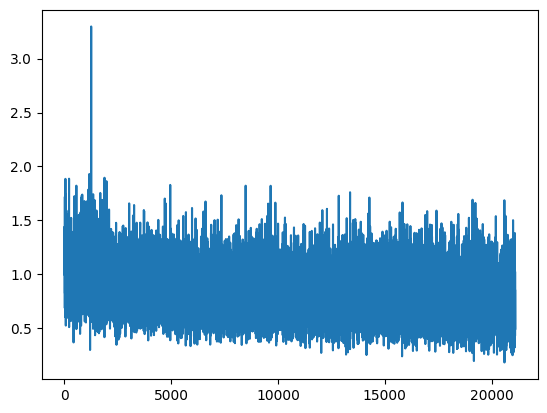

In [36]:
plt.plot(train_losses)

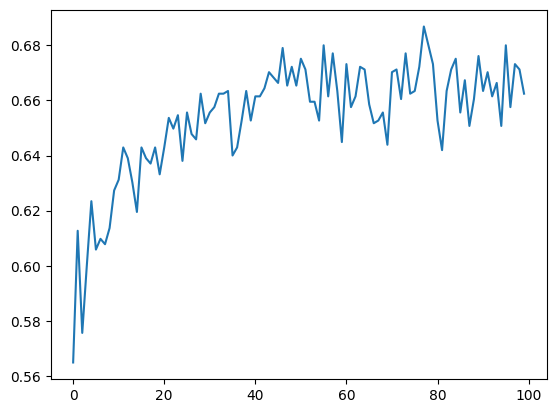

In [37]:
plt.plot(test_accuracy)

In [38]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 679/1024 (0.6631)
{'acc_detail': tensor([0.6391, 0.6623, 0.7736, 0.5774], device='cuda:0'),
 'acc_unweighted': tensor(0.6631, device='cuda:0'),
 'acc_weighted': tensor(0.6631, device='cuda:0'),
 'f1s': tensor(0.6626, device='cuda:0'),
 'f1s_detail': tensor([0.7143, 0.6101, 0.7455, 0.5806], device='cuda:0'),
 'precision_detail': tensor([0.8095, 0.5655, 0.7193, 0.5840], device='cuda:0'),
 'recall_detail': tensor([0.6391, 0.6623, 0.7736, 0.5774], device='cuda:0'),
 'rocauc': tensor([0.9222, 0.8672, 0.9293, 0.7921], device='cuda:0'),
 'uar': tensor(0.6631, device='cuda:0'),
 'wap': tensor(0.6735, device='cuda:0')}


tensor([[170,  21,   6,  69],
        [  3, 151,  41,  33],
        [  1,  52, 205,   7],
        [ 36,  43,  33, 153]], device='cuda:0')

In [39]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m18_best_78epoch.pt
Correct: 704/1024 (0.6875)
{'acc_detail': tensor([0.7632, 0.7763, 0.7358, 0.4868], device='cuda:0'),
 'acc_unweighted': tensor(0.6905, device='cuda:0'),
 'acc_weighted': tensor(0.6875, device='cuda:0'),
 'f1s': tensor(0.6849, device='cuda:0'),
 'f1s_detail': tensor([0.7719, 0.6448, 0.7692, 0.5536], device='cuda:0'),
 'precision_detail': tensor([0.7808, 0.5514, 0.8058, 0.6418], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.7763, 0.7358, 0.4868], device='cuda:0'),
 'rocauc': tensor([0.9330, 0.8676, 0.9343, 0.7862], device='cuda:0'),
 'uar': tensor(0.6905, device='cuda:0'),
 'wap': tensor(0.7002, device='cuda:0')}


tensor([[203,  21,   3,  39],
        [  4, 177,  24,  23],
        [  2,  58, 195,  10],
        [ 51,  65,  20, 129]], device='cuda:0')

In [40]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                           | 0.0036363636363636364/50 [00:00<1:09:16, 83.13s/it]

Train Epoch: 101 [0/3387 (0%)]	Loss: 0.664619
Mem before-during-after: 38443008 2661999104 45025792


  0%|▌                                                                                                                                                                            | 0.14909090909090902/50 [00:12<1:14:59, 90.25s/it]

Train Epoch: 101 [640/3387 (19%)]	Loss: 0.771352
Mem before-during-after: 44278272 2669469696 45182464


  1%|█                                                                                                                                                                            | 0.29454545454545467/50 [00:24<1:14:37, 90.09s/it]

Train Epoch: 101 [1280/3387 (38%)]	Loss: 0.528530
Mem before-during-after: 44389888 2668239360 44389888


  1%|█▌                                                                                                                                                                           | 0.44000000000000106/50 [00:36<1:15:50, 91.82s/it]

Train Epoch: 101 [1920/3387 (57%)]	Loss: 0.421891
Mem before-during-after: 44286464 2669182464 45263360


  1%|██                                                                                                                                                                            | 0.5854545454545474/50 [00:48<1:14:19, 90.24s/it]

Train Epoch: 101 [2560/3387 (76%)]	Loss: 0.941324
Mem before-during-after: 45294080 2667566592 44389888


  1%|██▌                                                                                                                                                                           | 0.7309090909090938/50 [01:00<1:13:36, 89.63s/it]

Train Epoch: 101 [3200/3387 (95%)]	Loss: 0.736327
Mem before-during-after: 44286464 2667535872 44286464


  2%|███▌                                                                                                                                                                            | 1.0000000000000047/50 [01:16<44:44, 54.78s/it]


Test Epoch: 101	Accuracy: 688/1024 (67%)



  2%|███▌                                                                                                                                                                            | 1.0036363636363683/50 [01:16<51:30, 63.07s/it]

Train Epoch: 102 [0/3387 (0%)]	Loss: 0.790505
Mem before-during-after: 44948992 2521805312 44389888


  2%|███▉                                                                                                                                                                          | 1.1490909090909147/50 [01:28<1:14:13, 91.16s/it]

Train Epoch: 102 [640/3387 (19%)]	Loss: 0.496603
Mem before-during-after: 44286464 2667406848 45263360


  3%|████▌                                                                                                                                                                          | 1.294545454545461/50 [01:40<1:11:46, 88.42s/it]

Train Epoch: 102 [1280/3387 (38%)]	Loss: 0.619437
Mem before-during-after: 44278272 2542775296 44677632


  3%|█████                                                                                                                                                                         | 1.4400000000000075/50 [01:52<1:12:15, 89.29s/it]

Train Epoch: 102 [1920/3387 (57%)]	Loss: 0.748899
Mem before-during-after: 44278272 2665862656 44278272


  3%|█████▌                                                                                                                                                                        | 1.5854545454545539/50 [02:04<1:12:58, 90.43s/it]

Train Epoch: 102 [2560/3387 (76%)]	Loss: 0.690265
Mem before-during-after: 44278272 2666502656 44278272


  3%|██████                                                                                                                                                                        | 1.7309090909091003/50 [02:16<1:12:29, 90.11s/it]

Train Epoch: 102 [3200/3387 (95%)]	Loss: 0.678526
Mem before-during-after: 44278272 2667556352 44278272


  4%|███████                                                                                                                                                                          | 2.000000000000011/50 [02:33<44:39, 55.82s/it]


Test Epoch: 102	Accuracy: 686/1024 (67%)



  4%|███████                                                                                                                                                                          | 2.007272727272738/50 [02:33<50:28, 63.09s/it]

Train Epoch: 103 [0/3387 (0%)]	Loss: 0.289945
Mem before-during-after: 44274176 2669603840 44278272


  4%|███████▌                                                                                                                                                                       | 2.149090909090912/50 [02:45<1:13:13, 91.81s/it]

Train Epoch: 103 [640/3387 (19%)]	Loss: 0.747451
Mem before-during-after: 44278272 2668598272 45182464


  5%|███████▉                                                                                                                                                                      | 2.2945454545454496/50 [02:57<1:12:20, 90.99s/it]

Train Epoch: 103 [1280/3387 (38%)]	Loss: 0.927827
Mem before-during-after: 44278272 2668112384 44278272


  5%|████████▌                                                                                                                                                                      | 2.439999999999987/50 [03:09<1:11:33, 90.27s/it]

Train Epoch: 103 [1920/3387 (57%)]	Loss: 0.782069
Mem before-during-after: 45182464 2669502464 45182464


  5%|████████▉                                                                                                                                                                     | 2.5854545454545246/50 [03:21<1:11:19, 90.25s/it]

Train Epoch: 103 [2560/3387 (76%)]	Loss: 1.080782
Mem before-during-after: 45066752 2659139584 44278272


  5%|█████████▌                                                                                                                                                                     | 2.730909090909062/50 [03:33<1:10:48, 89.87s/it]

Train Epoch: 103 [3200/3387 (95%)]	Loss: 0.833250
Mem before-during-after: 45182464 2520566784 44677632


  6%|██████████▌                                                                                                                                                                     | 2.9999999999999565/50 [03:50<42:56, 54.82s/it]


Test Epoch: 103	Accuracy: 694/1024 (68%)



  6%|██████████▌                                                                                                                                                                     | 3.0072727272726834/50 [03:50<48:11, 61.54s/it]

Train Epoch: 104 [0/3387 (0%)]	Loss: 0.781310
Mem before-during-after: 44274176 2669603840 44278272


  6%|██████████▉                                                                                                                                                                   | 3.1490909090908574/50 [04:02<1:10:36, 90.43s/it]

Train Epoch: 104 [640/3387 (19%)]	Loss: 0.792235
Mem before-during-after: 44278272 2668366848 44278272


  7%|███████████▌                                                                                                                                                                   | 3.294545454545395/50 [04:14<1:09:09, 88.84s/it]

Train Epoch: 104 [1280/3387 (38%)]	Loss: 0.893998
Mem before-during-after: 44278272 2668079616 44278272


  7%|███████████▉                                                                                                                                                                  | 3.4399999999999324/50 [04:26<1:10:10, 90.42s/it]

Train Epoch: 104 [1920/3387 (57%)]	Loss: 0.917379
Mem before-during-after: 45182464 2666535424 44278272


  7%|████████████▌                                                                                                                                                                   | 3.58545454545447/50 [04:37<1:08:56, 89.11s/it]

Train Epoch: 104 [2560/3387 (76%)]	Loss: 1.011663
Mem before-during-after: 44278272 2667271680 44278272


  7%|████████████▉                                                                                                                                                                 | 3.7309090909090075/50 [04:49<1:09:00, 89.48s/it]

Train Epoch: 104 [3200/3387 (95%)]	Loss: 0.422069
Mem before-during-after: 44278272 2667021312 44278272


  8%|██████████████▏                                                                                                                                                                  | 3.999999999999902/50 [05:05<41:40, 54.36s/it]


Test Epoch: 104	Accuracy: 691/1024 (67%)



  8%|██████████████▏                                                                                                                                                                  | 4.003636363636265/50 [05:05<48:53, 63.78s/it]

Train Epoch: 105 [0/3387 (0%)]	Loss: 1.006129
Mem before-during-after: 45021696 2577633792 44797440


  8%|██████████████▌                                                                                                                                                                | 4.149090909090821/50 [05:17<1:08:30, 89.65s/it]

Train Epoch: 105 [640/3387 (19%)]	Loss: 0.648388
Mem before-during-after: 44278272 2668079616 44278272


  9%|███████████████                                                                                                                                                                | 4.294545454545376/50 [05:30<1:15:59, 99.75s/it]

Train Epoch: 105 [1280/3387 (38%)]	Loss: 0.774890
Mem before-during-after: 45182464 2669469696 45182464


  9%|███████████████▌                                                                                                                                                               | 4.439999999999931/50 [05:42<1:08:11, 89.79s/it]

Train Epoch: 105 [1920/3387 (57%)]	Loss: 0.393245
Mem before-during-after: 44278272 2665862656 44278272


  9%|████████████████                                                                                                                                                               | 4.585454545454486/50 [05:54<1:09:38, 92.02s/it]

Train Epoch: 105 [2560/3387 (76%)]	Loss: 0.394271
Mem before-during-after: 44278272 2667271680 44278272


  9%|████████████████▌                                                                                                                                                              | 4.730909090909042/50 [06:06<1:09:33, 92.20s/it]

Train Epoch: 105 [3200/3387 (95%)]	Loss: 0.666537
Mem before-during-after: 45025792 2658908160 44278272


 10%|█████████████████▋                                                                                                                                                               | 4.999999999999969/50 [06:22<42:55, 57.23s/it]


Test Epoch: 105	Accuracy: 683/1024 (67%)



 10%|█████████████████▋                                                                                                                                                               | 5.003636363636333/50 [06:22<48:55, 65.25s/it]

Train Epoch: 106 [0/3387 (0%)]	Loss: 0.753570
Mem before-during-after: 44274176 2659533824 44699136


 10%|██████████████████                                                                                                                                                             | 5.149090909090888/50 [06:34<1:07:12, 89.91s/it]

Train Epoch: 106 [640/3387 (19%)]	Loss: 1.074210
Mem before-during-after: 44278272 2666631680 44278272


 11%|██████████████████▌                                                                                                                                                            | 5.294545454545443/50 [06:46<1:07:01, 89.96s/it]

Train Epoch: 106 [1280/3387 (38%)]	Loss: 0.384053
Mem before-during-after: 44278272 2667809792 44278272


 11%|███████████████████                                                                                                                                                            | 5.439999999999999/50 [06:58<1:06:50, 89.99s/it]

Train Epoch: 106 [1920/3387 (57%)]	Loss: 1.201552
Mem before-during-after: 44278272 2543142912 44278272


 11%|███████████████████▌                                                                                                                                                           | 5.585454545454554/50 [07:10<1:05:53, 89.01s/it]

Train Epoch: 106 [2560/3387 (76%)]	Loss: 0.307591
Mem before-during-after: 44278272 2667067392 44278272


 11%|████████████████████                                                                                                                                                           | 5.730909090909109/50 [07:22<1:06:43, 90.43s/it]

Train Epoch: 106 [3200/3387 (95%)]	Loss: 0.352842
Mem before-during-after: 45066752 2668366848 44278272


 12%|█████████████████████▏                                                                                                                                                           | 6.000000000000036/50 [07:38<41:35, 56.72s/it]


Test Epoch: 106	Accuracy: 680/1024 (66%)



 12%|█████████████████████▎                                                                                                                                                           | 6.007272727272764/50 [07:39<44:37, 60.87s/it]

Train Epoch: 107 [0/3387 (0%)]	Loss: 1.237424
Mem before-during-after: 45021696 2667698688 44278272


 12%|█████████████████████▌                                                                                                                                                         | 6.149090909090956/50 [07:51<1:06:29, 90.99s/it]

Train Epoch: 107 [640/3387 (19%)]	Loss: 0.583412
Mem before-during-after: 44278272 2668617216 44278272


 13%|██████████████████████                                                                                                                                                         | 6.294545454545511/50 [08:03<1:05:53, 90.46s/it]

Train Epoch: 107 [1280/3387 (38%)]	Loss: 0.543994
Mem before-during-after: 45182464 2669502464 45182464


 13%|██████████████████████▌                                                                                                                                                        | 6.440000000000066/50 [08:15<1:05:24, 90.10s/it]

Train Epoch: 107 [1920/3387 (57%)]	Loss: 0.658624
Mem before-during-after: 45182464 2666535424 44278272


 13%|███████████████████████                                                                                                                                                        | 6.585454545454621/50 [08:27<1:05:28, 90.48s/it]

Train Epoch: 107 [2560/3387 (76%)]	Loss: 1.056439
Mem before-during-after: 44278272 2667955712 44278272


 13%|███████████████████████▌                                                                                                                                                       | 6.730909090909177/50 [08:39<1:07:31, 93.64s/it]

Train Epoch: 107 [3200/3387 (95%)]	Loss: 0.808778
Mem before-during-after: 44389888 2666130944 44389888


 14%|████████████████████████▊                                                                                                                                                        | 7.000000000000104/50 [08:55<40:11, 56.08s/it]


Test Epoch: 107	Accuracy: 685/1024 (67%)



 14%|████████████████████████▊                                                                                                                                                        | 7.007272727272832/50 [08:55<45:02, 62.86s/it]

Train Epoch: 108 [0/3387 (0%)]	Loss: 0.984165
Mem before-during-after: 44948992 2666706432 44389888


 14%|█████████████████████████                                                                                                                                                      | 7.149090909091023/50 [09:07<1:03:56, 89.52s/it]

Train Epoch: 108 [640/3387 (19%)]	Loss: 0.556130
Mem before-during-after: 44278272 2667869696 44389888


 15%|█████████████████████████▌                                                                                                                                                     | 7.294545454545578/50 [09:19<1:04:05, 90.05s/it]

Train Epoch: 108 [1280/3387 (38%)]	Loss: 0.436727
Mem before-during-after: 44278272 2658684928 44942848


 15%|██████████████████████████                                                                                                                                                     | 7.440000000000134/50 [09:31<1:04:12, 90.53s/it]

Train Epoch: 108 [1920/3387 (57%)]	Loss: 0.778436
Mem before-during-after: 45294080 2660372480 45190656


 15%|██████████████████████████▌                                                                                                                                                    | 7.585454545454689/50 [09:43<1:04:00, 90.55s/it]

Train Epoch: 108 [2560/3387 (76%)]	Loss: 0.438748
Mem before-during-after: 45056512 2667470336 44389888


 15%|███████████████████████████                                                                                                                                                    | 7.730909090909244/50 [09:55<1:03:21, 89.92s/it]

Train Epoch: 108 [3200/3387 (95%)]	Loss: 0.580468
Mem before-during-after: 44278272 2658939904 44278272


 16%|████████████████████████████▍                                                                                                                                                     | 8.00000000000017/50 [10:12<39:03, 55.79s/it]


Test Epoch: 108	Accuracy: 692/1024 (68%)



 16%|████████████████████████████▎                                                                                                                                                    | 8.003636363636534/50 [10:12<44:45, 63.95s/it]

Train Epoch: 109 [0/3387 (0%)]	Loss: 0.844128
Mem before-during-after: 44274176 2659134464 44699136


 16%|████████████████████████████▋                                                                                                                                                   | 8.14909090909109/50 [10:24<1:01:59, 88.89s/it]

Train Epoch: 109 [640/3387 (19%)]	Loss: 0.949061
Mem before-during-after: 44278272 2658597888 44278272


 17%|█████████████████████████████                                                                                                                                                  | 8.294545454545645/50 [10:36<1:02:27, 89.86s/it]

Train Epoch: 109 [1280/3387 (38%)]	Loss: 0.620990
Mem before-during-after: 44278272 2667021312 44278272


 17%|█████████████████████████████▉                                                                                                                                                   | 8.4400000000002/50 [10:48<1:01:38, 89.00s/it]

Train Epoch: 109 [1920/3387 (57%)]	Loss: 0.692671
Mem before-during-after: 44278272 2610895360 44278272


 17%|██████████████████████████████                                                                                                                                                 | 8.585454545454756/50 [11:00<1:02:15, 90.19s/it]

Train Epoch: 109 [2560/3387 (76%)]	Loss: 0.473527
Mem before-during-after: 44278272 2666766848 44278272


 17%|██████████████████████████████▋                                                                                                                                                 | 8.73090909090931/50 [11:12<1:01:41, 89.69s/it]

Train Epoch: 109 [3200/3387 (95%)]	Loss: 0.621565
Mem before-during-after: 44389888 2667470336 46198272


 18%|███████████████████████████████▊                                                                                                                                                 | 9.000000000000238/50 [11:28<38:44, 56.70s/it]


Test Epoch: 109	Accuracy: 677/1024 (66%)



 18%|███████████████████████████████▊                                                                                                                                                 | 9.003636363636602/50 [11:29<44:10, 64.65s/it]

Train Epoch: 110 [0/3387 (0%)]	Loss: 0.536184
Mem before-during-after: 45956608 2668124672 44389888


 18%|████████████████████████████████                                                                                                                                               | 9.149090909091157/50 [11:40<1:01:13, 89.93s/it]

Train Epoch: 110 [640/3387 (19%)]	Loss: 0.193528
Mem before-during-after: 44278272 2666550784 44278272


 19%|████████████████████████████████▌                                                                                                                                              | 9.294545454545712/50 [11:52<1:00:20, 88.94s/it]

Train Epoch: 110 [1280/3387 (38%)]	Loss: 1.059203
Mem before-during-after: 44278272 2667302400 44278272


 19%|█████████████████████████████████                                                                                                                                              | 9.440000000000268/50 [12:04<1:01:19, 90.71s/it]

Train Epoch: 110 [1920/3387 (57%)]	Loss: 0.455557
Mem before-during-after: 44278272 2667753984 44927488


 19%|█████████████████████████████████▌                                                                                                                                             | 9.585454545454823/50 [12:16<1:00:32, 89.89s/it]

Train Epoch: 110 [2560/3387 (76%)]	Loss: 0.511142
Mem before-during-after: 45831680 2667634176 44927488


 19%|██████████████████████████████████                                                                                                                                             | 9.730909090909378/50 [12:28<1:01:09, 91.13s/it]

Train Epoch: 110 [3200/3387 (95%)]	Loss: 0.811607
Mem before-during-after: 45182464 2658516992 44389888


 20%|███████████████████████████████████▏                                                                                                                                            | 10.000000000000306/50 [12:44<37:26, 56.16s/it]


Test Epoch: 110	Accuracy: 678/1024 (66%)



 20%|███████████████████████████████████▍                                                                                                                                             | 10.00363636363667/50 [12:44<43:07, 64.69s/it]

Train Epoch: 111 [0/3387 (0%)]	Loss: 0.806252
Mem before-during-after: 45956608 2660190208 44810752


 20%|███████████████████████████████████▋                                                                                                                                            | 10.149090909091225/50 [12:56<59:29, 89.56s/it]

Train Epoch: 111 [640/3387 (19%)]	Loss: 0.522442
Mem before-during-after: 44389888 2667701760 44389888


 21%|████████████████████████████████████▍                                                                                                                                            | 10.29454545454578/50 [13:08<59:37, 90.11s/it]

Train Epoch: 111 [1280/3387 (38%)]	Loss: 0.602049
Mem before-during-after: 44758528 2658330624 44294144


 21%|████████████████████████████████████▋                                                                                                                                           | 10.440000000000335/50 [13:20<58:56, 89.39s/it]

Train Epoch: 111 [1920/3387 (57%)]	Loss: 0.429607
Mem before-during-after: 44278272 2668985856 45178368


 21%|█████████████████████████████████████▍                                                                                                                                           | 10.58545454545489/50 [13:32<59:32, 90.63s/it]

Train Epoch: 111 [2560/3387 (76%)]	Loss: 0.428712
Mem before-during-after: 44389888 2668206592 44389888


 21%|█████████████████████████████████████▊                                                                                                                                          | 10.730909090909446/50 [13:44<59:15, 90.53s/it]

Train Epoch: 111 [3200/3387 (95%)]	Loss: 0.292906
Mem before-during-after: 44278272 2667004416 45182464


 22%|██████████████████████████████████████▋                                                                                                                                         | 11.000000000000373/50 [14:01<35:36, 54.79s/it]


Test Epoch: 111	Accuracy: 682/1024 (67%)



 22%|██████████████████████████████████████▋                                                                                                                                         | 11.003636363636737/50 [14:01<42:12, 64.94s/it]

Train Epoch: 112 [0/3387 (0%)]	Loss: 0.740576
Mem before-during-after: 45956608 2660190208 44810752


 22%|███████████████████████████████████████▏                                                                                                                                        | 11.149090909091292/50 [14:13<59:20, 91.65s/it]

Train Epoch: 112 [640/3387 (19%)]	Loss: 0.509447
Mem before-during-after: 45294080 2667566592 44389888


 23%|███████████████████████████████████████▊                                                                                                                                        | 11.294545454545847/50 [14:25<57:59, 89.90s/it]

Train Epoch: 112 [1280/3387 (38%)]	Loss: 0.713821
Mem before-during-after: 44389888 2667404800 44927488


 23%|████████████████████████████████████████▎                                                                                                                                       | 11.440000000000403/50 [14:37<57:18, 89.18s/it]

Train Epoch: 112 [1920/3387 (57%)]	Loss: 1.214347
Mem before-during-after: 44286464 2657858560 44278272


 23%|████████████████████████████████████████▊                                                                                                                                       | 11.585454545454958/50 [14:49<57:26, 89.72s/it]

Train Epoch: 112 [2560/3387 (76%)]	Loss: 0.932584
Mem before-during-after: 44278272 2658597888 44278272


 23%|████████████████████████████████████████▊                                                                                                                                     | 11.730909090909513/50 [15:01<1:00:16, 94.50s/it]

Train Epoch: 112 [3200/3387 (95%)]	Loss: 0.733575
Mem before-during-after: 44278272 2667021312 44278272


 24%|██████████████████████████████████████████▍                                                                                                                                      | 12.00000000000044/50 [15:17<35:56, 56.74s/it]


Test Epoch: 112	Accuracy: 674/1024 (66%)



 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.007272727273168/50 [15:18<39:01, 61.62s/it]

Train Epoch: 113 [0/3387 (0%)]	Loss: 0.684580
Mem before-during-after: 44274176 2669603840 44278272


 24%|███████████████████████████████████████████                                                                                                                                      | 12.14909090909136/50 [15:29<56:19, 89.29s/it]

Train Epoch: 113 [640/3387 (19%)]	Loss: 0.749632
Mem before-during-after: 44278272 2659853824 44278272


 25%|███████████████████████████████████████████▎                                                                                                                                    | 12.294545454545915/50 [15:42<56:46, 90.34s/it]

Train Epoch: 113 [1280/3387 (38%)]	Loss: 0.458816
Mem before-during-after: 45182464 2666535424 44278272


 25%|████████████████████████████████████████████                                                                                                                                     | 12.44000000000047/50 [15:54<56:50, 90.79s/it]

Train Epoch: 113 [1920/3387 (57%)]	Loss: 0.559304
Mem before-during-after: 44389888 2666774016 44278272


 25%|████████████████████████████████████████████▎                                                                                                                                   | 12.585454545455026/50 [16:06<57:19, 91.93s/it]

Train Epoch: 113 [2560/3387 (76%)]	Loss: 0.644231
Mem before-during-after: 45960704 2667701760 45294080


 25%|█████████████████████████████████████████████                                                                                                                                    | 12.73090909090958/50 [16:18<55:15, 88.97s/it]

Train Epoch: 113 [3200/3387 (95%)]	Loss: 0.827276
Mem before-during-after: 45294080 2667900416 45960704


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.000000000000508/50 [16:34<35:20, 57.30s/it]


Test Epoch: 113	Accuracy: 684/1024 (67%)



 26%|█████████████████████████████████████████████▊                                                                                                                                  | 13.003636363636872/50 [16:34<39:32, 64.12s/it]

Train Epoch: 114 [0/3387 (0%)]	Loss: 1.432437
Mem before-during-after: 44274176 2349889024 44278272


 26%|██████████████████████████████████████████████▎                                                                                                                                 | 13.149090909091427/50 [16:46<55:04, 89.67s/it]

Train Epoch: 114 [640/3387 (19%)]	Loss: 0.440077
Mem before-during-after: 44953088 2667035648 44278272


 27%|██████████████████████████████████████████████▊                                                                                                                                 | 13.294545454545982/50 [16:58<54:33, 89.17s/it]

Train Epoch: 114 [1280/3387 (38%)]	Loss: 0.539964
Mem before-during-after: 45182464 2668914176 45263360


 27%|███████████████████████████████████████████████▎                                                                                                                                | 13.440000000000538/50 [17:10<54:39, 89.70s/it]

Train Epoch: 114 [1920/3387 (57%)]	Loss: 0.850745
Mem before-during-after: 44389888 2658948096 44286464


 27%|███████████████████████████████████████████████▊                                                                                                                                | 13.585454545455093/50 [17:22<54:54, 90.47s/it]

Train Epoch: 114 [2560/3387 (76%)]	Loss: 0.758470
Mem before-during-after: 45182464 2668208640 45263360


 27%|████████████████████████████████████████████████▎                                                                                                                               | 13.730909090909648/50 [17:34<53:29, 88.49s/it]

Train Epoch: 114 [3200/3387 (95%)]	Loss: 0.379669
Mem before-during-after: 44570112 2668180992 44278272


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.000000000000576/50 [17:50<33:33, 55.93s/it]


Test Epoch: 114	Accuracy: 677/1024 (66%)



 28%|█████████████████████████████████████████████████▌                                                                                                                               | 14.00363636363694/50 [17:50<39:05, 65.15s/it]

Train Epoch: 115 [0/3387 (0%)]	Loss: 0.466960
Mem before-during-after: 44754432 2668098048 44389888


 28%|█████████████████████████████████████████████████▊                                                                                                                              | 14.149090909091495/50 [18:02<53:52, 90.16s/it]

Train Epoch: 115 [640/3387 (19%)]	Loss: 0.714208
Mem before-during-after: 45831680 2668110336 45182464


 29%|██████████████████████████████████████████████████▌                                                                                                                              | 14.29454545454605/50 [18:14<53:45, 90.32s/it]

Train Epoch: 115 [1280/3387 (38%)]	Loss: 0.636801
Mem before-during-after: 44278272 2667535872 45182464


 29%|██████████████████████████████████████████████████▊                                                                                                                             | 14.440000000000605/50 [18:26<52:18, 88.25s/it]

Train Epoch: 115 [1920/3387 (57%)]	Loss: 0.549959
Mem before-during-after: 44278272 2658988032 44278272


 29%|███████████████████████████████████████████████████▋                                                                                                                             | 14.58545454545516/50 [18:38<53:02, 89.85s/it]

Train Epoch: 115 [2560/3387 (76%)]	Loss: 0.327030
Mem before-during-after: 44278272 2667271680 44278272


 29%|███████████████████████████████████████████████████▊                                                                                                                            | 14.730909090909716/50 [18:50<52:30, 89.32s/it]

Train Epoch: 115 [3200/3387 (95%)]	Loss: 0.441323
Mem before-during-after: 44278272 2668440064 45182464


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.000000000000643/50 [19:07<33:39, 57.69s/it]


Test Epoch: 115	Accuracy: 695/1024 (68%)



 30%|█████████████████████████████████████████████████████▏                                                                                                                           | 15.00727272727337/50 [19:07<36:13, 62.10s/it]

Train Epoch: 116 [0/3387 (0%)]	Loss: 0.430718
Mem before-during-after: 45021696 2667698688 44278272


 30%|█████████████████████████████████████████████████████▎                                                                                                                          | 15.149090909091562/50 [19:19<52:13, 89.91s/it]

Train Epoch: 116 [640/3387 (19%)]	Loss: 0.286640
Mem before-during-after: 44278272 2667669504 44278272


 31%|█████████████████████████████████████████████████████▊                                                                                                                          | 15.294545454546117/50 [19:31<52:33, 90.86s/it]

Train Epoch: 116 [1280/3387 (38%)]	Loss: 0.478209
Mem before-during-after: 44278272 2668112384 44278272


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.440000000000673/50 [19:43<52:02, 90.34s/it]

Train Epoch: 116 [1920/3387 (57%)]	Loss: 0.585492
Mem before-during-after: 44278272 2666502656 44278272


 31%|██████████████████████████████████████████████████████▊                                                                                                                         | 15.585454545455228/50 [19:55<51:17, 89.43s/it]

Train Epoch: 116 [2560/3387 (76%)]	Loss: 0.771671
Mem before-during-after: 44278272 2666631680 44278272


 31%|███████████████████████████████████████████████████████▎                                                                                                                        | 15.730909090909783/50 [20:07<51:20, 89.90s/it]

Train Epoch: 116 [3200/3387 (95%)]	Loss: 0.684588
Mem before-during-after: 44278272 2667271680 44278272


 32%|████████████████████████████████████████████████████████▋                                                                                                                        | 16.00000000000071/50 [20:23<30:15, 53.41s/it]


Test Epoch: 116	Accuracy: 671/1024 (65%)



 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.003636363637074/50 [20:23<35:37, 62.87s/it]

Train Epoch: 117 [0/3387 (0%)]	Loss: 0.708256
Mem before-during-after: 44274176 2669603840 44278272


 32%|█████████████████████████████████████████████████████████▏                                                                                                                       | 16.14909090909163/50 [20:35<50:26, 89.40s/it]

Train Epoch: 117 [640/3387 (19%)]	Loss: 0.515320
Mem before-during-after: 44278272 2668598272 44278272


 33%|█████████████████████████████████████████████████████████▎                                                                                                                      | 16.294545454546185/50 [20:47<49:42, 88.47s/it]

Train Epoch: 117 [1280/3387 (38%)]	Loss: 0.757008
Mem before-during-after: 44927488 2521547264 44927488


 33%|██████████████████████████████████████████████████████████▏                                                                                                                      | 16.44000000000074/50 [20:59<49:56, 89.29s/it]

Train Epoch: 117 [1920/3387 (57%)]	Loss: 0.339528
Mem before-during-after: 44278272 2658516992 44278272


 33%|██████████████████████████████████████████████████████████▍                                                                                                                     | 16.585454545455296/50 [21:11<49:45, 89.34s/it]

Train Epoch: 117 [2560/3387 (76%)]	Loss: 0.351398
Mem before-during-after: 44953088 2666766848 45263360


 33%|███████████████████████████████████████████████████████████▏                                                                                                                     | 16.73090909090985/50 [21:23<49:41, 89.62s/it]

Train Epoch: 117 [3200/3387 (95%)]	Loss: 0.546731
Mem before-during-after: 44389888 2667701760 44389888


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.000000000000778/50 [21:39<30:19, 55.14s/it]


Test Epoch: 117	Accuracy: 688/1024 (67%)



 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.003636363637142/50 [21:39<36:22, 66.15s/it]

Train Epoch: 118 [0/3387 (0%)]	Loss: 0.621620
Mem before-during-after: 44923392 2658615296 44810752


 34%|████████████████████████████████████████████████████████████▎                                                                                                                   | 17.149090909091697/50 [21:51<49:31, 90.47s/it]

Train Epoch: 118 [640/3387 (19%)]	Loss: 0.616453
Mem before-during-after: 44278272 2668031488 44278272


 35%|████████████████████████████████████████████████████████████▉                                                                                                                   | 17.294545454546252/50 [22:04<50:46, 93.15s/it]

Train Epoch: 118 [1280/3387 (38%)]	Loss: 0.374785
Mem before-during-after: 44278272 2668311040 44927488


 35%|█████████████████████████████████████████████████████████████▍                                                                                                                  | 17.440000000000808/50 [22:16<49:49, 91.81s/it]

Train Epoch: 118 [1920/3387 (57%)]	Loss: 0.607023
Mem before-during-after: 44278272 2668881408 45374976


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                  | 17.585454545455363/50 [22:29<48:06, 89.06s/it]

Train Epoch: 118 [2560/3387 (76%)]	Loss: 0.759408
Mem before-during-after: 44389888 2666092032 44734976


 35%|██████████████████████████████████████████████████████████████▊                                                                                                                  | 17.73090909090992/50 [22:41<51:11, 95.18s/it]

Train Epoch: 118 [3200/3387 (95%)]	Loss: 0.662312
Mem before-during-after: 44758528 2658330624 44310016


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 18.000000000000846/50 [22:57<30:49, 57.79s/it]


Test Epoch: 118	Accuracy: 672/1024 (66%)



 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.007272727273573/50 [22:57<33:07, 62.14s/it]

Train Epoch: 119 [0/3387 (0%)]	Loss: 0.318631
Mem before-during-after: 44948992 2666706432 44389888


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                | 18.149090909091765/50 [23:09<48:15, 90.89s/it]

Train Epoch: 119 [640/3387 (19%)]	Loss: 0.943385
Mem before-during-after: 44677120 2659474432 44389888


 37%|████████████████████████████████████████████████████████████████▊                                                                                                                | 18.29454545454632/50 [23:21<47:54, 90.66s/it]

Train Epoch: 119 [1280/3387 (38%)]	Loss: 0.381097
Mem before-during-after: 44286464 2667004416 44286464


 37%|████████████████████████████████████████████████████████████████▉                                                                                                               | 18.440000000000875/50 [23:34<47:21, 90.03s/it]

Train Epoch: 119 [1920/3387 (57%)]	Loss: 0.620812
Mem before-during-after: 44278272 2658654208 44278272


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                               | 18.58545454545543/50 [23:46<47:45, 91.23s/it]

Train Epoch: 119 [2560/3387 (76%)]	Loss: 0.445490
Mem before-during-after: 44389888 2658676736 44389888


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                              | 18.730909090909986/50 [23:58<48:13, 92.55s/it]

Train Epoch: 119 [3200/3387 (95%)]	Loss: 0.552275
Mem before-during-after: 44389888 2668804608 45294080


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                             | 19.000000000000913/50 [24:14<30:11, 58.43s/it]


Test Epoch: 119	Accuracy: 697/1024 (68%)



 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00727272727364/50 [24:15<32:20, 62.63s/it]

Train Epoch: 120 [0/3387 (0%)]	Loss: 0.495815
Mem before-during-after: 44274176 2667617792 45056512


 38%|███████████████████████████████████████████████████████████████████▍                                                                                                            | 19.149090909091832/50 [24:27<46:30, 90.44s/it]

Train Epoch: 120 [640/3387 (19%)]	Loss: 0.534513
Mem before-during-after: 45494272 2658828800 44278272


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                            | 19.294545454546387/50 [24:39<46:00, 89.89s/it]

Train Epoch: 120 [1280/3387 (38%)]	Loss: 0.608914
Mem before-during-after: 44278272 2667004416 45182464


 39%|████████████████████████████████████████████████████████████████████▍                                                                                                           | 19.440000000000943/50 [24:51<45:36, 89.54s/it]

Train Epoch: 120 [1920/3387 (57%)]	Loss: 0.571534
Mem before-during-after: 44278272 2492895232 45123072


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                           | 19.585454545455498/50 [25:03<47:17, 93.29s/it]

Train Epoch: 120 [2560/3387 (76%)]	Loss: 0.627997
Mem before-during-after: 45294080 2667707904 45294080


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                          | 19.730909090910053/50 [25:16<46:09, 91.50s/it]

Train Epoch: 120 [3200/3387 (95%)]	Loss: 0.525225
Mem before-during-after: 45294080 2659458048 45294080


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00000000000098/50 [25:32<28:02, 56.09s/it]


Test Epoch: 120	Accuracy: 668/1024 (65%)



 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 20.003636363637344/50 [25:33<33:38, 67.28s/it]

Train Epoch: 121 [0/3387 (0%)]	Loss: 0.758639
Mem before-during-after: 44385792 2667047424 44278272


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                          | 20.1490909090919/50 [25:45<45:04, 90.58s/it]

Train Epoch: 121 [640/3387 (19%)]	Loss: 0.485568
Mem before-during-after: 44278272 2658366464 44278272


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                        | 20.294545454546455/50 [25:57<44:56, 90.76s/it]

Train Epoch: 121 [1280/3387 (38%)]	Loss: 0.638634
Mem before-during-after: 44278272 2577609728 44278272


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.44000000000101/50 [26:09<44:54, 91.15s/it]

Train Epoch: 121 [1920/3387 (57%)]	Loss: 0.621137
Mem before-during-after: 44278272 2667021312 44278272


 41%|████████████████████████████████████████████████████████████████████████                                                                                                       | 20.585454545455566/50 [26:22<52:02, 106.15s/it]

Train Epoch: 121 [2560/3387 (76%)]	Loss: 0.357497
Mem before-during-after: 44278272 2666631680 44278272


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                       | 20.73090909091012/50 [26:34<43:51, 89.89s/it]

Train Epoch: 121 [3200/3387 (95%)]	Loss: 0.981231
Mem before-during-after: 44927488 2669007360 45831680


 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.000000000001048/50 [26:50<26:14, 54.28s/it]


Test Epoch: 121	Accuracy: 677/1024 (66%)



 42%|█████████████████████████████████████████████████████████████████████████▉                                                                                                      | 21.003636363637412/50 [26:50<30:57, 64.06s/it]

Train Epoch: 122 [0/3387 (0%)]	Loss: 0.667488
Mem before-during-after: 44940800 2667087872 44278272


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                     | 21.149090909091967/50 [27:02<43:22, 90.19s/it]

Train Epoch: 122 [640/3387 (19%)]	Loss: 0.479163
Mem before-during-after: 44278272 2666535424 44278272


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                     | 21.294545454546522/50 [27:14<43:09, 90.22s/it]

Train Epoch: 122 [1280/3387 (38%)]	Loss: 0.856293
Mem before-during-after: 44278272 2659139584 45025792


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 21.440000000001078/50 [27:26<43:54, 92.24s/it]

Train Epoch: 122 [1920/3387 (57%)]	Loss: 0.760651
Mem before-during-after: 45182464 2667977216 44278272


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                    | 21.585454545455633/50 [27:38<42:55, 90.63s/it]

Train Epoch: 122 [2560/3387 (76%)]	Loss: 0.454656
Mem before-during-after: 44278272 2659571712 44278272


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 21.73090909091019/50 [27:50<42:28, 90.15s/it]

Train Epoch: 122 [3200/3387 (95%)]	Loss: 0.554276
Mem before-during-after: 44286464 2667535872 44286464


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.000000000001116/50 [28:07<26:19, 56.40s/it]


Test Epoch: 122	Accuracy: 687/1024 (67%)



 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 22.00363636363748/50 [28:07<30:04, 64.45s/it]

Train Epoch: 123 [0/3387 (0%)]	Loss: 0.679839
Mem before-during-after: 45956608 2668909056 44278272


 44%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 22.149090909092035/50 [28:19<42:26, 91.44s/it]

Train Epoch: 123 [640/3387 (19%)]	Loss: 0.932191
Mem before-during-after: 44389888 2667572736 44927488


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 22.29454545454659/50 [28:31<42:04, 91.13s/it]

Train Epoch: 123 [1280/3387 (38%)]	Loss: 0.287929
Mem before-during-after: 45182464 2669502464 45182464


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.440000000001145/50 [28:43<42:39, 92.86s/it]

Train Epoch: 123 [1920/3387 (57%)]	Loss: 0.777131
Mem before-during-after: 44278272 2668079616 44278272


 45%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 22.5854545454557/50 [28:55<41:22, 90.54s/it]

Train Epoch: 123 [2560/3387 (76%)]	Loss: 0.687644
Mem before-during-after: 44677632 2667051520 44278272


 45%|████████████████████████████████████████████████████████████████████████████████                                                                                                | 22.730909090910256/50 [29:08<40:49, 89.83s/it]

Train Epoch: 123 [3200/3387 (95%)]	Loss: 0.549762
Mem before-during-after: 44278272 2658597888 44278272


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.000000000001183/50 [29:24<25:30, 56.69s/it]


Test Epoch: 123	Accuracy: 676/1024 (66%)



 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.003636363637547/50 [29:24<28:48, 64.02s/it]

Train Epoch: 124 [0/3387 (0%)]	Loss: 0.440926
Mem before-during-after: 44274176 2659533824 44699136


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 23.149090909092102/50 [29:36<40:34, 90.67s/it]

Train Epoch: 124 [640/3387 (19%)]	Loss: 0.374987
Mem before-during-after: 44278272 2668482560 44278272


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 23.294545454546657/50 [29:48<40:01, 89.94s/it]

Train Epoch: 124 [1280/3387 (38%)]	Loss: 0.384181
Mem before-during-after: 44278272 2667271680 44278272


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 23.440000000001213/50 [30:00<40:10, 90.74s/it]

Train Epoch: 124 [1920/3387 (57%)]	Loss: 0.463467
Mem before-during-after: 44389888 2668239360 44389888


 47%|███████████████████████████████████████████████████████████████████████████████████                                                                                             | 23.585454545455768/50 [30:12<39:33, 89.87s/it]

Train Epoch: 124 [2560/3387 (76%)]	Loss: 0.993343
Mem before-during-after: 44914688 2543468032 44278272


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 23.730909090910323/50 [30:24<39:40, 90.63s/it]

Train Epoch: 124 [3200/3387 (95%)]	Loss: 0.441309
Mem before-during-after: 44278272 2667439616 45294080


 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24.00000000000125/50 [30:41<24:18, 56.09s/it]


Test Epoch: 124	Accuracy: 701/1024 (68%)



 48%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 24.00727272727398/50 [30:41<27:26, 63.33s/it]

Train Epoch: 125 [0/3387 (0%)]	Loss: 0.427710
Mem before-during-after: 44923392 2668267008 45056512


 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 24.14909090909217/50 [30:53<40:45, 94.62s/it]

Train Epoch: 125 [640/3387 (19%)]	Loss: 0.660780
Mem before-during-after: 44389888 2669533184 45831680


 49%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.294545454546725/50 [31:05<38:31, 89.94s/it]

Train Epoch: 125 [1280/3387 (38%)]	Loss: 0.581754
Mem before-during-after: 44278272 2666421760 44278272


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24.44000000000128/50 [31:17<39:01, 91.59s/it]

Train Epoch: 125 [1920/3387 (57%)]	Loss: 0.343763
Mem before-during-after: 44286464 2666740224 44286464


 49%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24.585454545455836/50 [31:29<38:02, 89.83s/it]

Train Epoch: 125 [2560/3387 (76%)]	Loss: 0.387254
Mem before-during-after: 44734976 2667749888 45523456


 49%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 24.73090909091039/50 [31:41<38:21, 91.09s/it]

Train Epoch: 125 [3200/3387 (95%)]	Loss: 0.647591
Mem before-during-after: 44278272 2657850368 44278272


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.000000000001318/50 [31:57<22:46, 54.66s/it]


Test Epoch: 125	Accuracy: 661/1024 (64%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.007272727274046/50 [31:58<25:43, 61.76s/it]

Train Epoch: 126 [0/3387 (0%)]	Loss: 0.504342
Mem before-during-after: 44274176 2668017152 44389888


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 25.149090909092237/50 [32:10<37:06, 89.61s/it]

Train Epoch: 126 [640/3387 (19%)]	Loss: 1.156080
Mem before-during-after: 44278272 2657931264 44389888


 51%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25.294545454546792/50 [32:22<37:00, 89.86s/it]

Train Epoch: 126 [1280/3387 (38%)]	Loss: 0.868399
Mem before-during-after: 44927488 2666533376 44389888


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 25.440000000001348/50 [32:34<37:15, 91.03s/it]

Train Epoch: 126 [1920/3387 (57%)]	Loss: 0.806812
Mem before-during-after: 44278272 2667677184 44278272


 51%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.585454545455903/50 [32:46<36:32, 89.79s/it]

Train Epoch: 126 [2560/3387 (76%)]	Loss: 0.604800
Mem before-during-after: 44278272 2666550784 44278272


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 25.73090909091046/50 [32:58<36:31, 90.28s/it]

Train Epoch: 126 [3200/3387 (95%)]	Loss: 0.788478
Mem before-during-after: 44286464 2667535872 44286464


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.000000000001386/50 [33:14<22:27, 56.16s/it]


Test Epoch: 126	Accuracy: 655/1024 (64%)



 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 26.00363636363775/50 [33:14<25:30, 63.78s/it]

Train Epoch: 127 [0/3387 (0%)]	Loss: 0.510524
Mem before-during-after: 44923392 2668267008 45217280


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 26.149090909092305/50 [33:26<36:01, 90.64s/it]

Train Epoch: 127 [640/3387 (19%)]	Loss: 0.609252
Mem before-during-after: 44389888 2667870720 44389888


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 26.29454545454686/50 [33:38<35:28, 89.80s/it]

Train Epoch: 127 [1280/3387 (38%)]	Loss: 0.284673
Mem before-during-after: 45263360 2667373056 44278272


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 26.440000000001415/50 [33:50<35:44, 91.03s/it]

Train Epoch: 127 [1920/3387 (57%)]	Loss: 0.988762
Mem before-during-after: 44286464 2668297728 44286464


 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 26.58545454545597/50 [34:02<35:48, 91.76s/it]

Train Epoch: 127 [2560/3387 (76%)]	Loss: 0.584689
Mem before-during-after: 44286464 2667535872 44286464


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 26.73454545454689/50 [34:14<30:44, 79.27s/it]

Train Epoch: 127 [3200/3387 (95%)]	Loss: 0.640846
Mem before-during-after: 44389888 2666130944 44389888


 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.000000000001453/50 [34:30<21:10, 55.24s/it]


Test Epoch: 127	Accuracy: 688/1024 (67%)



 54%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 27.003636363637817/50 [34:31<24:31, 63.99s/it]

Train Epoch: 128 [0/3387 (0%)]	Loss: 0.837256
Mem before-during-after: 44938752 2667831808 44921344


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.149090909092372/50 [34:43<34:13, 89.87s/it]

Train Epoch: 128 [640/3387 (19%)]	Loss: 0.835386
Mem before-during-after: 44389888 2668575232 44278272


 55%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 27.294545454546927/50 [34:55<33:58, 89.80s/it]

Train Epoch: 128 [1280/3387 (38%)]	Loss: 0.271665
Mem before-during-after: 45294080 2668275200 46198272


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 27.440000000001483/50 [35:07<33:45, 89.79s/it]

Train Epoch: 128 [1920/3387 (57%)]	Loss: 0.435272
Mem before-during-after: 44389888 2667804160 44389888


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 27.585454545456038/50 [35:19<33:36, 89.95s/it]

Train Epoch: 128 [2560/3387 (76%)]	Loss: 0.963963
Mem before-during-after: 44278272 2668775936 45182464


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 27.730909090910593/50 [35:31<34:06, 91.88s/it]

Train Epoch: 128 [3200/3387 (95%)]	Loss: 0.778044
Mem before-during-after: 44278272 2667102720 44278272


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 28.00000000000152/50 [35:47<20:30, 55.95s/it]


Test Epoch: 128	Accuracy: 680/1024 (66%)



 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00727272727425/50 [35:47<22:39, 61.83s/it]

Train Epoch: 129 [0/3387 (0%)]	Loss: 0.355483
Mem before-during-after: 44274176 2669603840 44278272


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 28.14909090909244/50 [35:59<32:53, 90.30s/it]

Train Epoch: 129 [640/3387 (19%)]	Loss: 0.427919
Mem before-during-after: 44278272 2668440064 45182464


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.294545454546995/50 [36:11<32:15, 89.16s/it]

Train Epoch: 129 [1280/3387 (38%)]	Loss: 1.404062
Mem before-during-after: 44278272 2610895360 44278272


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 28.44000000000155/50 [36:23<32:08, 89.43s/it]

Train Epoch: 129 [1920/3387 (57%)]	Loss: 0.571345
Mem before-during-after: 45182464 2667977216 44278272


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 28.585454545456106/50 [36:35<32:41, 91.57s/it]

Train Epoch: 129 [2560/3387 (76%)]	Loss: 0.242491
Mem before-during-after: 45182464 2669502464 45182464


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 28.73090909091066/50 [36:47<32:13, 90.91s/it]

Train Epoch: 129 [3200/3387 (95%)]	Loss: 0.380207
Mem before-during-after: 45182464 2669502464 45182464


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 29.000000000001588/50 [37:03<19:41, 56.25s/it]


Test Epoch: 129	Accuracy: 683/1024 (67%)



 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 29.003636363637952/50 [37:04<22:23, 64.00s/it]

Train Epoch: 130 [0/3387 (0%)]	Loss: 1.106804
Mem before-during-after: 44274176 2641668608 44278272


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 29.149090909092507/50 [37:16<31:35, 90.89s/it]

Train Epoch: 130 [640/3387 (19%)]	Loss: 0.684939
Mem before-during-after: 45182464 2660043776 45182464


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 29.294545454547062/50 [37:28<31:23, 90.98s/it]

Train Epoch: 130 [1280/3387 (38%)]	Loss: 0.487395
Mem before-during-after: 44944896 2668079616 44278272


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 29.440000000001618/50 [37:40<31:22, 91.54s/it]

Train Epoch: 130 [1920/3387 (57%)]	Loss: 0.287174
Mem before-during-after: 44389888 2657730560 44804608


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.585454545456173/50 [37:52<30:44, 90.34s/it]

Train Epoch: 130 [2560/3387 (76%)]	Loss: 0.812232
Mem before-during-after: 46198272 2611381248 45294080


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 29.73090909091073/50 [38:04<31:16, 92.60s/it]

Train Epoch: 130 [3200/3387 (95%)]	Loss: 0.482488
Mem before-during-after: 45294080 2667566592 46198272


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 30.000000000001656/50 [38:21<18:41, 56.06s/it]


Test Epoch: 130	Accuracy: 680/1024 (66%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 30.00363636363802/50 [38:21<21:17, 63.89s/it]

Train Epoch: 131 [0/3387 (0%)]	Loss: 0.585302
Mem before-during-after: 44923392 2667816448 44921344


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 30.149090909092575/50 [38:33<30:13, 91.36s/it]

Train Epoch: 131 [640/3387 (19%)]	Loss: 0.903311
Mem before-during-after: 44389888 2659532800 44278272


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 30.29454545454713/50 [38:45<29:51, 90.90s/it]

Train Epoch: 131 [1280/3387 (38%)]	Loss: 0.971611
Mem before-during-after: 44278272 2577559552 44278272


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 30.440000000001685/50 [38:58<29:47, 91.37s/it]

Train Epoch: 131 [1920/3387 (57%)]	Loss: 0.777827
Mem before-during-after: 44278272 2668598272 45182464


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 30.58545454545624/50 [39:10<29:14, 90.36s/it]

Train Epoch: 131 [2560/3387 (76%)]	Loss: 0.403719
Mem before-during-after: 44278272 2668598272 45182464


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 30.730909090910796/50 [39:22<28:59, 90.26s/it]

Train Epoch: 131 [3200/3387 (95%)]	Loss: 0.710861
Mem before-during-after: 44278272 2669469696 45182464


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 31.000000000001723/50 [39:38<17:29, 55.22s/it]


Test Epoch: 131	Accuracy: 676/1024 (66%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.003636363638087/50 [39:38<20:13, 63.87s/it]

Train Epoch: 132 [0/3387 (0%)]	Loss: 0.955154
Mem before-during-after: 44274176 2669603840 44278272


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 31.149090909092642/50 [39:50<28:17, 90.06s/it]

Train Epoch: 132 [640/3387 (19%)]	Loss: 0.836063
Mem before-during-after: 44278272 2667084800 44278272


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 31.294545454547197/50 [40:02<28:26, 91.24s/it]

Train Epoch: 132 [1280/3387 (38%)]	Loss: 0.594800
Mem before-during-after: 44278272 2659220480 45025792


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 31.440000000001753/50 [40:14<27:58, 90.45s/it]

Train Epoch: 132 [1920/3387 (57%)]	Loss: 0.919484
Mem before-during-after: 44278272 2668196352 44278272


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 31.585454545456308/50 [40:26<27:35, 89.90s/it]

Train Epoch: 132 [2560/3387 (76%)]	Loss: 0.336304
Mem before-during-after: 44278272 2667271680 44278272


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 31.730909090910863/50 [40:38<27:28, 90.22s/it]

Train Epoch: 132 [3200/3387 (95%)]	Loss: 0.650761
Mem before-during-after: 44278272 2668366848 44278272


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00000000000179/50 [40:54<16:18, 54.37s/it]


Test Epoch: 132	Accuracy: 672/1024 (66%)



 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00363636363815/50 [40:54<19:01, 63.42s/it]

Train Epoch: 133 [0/3387 (0%)]	Loss: 0.468139
Mem before-during-after: 45021696 2667698688 44278272


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 32.149090909092564/50 [41:06<26:45, 89.93s/it]

Train Epoch: 133 [640/3387 (19%)]	Loss: 0.445724
Mem before-during-after: 45182464 2667977216 44278272


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32.29454545454698/50 [41:19<26:37, 90.25s/it]

Train Epoch: 133 [1280/3387 (38%)]	Loss: 0.350278
Mem before-during-after: 44278272 2667156480 44278272


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 32.44000000000139/50 [41:31<26:45, 91.44s/it]

Train Epoch: 133 [1920/3387 (57%)]	Loss: 0.823382
Mem before-during-after: 44278272 2666766848 44278272


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 32.585454545455804/50 [41:43<25:21, 87.39s/it]

Train Epoch: 133 [2560/3387 (76%)]	Loss: 1.065902
Mem before-during-after: 44278272 2521558016 44278272


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 32.73090909091022/50 [41:55<26:17, 91.35s/it]

Train Epoch: 133 [3200/3387 (95%)]	Loss: 0.643212
Mem before-during-after: 45182464 2668313088 44278272


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00000000000088/50 [42:11<15:32, 54.84s/it]


Test Epoch: 133	Accuracy: 681/1024 (66%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00363636363724/50 [42:11<18:10, 64.18s/it]

Train Epoch: 134 [0/3387 (0%)]	Loss: 0.358060
Mem before-during-after: 44274176 2669603840 44278272


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 33.149090909091655/50 [42:23<26:08, 93.09s/it]

Train Epoch: 134 [640/3387 (19%)]	Loss: 0.630580
Mem before-during-after: 44278272 2667750912 44789248


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33.29454545454607/50 [42:36<25:44, 92.46s/it]

Train Epoch: 134 [1280/3387 (38%)]	Loss: 0.207561
Mem before-during-after: 44278272 2668385792 44278272


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 33.44000000000048/50 [42:48<25:09, 91.18s/it]

Train Epoch: 134 [1920/3387 (57%)]	Loss: 0.962948
Mem before-during-after: 44278272 2660256256 45025792


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 33.585454545454894/50 [43:00<26:19, 96.23s/it]

Train Epoch: 134 [2560/3387 (76%)]	Loss: 0.600812
Mem before-during-after: 44927488 2667871744 44389888


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 33.73090909090931/50 [43:12<24:23, 89.94s/it]

Train Epoch: 134 [3200/3387 (95%)]	Loss: 1.415434
Mem before-during-after: 44628480 2658352128 44389888


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 33.99999999999997/50 [43:28<14:49, 55.62s/it]


Test Epoch: 134	Accuracy: 668/1024 (65%)



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 34.00363636363633/50 [43:28<17:16, 64.82s/it]

Train Epoch: 135 [0/3387 (0%)]	Loss: 0.532650
Mem before-during-after: 44274176 2667167232 44550656


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 34.149090909090745/50 [43:40<23:57, 90.68s/it]

Train Epoch: 135 [640/3387 (19%)]	Loss: 0.601413
Mem before-during-after: 45182464 2666535424 44278272


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 34.29454545454516/50 [43:52<23:29, 89.76s/it]

Train Epoch: 135 [1280/3387 (38%)]	Loss: 0.441091
Mem before-during-after: 44278272 2668565504 44278272


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 34.43999999999957/50 [44:04<23:36, 91.01s/it]

Train Epoch: 135 [1920/3387 (57%)]	Loss: 0.689104
Mem before-during-after: 45182464 2658678784 44278272


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 34.585454545453985/50 [44:16<23:23, 91.05s/it]

Train Epoch: 135 [2560/3387 (76%)]	Loss: 0.303549
Mem before-during-after: 44278272 2667661312 44278272


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 34.7309090909084/50 [44:29<23:09, 91.03s/it]

Train Epoch: 135 [3200/3387 (95%)]	Loss: 0.789821
Mem before-during-after: 44278272 2668208640 45182464


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 34.99999999999906/50 [44:45<14:00, 56.02s/it]


Test Epoch: 135	Accuracy: 679/1024 (66%)



 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 35.00363636363542/50 [44:45<15:51, 63.43s/it]

Train Epoch: 136 [0/3387 (0%)]	Loss: 0.823032
Mem before-during-after: 44274176 2659533824 44699136


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 35.149090909089836/50 [44:57<22:18, 90.14s/it]

Train Epoch: 136 [640/3387 (19%)]	Loss: 0.692444
Mem before-during-after: 44278272 2659220480 45025792


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 35.29454545454425/50 [45:09<21:45, 88.78s/it]

Train Epoch: 136 [1280/3387 (38%)]	Loss: 0.958783
Mem before-during-after: 44278272 2403767296 44677632


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 35.43999999999866/50 [45:21<22:19, 91.99s/it]

Train Epoch: 136 [1920/3387 (57%)]	Loss: 0.625335
Mem before-during-after: 45182464 2669405696 45182464


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 35.585454545453075/50 [45:33<21:34, 89.78s/it]

Train Epoch: 136 [2560/3387 (76%)]	Loss: 0.422771
Mem before-during-after: 44278272 2659139584 45025792


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 35.73090909090749/50 [45:45<21:12, 89.18s/it]

Train Epoch: 136 [3200/3387 (95%)]	Loss: 0.433865
Mem before-during-after: 44278272 2659571712 44278272


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 35.99999999999815/50 [46:01<12:49, 54.97s/it]


Test Epoch: 136	Accuracy: 681/1024 (66%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00727272727087/50 [46:01<14:15, 61.14s/it]

Train Epoch: 137 [0/3387 (0%)]	Loss: 0.470980
Mem before-during-after: 44274176 2669603840 44278272


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 36.149090909088926/50 [46:13<20:31, 88.89s/it]

Train Epoch: 137 [640/3387 (19%)]	Loss: 0.451191
Mem before-during-after: 45056512 2667437568 44389888


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 36.29454545454334/50 [46:25<20:30, 89.79s/it]

Train Epoch: 137 [1280/3387 (38%)]	Loss: 0.442562
Mem before-during-after: 44278272 2667439616 44278272


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 36.43999999999775/50 [46:37<20:22, 90.18s/it]

Train Epoch: 137 [1920/3387 (57%)]	Loss: 0.604072
Mem before-during-after: 44278272 2669100544 45182464


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 36.589090909088526/50 [46:50<17:46, 79.49s/it]

Train Epoch: 137 [2560/3387 (76%)]	Loss: 0.306301
Mem before-during-after: 44278272 2665862656 44278272


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 36.73090909090658/50 [47:01<19:55, 90.10s/it]

Train Epoch: 137 [3200/3387 (95%)]	Loss: 0.606536
Mem before-during-after: 44278272 2667175424 44278272


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 36.99999999999724/50 [47:18<12:12, 56.37s/it]


Test Epoch: 137	Accuracy: 679/1024 (66%)



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 37.0036363636336/50 [47:18<14:10, 65.45s/it]

Train Epoch: 138 [0/3387 (0%)]	Loss: 0.427959
Mem before-during-after: 44274176 2669603840 44278272


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 37.14909090908802/50 [47:30<19:28, 90.95s/it]

Train Epoch: 138 [640/3387 (19%)]	Loss: 0.331099
Mem before-during-after: 44278272 2668785152 45025792


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 37.29454545454243/50 [47:42<19:19, 91.29s/it]

Train Epoch: 138 [1280/3387 (38%)]	Loss: 0.939784
Mem before-during-after: 45066752 2668598272 45182464


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 37.43999999999684/50 [47:54<19:41, 94.04s/it]

Train Epoch: 138 [1920/3387 (57%)]	Loss: 0.762140
Mem before-during-after: 44278272 2667556352 44278272


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 37.585454545451256/50 [48:06<18:43, 90.47s/it]

Train Epoch: 138 [2560/3387 (76%)]	Loss: 0.471130
Mem before-during-after: 44278272 2666631680 44278272


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 37.73090909090567/50 [48:18<18:20, 89.73s/it]

Train Epoch: 138 [3200/3387 (95%)]	Loss: 0.819996
Mem before-during-after: 44278272 2465713664 44677632


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 37.999999999996334/50 [48:34<10:59, 54.94s/it]


Test Epoch: 138	Accuracy: 674/1024 (66%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 38.003636363632694/50 [48:35<12:37, 63.10s/it]

Train Epoch: 139 [0/3387 (0%)]	Loss: 0.391805
Mem before-during-after: 45021696 2667698688 44278272


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 38.14909090908711/50 [48:47<17:49, 90.22s/it]

Train Epoch: 139 [640/3387 (19%)]	Loss: 0.553157
Mem before-during-after: 44278272 2659571712 44278272


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 38.29454545454152/50 [48:59<18:02, 92.46s/it]

Train Epoch: 139 [1280/3387 (38%)]	Loss: 0.407150
Mem before-during-after: 44278272 2668598272 45182464


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 38.43999999999593/50 [49:11<17:25, 90.40s/it]

Train Epoch: 139 [1920/3387 (57%)]	Loss: 0.608614
Mem before-during-after: 44278272 2666631680 44278272


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 38.58545454545035/50 [49:23<16:51, 88.64s/it]

Train Epoch: 139 [2560/3387 (76%)]	Loss: 0.733351
Mem before-during-after: 44278272 2520406016 44677632


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 38.73090909090476/50 [49:35<16:50, 89.71s/it]

Train Epoch: 139 [3200/3387 (95%)]	Loss: 0.374519
Mem before-during-after: 45182464 2666535424 44278272


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999995424/50 [49:51<10:08, 55.32s/it]


Test Epoch: 139	Accuracy: 670/1024 (65%)



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 39.003636363631784/50 [49:51<11:43, 63.99s/it]

Train Epoch: 140 [0/3387 (0%)]	Loss: 0.709046
Mem before-during-after: 44274176 2669603840 44278272


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 39.1490909090862/50 [50:03<16:50, 93.14s/it]

Train Epoch: 140 [640/3387 (19%)]	Loss: 0.554190
Mem before-during-after: 45698560 2668535808 45025792


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 39.29454545454061/50 [50:15<16:09, 90.58s/it]

Train Epoch: 140 [1280/3387 (38%)]	Loss: 0.592942
Mem before-during-after: 44278272 2658939904 44278272


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39.439999999995024/50 [50:27<15:52, 90.19s/it]

Train Epoch: 140 [1920/3387 (57%)]	Loss: 0.220360
Mem before-during-after: 44278272 2667248128 44278272


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 39.58545454544944/50 [50:39<15:41, 90.44s/it]

Train Epoch: 140 [2560/3387 (76%)]	Loss: 0.324792
Mem before-during-after: 44278272 2665862656 44278272


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 39.73090909090385/50 [50:52<16:06, 94.16s/it]

Train Epoch: 140 [3200/3387 (95%)]	Loss: 0.428308
Mem before-during-after: 45182464 2669502464 45182464


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 39.999999999994515/50 [51:08<09:02, 54.26s/it]


Test Epoch: 140	Accuracy: 679/1024 (66%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 40.007272727267235/50 [51:09<10:11, 61.23s/it]

Train Epoch: 141 [0/3387 (0%)]	Loss: 1.052609
Mem before-during-after: 44274176 2668128768 44278272


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40.14909090908529/50 [51:20<14:49, 90.26s/it]

Train Epoch: 141 [640/3387 (19%)]	Loss: 0.959932
Mem before-during-after: 44278272 2658678784 44278272


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 40.2945454545397/50 [51:33<14:31, 89.81s/it]

Train Epoch: 141 [1280/3387 (38%)]	Loss: 0.329300
Mem before-during-after: 44278272 2668598272 45182464


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.439999999994114/50 [51:45<14:18, 89.78s/it]

Train Epoch: 141 [1920/3387 (57%)]	Loss: 0.381694
Mem before-during-after: 45182464 2666535424 44278272


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 40.58545454544853/50 [51:56<14:06, 89.89s/it]

Train Epoch: 141 [2560/3387 (76%)]	Loss: 0.457227
Mem before-during-after: 44278272 2665862656 44278272


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 40.73090909090294/50 [52:08<13:59, 90.59s/it]

Train Epoch: 141 [3200/3387 (95%)]	Loss: 0.569034
Mem before-during-after: 44278272 2659571712 44278272


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 40.999999999993605/50 [52:24<08:30, 56.73s/it]


Test Epoch: 141	Accuracy: 661/1024 (64%)



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 41.007272727266326/50 [52:25<09:11, 61.34s/it]

Train Epoch: 142 [0/3387 (0%)]	Loss: 0.534156
Mem before-during-after: 44274176 2669603840 44278272


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41.14909090908438/50 [52:37<13:35, 92.18s/it]

Train Epoch: 142 [640/3387 (19%)]	Loss: 0.351803
Mem before-during-after: 44278272 2665862656 44278272


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 41.29454545453879/50 [52:49<13:07, 90.49s/it]

Train Epoch: 142 [1280/3387 (38%)]	Loss: 1.008787
Mem before-during-after: 44278272 2658597888 44278272


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.439999999993205/50 [53:01<13:29, 94.62s/it]

Train Epoch: 142 [1920/3387 (57%)]	Loss: 0.440662
Mem before-during-after: 44278272 2669100544 45182464


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 41.58545454544762/50 [53:13<12:45, 90.94s/it]

Train Epoch: 142 [2560/3387 (76%)]	Loss: 0.270194
Mem before-during-after: 44278272 2667021312 44278272


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 41.73090909090203/50 [53:25<12:35, 91.36s/it]

Train Epoch: 142 [3200/3387 (95%)]	Loss: 0.652225
Mem before-during-after: 45182464 2660124672 45182464


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 41.999999999992696/50 [53:41<07:30, 56.33s/it]


Test Epoch: 142	Accuracy: 676/1024 (66%)



 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 42.003636363629056/50 [53:42<08:36, 64.62s/it]

Train Epoch: 143 [0/3387 (0%)]	Loss: 0.513594
Mem before-during-after: 44274176 2669603840 44278272


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42.14909090908347/50 [53:54<11:48, 90.20s/it]

Train Epoch: 143 [640/3387 (19%)]	Loss: 1.685616
Mem before-during-after: 45182464 2638928384 44278272


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 42.29818181817424/50 [54:06<10:43, 83.60s/it]

Train Epoch: 143 [1280/3387 (38%)]	Loss: 0.603124
Mem before-during-after: 44278272 2665862656 44278272


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 42.439999999992295/50 [54:18<11:26, 90.74s/it]

Train Epoch: 143 [1920/3387 (57%)]	Loss: 0.247304
Mem before-during-after: 44278272 2667661312 44278272


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 42.58545454544671/50 [54:30<11:04, 89.65s/it]

Train Epoch: 143 [2560/3387 (76%)]	Loss: 0.428190
Mem before-during-after: 44278272 2666766848 44278272


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 42.73090909090112/50 [54:42<11:30, 95.02s/it]

Train Epoch: 143 [3200/3387 (95%)]	Loss: 0.721334
Mem before-during-after: 44278272 2668598272 45182464


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 42.999999999991786/50 [54:59<06:35, 56.44s/it]


Test Epoch: 143	Accuracy: 673/1024 (66%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 43.00363636362815/50 [54:59<07:32, 64.67s/it]

Train Epoch: 144 [0/3387 (0%)]	Loss: 0.428271
Mem before-during-after: 45021696 2667698688 44278272


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43.14909090908256/50 [55:11<10:20, 90.63s/it]

Train Epoch: 144 [640/3387 (19%)]	Loss: 0.767087
Mem before-during-after: 45182464 2669502464 45182464


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 43.29454545453697/50 [55:23<10:06, 90.47s/it]

Train Epoch: 144 [1280/3387 (38%)]	Loss: 0.413212
Mem before-during-after: 44278272 2668366848 44278272


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 43.439999999991386/50 [55:35<09:48, 89.72s/it]

Train Epoch: 144 [1920/3387 (57%)]	Loss: 0.454411
Mem before-during-after: 44278272 2667671040 45182464


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 43.5854545454458/50 [55:47<09:35, 89.79s/it]

Train Epoch: 144 [2560/3387 (76%)]	Loss: 0.308567
Mem before-during-after: 45025792 2667661312 44278272


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 43.73090909090021/50 [55:59<09:33, 91.47s/it]

Train Epoch: 144 [3200/3387 (95%)]	Loss: 0.341321
Mem before-during-after: 44278272 2665862656 44278272


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 43.99999999999088/50 [56:15<05:31, 55.32s/it]


Test Epoch: 144	Accuracy: 681/1024 (66%)



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00363636362724/50 [56:16<06:25, 64.22s/it]

Train Epoch: 145 [0/3387 (0%)]	Loss: 0.396850
Mem before-during-after: 44274176 2669603840 44278272


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 44.14909090908165/50 [56:28<08:51, 90.79s/it]

Train Epoch: 145 [640/3387 (19%)]	Loss: 0.817152
Mem before-during-after: 44278272 2669155328 45182464


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 44.29454545453606/50 [56:40<08:37, 90.74s/it]

Train Epoch: 145 [1280/3387 (38%)]	Loss: 0.436089
Mem before-during-after: 44278272 2659571712 44278272


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.43999999999048/50 [56:52<08:21, 90.23s/it]

Train Epoch: 145 [1920/3387 (57%)]	Loss: 1.011686
Mem before-during-after: 44278272 2667420160 44278272


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 44.58545454544489/50 [57:04<08:11, 90.74s/it]

Train Epoch: 145 [2560/3387 (76%)]	Loss: 0.617892
Mem before-during-after: 44278272 2667555328 44278272


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 44.7309090908993/50 [57:16<07:55, 90.30s/it]

Train Epoch: 145 [3200/3387 (95%)]	Loss: 0.272167
Mem before-during-after: 45025792 2667661312 44278272


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 44.99999999998997/50 [57:32<04:46, 57.36s/it]


Test Epoch: 145	Accuracy: 672/1024 (66%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 45.00727272726269/50 [57:33<05:10, 62.10s/it]

Train Epoch: 146 [0/3387 (0%)]	Loss: 0.737698
Mem before-during-after: 44274176 2669603840 44278272


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 45.14909090908074/50 [57:44<07:13, 89.37s/it]

Train Epoch: 146 [640/3387 (19%)]	Loss: 0.734086
Mem before-during-after: 44278272 2658482176 44278272


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 45.294545454535154/50 [57:56<07:04, 90.27s/it]

Train Epoch: 146 [1280/3387 (38%)]	Loss: 0.772299
Mem before-during-after: 45182464 2669502464 45182464


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.43999999998957/50 [58:08<07:07, 93.83s/it]

Train Epoch: 146 [1920/3387 (57%)]	Loss: 0.496684
Mem before-during-after: 44278272 2666631680 44278272


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 45.58545454544398/50 [58:21<06:39, 90.42s/it]

Train Epoch: 146 [2560/3387 (76%)]	Loss: 0.321992
Mem before-during-after: 44278272 2667556352 44278272


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 45.73090909089839/50 [58:33<06:30, 91.48s/it]

Train Epoch: 146 [3200/3387 (95%)]	Loss: 0.698393
Mem before-during-after: 44286464 2667004416 44286464


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 45.99999999998906/50 [58:49<03:49, 57.27s/it]


Test Epoch: 146	Accuracy: 665/1024 (65%)



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 46.00363636362542/50 [58:49<04:23, 65.91s/it]

Train Epoch: 147 [0/3387 (0%)]	Loss: 0.517613
Mem before-during-after: 44940800 2667503616 44278272


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 46.14909090907983/50 [59:01<05:48, 90.53s/it]

Train Epoch: 147 [640/3387 (19%)]	Loss: 0.535888
Mem before-during-after: 44789248 2659173376 44389888


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 46.294545454534244/50 [59:14<05:43, 92.81s/it]

Train Epoch: 147 [1280/3387 (38%)]	Loss: 0.271581
Mem before-during-after: 44389888 2668239360 44389888


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.43999999998866/50 [59:26<05:19, 89.74s/it]

Train Epoch: 147 [1920/3387 (57%)]	Loss: 0.311927
Mem before-during-after: 44278272 2667715584 45109248


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 46.58545454544307/50 [59:38<05:09, 90.52s/it]

Train Epoch: 147 [2560/3387 (76%)]	Loss: 0.479241
Mem before-during-after: 44278272 2667786752 44389888


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 46.730909090897484/50 [59:50<04:50, 88.94s/it]

Train Epoch: 147 [3200/3387 (95%)]	Loss: 0.779159
Mem before-during-after: 44389888 2660111360 45056512


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 46.99999999998815/50 [1:00:06<02:46, 55.60s/it]


Test Epoch: 147	Accuracy: 671/1024 (65%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47.00363636362451/50 [1:00:06<03:12, 64.12s/it]

Train Epoch: 148 [0/3387 (0%)]	Loss: 0.508515
Mem before-during-after: 44274176 2668180992 44944896


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 47.14909090907892/50 [1:00:18<04:14, 89.44s/it]

Train Epoch: 148 [640/3387 (19%)]	Loss: 0.848999
Mem before-during-after: 45066752 2659139584 44278272


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 47.294545454533335/50 [1:00:30<04:03, 89.99s/it]

Train Epoch: 148 [1280/3387 (38%)]	Loss: 0.482751
Mem before-during-after: 44278272 2666535424 44278272


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 47.43999999998775/50 [1:00:42<03:55, 91.96s/it]

Train Epoch: 148 [1920/3387 (57%)]	Loss: 0.354358
Mem before-during-after: 44278272 2667439616 44278272


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 47.58545454544216/50 [1:00:54<03:36, 89.67s/it]

Train Epoch: 148 [2560/3387 (76%)]	Loss: 0.496967
Mem before-during-after: 44278272 2666631680 44278272


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 47.730909090896574/50 [1:01:06<03:23, 89.47s/it]

Train Epoch: 148 [3200/3387 (95%)]	Loss: 0.524405
Mem before-during-after: 44278272 2668449792 44278272


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47.99999999998724/50 [1:01:22<01:53, 56.89s/it]


Test Epoch: 148	Accuracy: 661/1024 (64%)



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.0036363636236/50 [1:01:22<02:19, 69.65s/it]

Train Epoch: 149 [0/3387 (0%)]	Loss: 0.912767
Mem before-during-after: 44274176 2659533824 44699136


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 48.14909090907801/50 [1:01:34<02:47, 90.61s/it]

Train Epoch: 149 [640/3387 (19%)]	Loss: 0.457154
Mem before-during-after: 45182464 2658597888 44278272


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 48.294545454532425/50 [1:01:46<02:33, 90.09s/it]

Train Epoch: 149 [1280/3387 (38%)]	Loss: 0.847521
Mem before-during-after: 44286464 2658867200 44286464


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 48.43999999998684/50 [1:01:58<02:19, 89.51s/it]

Train Epoch: 149 [1920/3387 (57%)]	Loss: 0.317348
Mem before-during-after: 44278272 2667535872 45182464


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.58545454544125/50 [1:02:10<02:07, 90.09s/it]

Train Epoch: 149 [2560/3387 (76%)]	Loss: 0.304611
Mem before-during-after: 44278272 2667084800 44278272


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48.730909090895665/50 [1:02:22<01:54, 90.11s/it]

Train Epoch: 149 [3200/3387 (95%)]	Loss: 0.411313
Mem before-during-after: 44278272 2667175424 44278272


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 48.99999999998633/50 [1:02:38<00:55, 55.70s/it]


Test Epoch: 149	Accuracy: 673/1024 (66%)



 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49.00363636362269/50 [1:02:39<01:04, 64.84s/it]

Train Epoch: 150 [0/3387 (0%)]	Loss: 0.271472
Mem before-during-after: 44274176 2669603840 44278272


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 49.1490909090771/50 [1:02:51<01:16, 90.30s/it]

Train Epoch: 150 [640/3387 (19%)]	Loss: 0.400023
Mem before-during-after: 45182464 2669502464 45182464


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.294545454531516/50 [1:03:03<01:04, 91.61s/it]

Train Epoch: 150 [1280/3387 (38%)]	Loss: 0.580953
Mem before-during-after: 44278272 2668598272 45182464


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49.43999999998593/50 [1:03:15<00:50, 89.76s/it]

Train Epoch: 150 [1920/3387 (57%)]	Loss: 0.435347
Mem before-during-after: 44278272 2667661312 44278272


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.58545454544034/50 [1:03:27<00:37, 90.36s/it]

Train Epoch: 150 [2560/3387 (76%)]	Loss: 0.182358
Mem before-during-after: 44278272 2668598272 45182464


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 49.730909090894755/50 [1:03:39<00:23, 88.38s/it]

Train Epoch: 150 [3200/3387 (95%)]	Loss: 0.732206
Mem before-during-after: 44278272 2658366464 44278272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99999999998542/50 [1:03:55<00:00, 76.71s/it]


Test Epoch: 150	Accuracy: 678/1024 (66%)



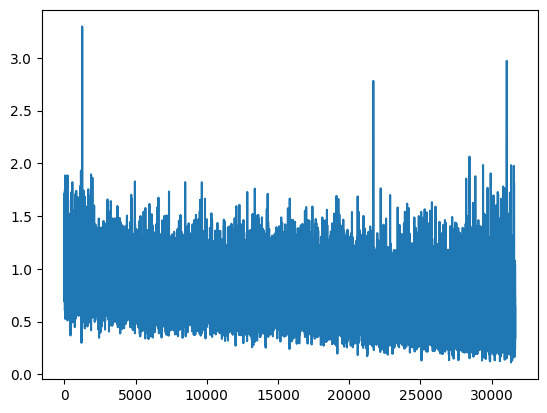

In [41]:
plt.plot(train_losses)

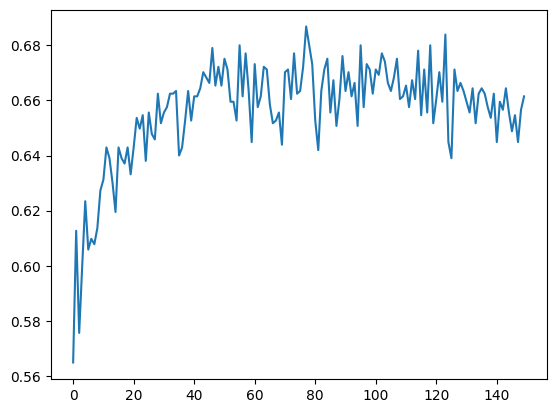

In [42]:
plt.plot(test_accuracy)

In [44]:
checkpoint_path = '../models_cremad4/cremad4_m18_150epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)